In [10]:
import numpy as np
import pybobyqa

def analytical_solution(X):    
    mus_alice = X[0]
    std_alice = X[1]
    
    mus_rest = X[2]
    std_res = X[3]
    
    return -(np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2

x0 = np.array([0, 15, 0, 15])

lower = np.array([-1000, 10, -1000, 10])
upper = np.array([1000, 1000, 1000, 1000])
soln = pybobyqa.solve(analytical_solution, x0, bounds=(lower, upper))
print(soln)

****** Py-BOBYQA Results ******
Solution xmin = [ 927.01970705 1000.          855.18987819   10.        ]
Objective value f(xmin) = -4.605220183
Needed 125 objective evaluations (at 125 points)
Approximate gradient = [ 3.46755882e-22 -9.99586197e-04 -2.42849195e-22  9.99899534e-02]
Approximate Hessian = [[ 6.07736084e-13 -1.91284861e+00 -1.05415676e-13  5.65892655e-04]
 [-1.91284861e+00  1.16368359e+01 -1.07458912e+01  5.93607198e-04]
 [-1.05415676e-13 -1.07458912e+01 -3.07198711e-13 -4.12200078e-04]
 [ 5.65892655e-04  5.93607198e-04 -4.12200078e-04 -5.36122668e-03]]
Exit flag = 0
Success: rho has reached rhoend
******************************



In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd

In [38]:
def analytical_solution(mus_alice, std_alice, mus_rest, std_res):
    return (np.log(std_alice**2+std_res**2)-np.log(std_res**2))/2


def f(x):
    return sum(x)

def analyse_normal_numpy(X):
    np.random.seed(12345)
    
    mus_alice = X[0]
    std_alice = X[1]
    
    mus_rest = X[2]
    std_res = X[3]
    
    
    alice = np.random.normal(mus_alice, std_alice, size=10_000)
    rest = np.random.normal(mus_rest, std_res, size=10_000)
    
    db = [f(x) for x in zip(alice, rest)]
    I = mutual_info_regression(alice.reshape((-1,1)), db, discrete_features=False)[0]
        
    return -I

analyse_normal_numpy([0,1000,0,10])

-4.624809837749536

In [44]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

x0 = np.asarray([0,10,0,10])
bounds = np.asarray([[-1000,1000],[10,1000],[-1000,1000],[10,1000]])
differential_evolution(analyse_normal_numpy,bounds)

     fun: -3.0511374726453013
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60065
     nit: 1000
 success: False
       x: array([-991.2762148 ,  353.78358275,  958.36936672,   16.85064594])

In [43]:
from pyswarms.single.global_best import GlobalBestPSO

# instatiate the optimizer
bounds = (np.asarray([-1000,10,-1000,10]), np.asarray([1000,1000,1000,1000]))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=30, dimensions=4, options=options, bounds=bounds)

def reshaper(x):
    return [analyse_normal_numpy(xi) for xi in x]

cost, pos = optimizer.optimize(reshaper, 1000)

2021-03-31 12:57:43,913 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-4.29
2021-03-31 13:27:56,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4.285045094191622, best pos: [-672.25933875  970.52955429 -262.7438715    13.63158012]


<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

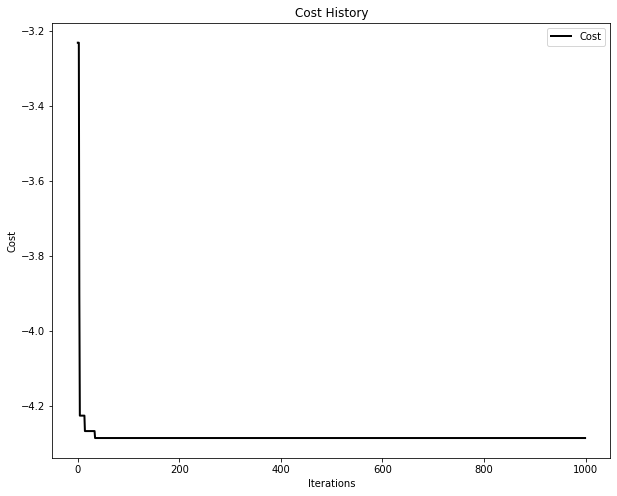

In [45]:
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
plot_cost_history(cost_history=optimizer.cost_history)

In [52]:
def f(x):
    return sum(x)

def analyse_normal(X):
    np.random.seed(12345)
    
    std_alice = X[0]
    std_res = X[1]
    
    with pm.Model() as model:
        
        alice = pm.Normal("alice", 0, std_alice, shape=1)
        
        rest = pm.Normal("rest", 0, std_res, shape=1)
        
        db = np.empty(2, dtype=object)
        db[0] = alice[0]
        db[1] = rest[0]
        
        out = pm.Deterministic("out", f(db))
        
        trace = pm.sample(10_000, cores=2, return_inferencedata=False)
        
        I = mutual_info_regression(trace["alice"].reshape((-1,1)), trace["out"], discrete_features=False)[0]
        
        return -I
    
x0 = np.array([15, 15])

lower = np.array([ 10,  10])
upper = np.array([1000, 1000])
#soln = pybobyqa.solve(analyse_normal, x0, bounds=(lower, upper))
#print(soln)

In [39]:
x0 = np.array([0, 15, 0, 15])

lower = np.array([-1000, 10, -1000, 10])
upper = np.array([1000, 1000, 1000, 1000])
def reshaper(x):
    return [analyse_normal_numpy(xi) for xi in x]
soln = pybobyqa.solve(reshaper, x0, bounds=(lower, upper))
print(soln)

NameError: name 'pybobyqa' is not defined

In [43]:
def f(x):
    print(x)
    x,y = x
    return 2*x**2+x+y**2

swarms_best = None
x_bound = (0,11)
y_bound = (10,21)
particles = 10
x = np.asarray(list(zip(np.random.uniform(x_bound[0],x_bound[1], size=particles),np.random.uniform(x_bound[0],x_bound[1], size=particles))))
p = x
swarms_best = p[0]
for pi in p:
    if f(pi) < f(swarms_best):
        swarms_best = pi
velocity_x = np.random.uniform(-abs(x_bound[1]-x_bound[0]), abs(x_bound[1]-x_bound[0]), size=particles)
velocity_y = np.random.uniform(-abs(y_bound[1]-y_bound[0]), abs(y_bound[1]-y_bound[0]), size=particles)
v=np.asarray(list(zip(velocity_x,velocity_y)))
epochs = 10_000
for _ in range(epochs):
    for i in range(particles):
        for d in range(2):
            rp,rg = np.random.uniform(0,1,size=2)
            v[i][d] = v[i][d]+rp*(p[i][d]-x[i][d])+rg*(swarms_best[d]-x[i][d])
        x[i] = x[i] + 0.1*v[i]
        if f(x[i]) < f(p[i]):
            p[i] = x[i]
            if f(p[i]) < f(swarms_best):
                swarms_best = p[i]

[ 6.59357343 10.28327036]
[ 6.59357343 10.28327036]
[6.43766794 9.73611864]
[ 6.59357343 10.28327036]
[ 5.27392705 10.67008043]
[6.43766794 9.73611864]
[3.42968213 8.47782063]
[ 5.27392705 10.67008043]
[3.54592363 6.39938829]
[3.42968213 8.47782063]
[1.15943563 6.8637769 ]
[3.54592363 6.39938829]
[ 1.31786124 10.19910066]
[1.15943563 6.8637769 ]
[5.77153406 2.34921584]
[1.15943563 6.8637769 ]
[5.5127879  5.04159742]
[1.15943563 6.8637769 ]
[6.47627079 1.45726777]
[1.15943563 6.8637769 ]
[6.07514177 9.69703812]
[6.07514177 9.69703812]
[5.88030919 8.83680038]
[5.88030919 8.83680038]
[ 4.53405143 10.51833885]
[ 4.53405143 10.51833885]
[3.50579972 8.89636622]
[3.50579972 8.89636622]
[4.43685098 6.59144823]
[4.43685098 6.59144823]
[0.37141213 7.31941978]
[0.37141213 7.31941978]
[ 0.62163314 10.88712073]
[ 0.62163314 10.88712073]
[5.78200332 1.77232183]
[5.78200332 1.77232183]
[5.97735362 4.95027605]
[5.97735362 4.95027605]
[5.72881218 2.07680973]
[5.72881218 2.07680973]
[5.37819183 8.900967

[-40.63341457  32.82955802]
[-40.63341457  32.82955802]
[-50.71789115  32.05737818]
[-50.71789115  32.05737818]
[-40.6058095   31.01284949]
[-40.6058095   31.01284949]
[-39.88517128  36.83967671]
[-39.88517128  36.83967671]
[-33.33995557  23.8509215 ]
[-33.33995557  23.8509215 ]
[-36.70217656  29.27320111]
[-36.70217656  29.27320111]
[-41.27561604  26.99280851]
[-41.27561604  26.99280851]
[-37.2368441  35.7928385]
[-37.2368441  35.7928385]
[-44.51712885  40.74264498]
[-44.51712885  40.74264498]
[-38.25281512  36.8881027 ]
[-38.25281512  36.8881027 ]
[-39.79479655  33.28799533]
[-39.79479655  33.28799533]
[-49.60960729  32.21405362]
[-49.60960729  32.21405362]
[-41.393833    31.46849237]
[-41.393833    31.46849237]
[-40.50898251  37.62906649]
[-40.50898251  37.62906649]
[-32.93701042  22.46811457]
[-32.93701042  22.46811457]
[-36.11787953  28.99732119]
[-36.11787953  28.99732119]
[-41.41930648  25.92123216]
[-41.41930648  25.92123216]
[-37.32568342  34.85307432]
[-37.32568342  34.853074

[-81.74861587  53.33914226]
[-81.74861587  53.33914226]
[-74.71010973  58.89792771]
[-74.71010973  58.89792771]
[-84.02444894  40.89778645]
[-84.02444894  40.89778645]
[-69.10142216  41.67591382]
[-69.10142216  41.67591382]
[-76.48976127  43.0456966 ]
[-76.48976127  43.0456966 ]
[-80.74713992  48.7843228 ]
[-80.74713992  48.7843228 ]
[-74.6179652   49.44748032]
[-74.6179652   49.44748032]
[-74.49081971  50.60549328]
[-74.49081971  50.60549328]
[-76.48019    48.8983507]
[-76.48019    48.8983507]
[-82.8567963   62.47110717]
[-82.8567963   62.47110717]
[-81.92326552  54.50755128]
[-81.92326552  54.50755128]
[-76.28677791  60.47219285]
[-76.28677791  60.47219285]
[-86.22331039  43.01632118]
[-86.22331039  43.01632118]
[-69.94338121  41.20108976]
[-69.94338121  41.20108976]
[-77.63794132  44.18732077]
[-77.63794132  44.18732077]
[-83.43630667  48.91060258]
[-83.43630667  48.91060258]
[-78.42872704  50.05768005]
[-78.42872704  50.05768005]
[-75.2788432   51.06113616]
[-75.2788432   51.061136

[-112.51958796   69.67690915]
[-112.51958796   69.67690915]
[-104.43571244   67.91992268]
[-104.43571244   67.91992268]
[-103.42762584   64.90872475]
[-103.42762584   64.90872475]
[-93.3257443   63.91661989]
[-93.3257443   63.91661989]
[-100.01324636   68.02125093]
[-100.01324636   68.02125093]
[-108.01339689   63.85107324]
[-108.01339689   63.85107324]
[-96.86992971  76.47837812]
[-96.86992971  76.47837812]
[-109.99982425   69.46236958]
[-109.99982425   69.46236958]
[-105.11237418   75.63096767]
[-105.11237418   75.63096767]
[-101.27306515   68.34881492]
[-101.27306515   68.34881492]
[-112.63473965   70.27384646]
[-112.63473965   70.27384646]
[-105.22373593   68.37556556]
[-105.22373593   68.37556556]
[-103.95545578   66.26175986]
[-103.95545578   66.26175986]
[-91.78864181  60.70854171]
[-91.78864181  60.70854171]
[-100.58445864   67.5329222 ]
[-100.58445864   67.5329222 ]
[-108.13134696   60.82128742]
[-108.13134696   60.82128742]
[-95.58842581  77.1639718 ]
[-95.58842581  77.163971

[-130.51395605   89.92785141]
[-130.51395605   89.92785141]
[-124.67270994   84.72599005]
[-124.67270994   84.72599005]
[-133.59258168   84.7787092 ]
[-133.59258168   84.7787092 ]
[-132.37115379   89.67682338]
[-132.37115379   89.67682338]
[-129.26990124   56.71389734]
[-129.26990124   56.71389734]
[-131.9207321    81.57472086]
[-131.9207321    81.57472086]
[-130.57799464   78.75524235]
[-130.57799464   78.75524235]
[-122.5423609    79.32121239]
[-122.5423609    79.32121239]
[-137.45686045   94.58067546]
[-137.45686045   94.58067546]
[-131.05165642   95.06883893]
[-131.05165642   95.06883893]
[-130.27338788   89.6985323 ]
[-130.27338788   89.6985323 ]
[-124.48868312   84.79668266]
[-124.48868312   84.79668266]
[-134.38060518   85.23435208]
[-134.38060518   85.23435208]
[-133.71144799   90.76799386]
[-133.71144799   90.76799386]
[-135.26212929   61.02937398]
[-135.26212929   61.02937398]
[-135.02261333   82.38876022]
[-135.02261333   82.38876022]
[-130.97255443   81.54075556]
[-130.9725

[-161.26789455   95.84506757]
[-153.10438588   96.073307  ]
[-153.10438588   96.073307  ]
[-145.0976764    87.79504231]
[-145.0976764    87.79504231]
[-153.47081675  110.06762892]
[-153.47081675  110.06762892]
[-153.81565661  111.32812484]
[-153.81565661  111.32812484]
[-152.28699764   98.88639483]
[-152.28699764   98.88639483]
[-146.61920215   97.06436329]
[-146.61920215   97.06436329]
[-157.23328648   98.44799556]
[-157.23328648   98.44799556]
[-158.56405206  102.55357734]
[-158.56405206  102.55357734]
[-164.08206611   91.80479671]
[-164.08206611   91.80479671]
[-165.29164086   97.0443504 ]
[-165.29164086   97.0443504 ]
[-154.05583911   99.95882193]
[-154.05583911   99.95882193]
[-153.30300661   87.2009354 ]
[-153.30300661   87.2009354 ]
[-152.74548995  109.22779615]
[-152.74548995  109.22779615]
[-155.60082983  109.00008051]
[-155.60082983  109.00008051]
[-152.50028749   97.43304239]
[-152.50028749   97.43304239]
[-147.00898131   97.39474382]
[-147.00898131   97.39474382]
[-158.0213

[-202.37963816  118.95007676]
[-202.37963816  118.95007676]
[-191.11829668  118.04063936]
[-191.11829668  118.04063936]
[-191.50764195  113.13784089]
[-191.50764195  113.13784089]
[-192.47713082  106.24845802]
[-192.47713082  106.24845802]
[-195.78559629  122.43204687]
[-195.78559629  122.43204687]
[-194.45295531  121.99891851]
[-194.45295531  121.99891851]
[-184.86877811  133.14434958]
[-184.86877811  133.14434958]
[-200.40789177  111.00747958]
[-200.40789177  111.00747958]
[-193.14177517  112.49445278]
[-193.14177517  112.49445278]
[-199.48755161  127.111754  ]
[-199.48755161  127.111754  ]
[-203.95626584  119.60323569]
[-203.95626584  119.60323569]
[-191.90632017  118.49628224]
[-191.90632017  118.49628224]
[-191.36213821  113.7246897 ]
[-191.36213821  113.7246897 ]
[-189.98915212  102.83485056]
[-189.98915212  102.83485056]
[-190.68730809  121.89199969]
[-190.68730809  121.89199969]
[-195.13809499  118.40329874]
[-195.13809499  118.40329874]
[-181.40179271  132.60124404]
[-181.4017

[-229.76840416  124.48019848]
[-212.72191827  144.52485648]
[-212.72191827  144.52485648]
[-224.86810646  148.63257494]
[-224.86810646  148.63257494]
[-223.51427512  134.01083972]
[-223.51427512  134.01083972]
[-215.54702496  132.1655686 ]
[-215.54702496  132.1655686 ]
[-214.76630191  126.49288923]
[-214.76630191  126.49288923]
[-204.38142887  116.06411927]
[-204.38142887  116.06411927]
[-194.26369834  134.29693543]
[-194.26369834  134.29693543]
[-217.14105483  120.96324058]
[-217.14105483  120.96324058]
[-199.85128838  139.39047833]
[-199.85128838  139.39047833]
[-230.71605195  130.78525459]
[-230.71605195  130.78525459]
[-212.17646933  149.93132404]
[-212.17646933  149.93132404]
[-223.72148945  148.29418656]
[-223.72148945  148.29418656]
[-223.80520184  134.34052438]
[-223.80520184  134.34052438]
[-216.33504845  132.62121148]
[-216.33504845  132.62121148]
[-215.21265251  128.38300924]
[-215.21265251  128.38300924]
[-201.57565846  111.4322428 ]
[-201.57565846  111.4322428 ]
[-190.9585

[-248.29259739  195.62249559]
[-248.29259739  195.62249559]
[-240.69284704  171.58206386]
[-240.69284704  171.58206386]
[-226.82901438  126.33711095]
[-226.82901438  126.33711095]
[-240.06518167  147.13863327]
[-240.06518167  147.13863327]
[-245.4919177  149.479998 ]
[-245.4919177  149.479998 ]
[-246.48357971  159.03903983]
[-246.48357971  159.03903983]
[-243.08984779  147.37576085]
[-243.08984779  147.37576085]
[-272.54110515  143.48370921]
[-272.54110515  143.48370921]
[-244.61716765  145.24569394]
[-244.61716765  145.24569394]
[-257.12646793  144.77563952]
[-257.12646793  144.77563952]
[-246.02234864  198.6514945 ]
[-246.02234864  198.6514945 ]
[-242.48677715  162.14808431]
[-242.48677715  162.14808431]
[-227.52286518  124.98552481]
[-227.52286518  124.98552481]
[-239.60863416  147.46526622]
[-239.60863416  147.46526622]
[-246.27994119  149.93564088]
[-246.27994119  149.93564088]
[-247.8049716   159.90883211]
[-247.8049716   159.90883211]
[-248.30179203  155.28899512]
[-248.30179203

[-273.73293265  154.46707763]
[-273.73293265  154.46707763]
[-223.51481361  171.54487043]
[-223.51481361  171.54487043]
[-284.19374363  161.45244486]
[-284.19374363  161.45244486]
[-281.5882419   174.15174647]
[-281.5882419   174.15174647]
[-283.70516978  124.8370359 ]
[-283.70516978  124.8370359 ]
[-279.28440629  205.01635112]
[-279.28440629  205.01635112]
[-305.57252307  172.39866734]
[-305.57252307  172.39866734]
[-290.74114486  172.77548515]
[-290.74114486  172.77548515]
[-282.52902187  170.89521331]
[-282.52902187  170.89521331]
[-280.89055391  167.90288829]
[-280.89055391  167.90288829]
[-270.98871432  150.41865998]
[-270.98871432  150.41865998]
[-228.4888708   168.25433027]
[-228.4888708   168.25433027]
[-284.55832078  160.31798232]
[-284.55832078  160.31798232]
[-284.83690306  178.35813141]
[-284.83690306  178.35813141]
[-288.48003732  133.96505308]
[-288.48003732  133.96505308]
[-278.88947526  210.96574133]
[-278.88947526  210.96574133]
[-306.47207795  163.67776393]
[-306.4720

[-292.21774164  169.72271927]
[-280.59182728  101.96420496]
[-280.59182728  101.96420496]
[-301.86972855  208.91593521]
[-301.86972855  208.91593521]
[-315.65364731  189.79556434]
[-315.65364731  189.79556434]
[-311.3949184   184.86526031]
[-311.3949184   184.86526031]
[-302.2296092   182.28628528]
[-302.2296092   182.28628528]
[-300.86006595  165.59581224]
[-300.86006595  165.59581224]
[-300.32320049  165.92213504]
[-300.32320049  165.92213504]
[-252.66981887  187.52820052]
[-252.66981887  187.52820052]
[-304.91619076  184.40114621]
[-304.91619076  184.40114621]
[-293.57187163  172.27719387]
[-293.57187163  172.27719387]
[-283.05538842  106.44968785]
[-283.05538842  106.44968785]
[-301.32850004  220.16108791]
[-301.32850004  220.16108791]
[-320.32394975  180.44570755]
[-320.32394975  180.44570755]
[-312.71922874  185.29331604]
[-312.71922874  185.29331604]
[-303.01763269  182.74192816]
[-303.01763269  182.74192816]
[-301.43096958  166.64524961]
[-301.43096958  166.64524961]
[-297.5542

[-338.21242142  199.05031929]
[-338.21242142  199.05031929]
[-328.23438447  197.32250029]
[-328.23438447  197.32250029]
[-327.45685103  178.04347378]
[-327.45685103  178.04347378]
[-314.6114555   176.89914929]
[-314.6114555   176.89914929]
[-294.92869697  186.85827823]
[-294.92869697  186.85827823]
[-327.40213403  190.65227727]
[-327.40213403  190.65227727]
[-319.59571239  206.23554043]
[-319.59571239  206.23554043]
[-332.35928976  214.74349979]
[-332.35928976  214.74349979]
[-322.47918536  238.4998893 ]
[-322.47918536  238.4998893 ]
[-344.39420618  156.16793014]
[-344.39420618  156.16793014]
[-337.62044147  199.11504829]
[-337.62044147  199.11504829]
[-329.02240796  197.77814316]
[-329.02240796  197.77814316]
[-328.67902392  180.73927476]
[-328.67902392  180.73927476]
[-314.87217885  179.22775022]
[-314.87217885  179.22775022]
[-302.16146124  185.70620767]
[-302.16146124  185.70620767]
[-327.74615593  189.83722093]
[-327.74615593  189.83722093]
[-321.28059188  209.28683314]
[-321.2805

[-365.25372845  222.0406552 ]
[-365.25372845  222.0406552 ]
[-372.79287496  260.57049598]
[-372.79287496  260.57049598]
[-355.38049189  204.43254496]
[-355.38049189  204.43254496]
[-352.06913175  228.57464923]
[-352.06913175  228.57464923]
[-347.57013371  210.60607379]
[-347.57013371  210.60607379]
[-356.60323022  213.72564393]
[-356.60323022  213.72564393]
[-359.45020953  227.13475389]
[-359.45020953  227.13475389]
[-356.51222622  220.90279841]
[-356.51222622  220.90279841]
[-378.98222216  207.32976354]
[-378.98222216  207.32976354]
[-355.51989343  207.38380149]
[-355.51989343  207.38380149]
[-368.73982271  220.297455  ]
[-368.73982271  220.297455  ]
[-369.79442366  239.66669339]
[-369.79442366  239.66669339]
[-357.88489387  196.59021394]
[-357.88489387  196.59021394]
[-349.90370894  238.49483627]
[-349.90370894  238.49483627]
[-346.97621531  210.59829374]
[-346.97621531  210.59829374]
[-357.39125371  214.1812868 ]
[-357.39125371  214.1812868 ]
[-360.2857171   231.15185561]
[-360.2857

[-392.84851636  264.64203916]
[-395.37470858  206.04493701]
[-395.37470858  206.04493701]
[-399.18492759  236.90882539]
[-399.18492759  236.90882539]
[-392.8523109   234.68521636]
[-392.8523109   234.68521636]
[-392.84618222  229.08696238]
[-392.84618222  229.08696238]
[-384.10118526  221.74447451]
[-384.10118526  221.74447451]
[-332.93616381  244.59694589]
[-332.93616381  244.59694589]
[-393.12154201  233.43335743]
[-393.12154201  233.43335743]
[-374.13650942  242.01892427]
[-374.13650942  242.01892427]
[-397.10519879  224.82457716]
[-397.10519879  224.82457716]
[-392.19823814  265.68985168]
[-392.19823814  265.68985168]
[-398.23421745  211.13947938]
[-398.23421745  211.13947938]
[-401.49886955  236.9958794 ]
[-401.49886955  236.9958794 ]
[-393.64033439  235.14085923]
[-393.64033439  235.14085923]
[-394.20848279  234.59938743]
[-394.20848279  234.59938743]
[-382.14204218  219.61926371]
[-382.14204218  219.61926371]
[-332.24962204  242.94947805]
[-332.24962204  242.94947805]
[-393.2717

[-376.24962969  273.87786017]
[-376.24962969  273.87786017]
[-434.65666039  268.06740357]
[-434.65666039  268.06740357]
[-397.90408088  246.5004703 ]
[-397.90408088  246.5004703 ]
[-406.23311552  148.36409526]
[-406.23311552  148.36409526]
[-441.27709754  251.23653152]
[-441.27709754  251.23653152]
[-423.50472141  230.63655732]
[-423.50472141  230.63655732]
[-426.05833131  260.18075158]
[-426.05833131  260.18075158]
[-433.04150904  257.92300318]
[-433.04150904  257.92300318]
[-431.3937957   257.81862784]
[-431.3937957   257.81862784]
[-443.28316167  273.2217347 ]
[-443.28316167  273.2217347 ]
[-369.85679018  276.03907478]
[-369.85679018  276.03907478]
[-435.14814993  268.103969  ]
[-435.14814993  268.103969  ]
[-401.22083921  249.69666277]
[-401.22083921  249.69666277]
[-409.75479946  160.99518384]
[-409.75479946  160.99518384]
[-441.85393041  257.85113145]
[-441.85393041  257.85113145]
[-426.56523389  232.12894358]
[-426.56523389  232.12894358]
[-428.58304686  260.91881941]
[-428.5830

[-468.50256623  278.42693273]
[-473.07158012  255.44785047]
[-473.07158012  255.44785047]
[-460.71919042  283.70221317]
[-460.71919042  283.70221317]
[-523.20205555  257.52635972]
[-523.20205555  257.52635972]
[-468.47089962  273.36934228]
[-468.47089962  273.36934228]
[-489.30391413  270.65351598]
[-489.30391413  270.65351598]
[-470.35932148  373.8254936 ]
[-470.35932148  373.8254936 ]
[-462.59570843  256.74927223]
[-462.59570843  256.74927223]
[-473.95386906  287.10618028]
[-473.95386906  287.10618028]
[-458.17908875  276.34991168]
[-458.17908875  276.34991168]
[-469.29058972  278.88257561]
[-469.29058972  278.88257561]
[-474.00235319  254.09556775]
[-474.00235319  254.09556775]
[-463.16260225  291.70296762]
[-463.16260225  291.70296762]
[-527.30211429  259.45274478]
[-527.30211429  259.45274478]
[-469.78115468  277.46898675]
[-469.78115468  277.46898675]
[-486.6070262  268.4980197]
[-486.6070262  268.4980197]
[-462.69444102  360.68286971]
[-462.69444102  360.68286971]
[-464.27386068

[-501.00781671  307.70232982]
[-468.36880449  281.77301258]
[-468.36880449  281.77301258]
[-456.20883222  195.45801197]
[-456.20883222  195.45801197]
[-506.88997225  293.38092811]
[-506.88997225  293.38092811]
[-489.45594408  277.94850053]
[-489.45594408  277.94850053]
[-482.81362308  297.81360942]
[-482.81362308  297.81360942]
[-500.02350595  296.65264789]
[-500.02350595  296.65264789]
[-497.27712776  318.06629862]
[-497.27712776  318.06629862]
[-515.75874386  346.63077888]
[-515.75874386  346.63077888]
[-455.65667539  313.37686468]
[-455.65667539  313.37686468]
[-501.42994169  306.55313907]
[-501.42994169  306.55313907]
[-467.85980443  284.13438777]
[-467.85980443  284.13438777]
[-460.89935493  169.04930258]
[-460.89935493  169.04930258]
[-508.05099292  298.88090831]
[-508.05099292  298.88090831]
[-493.22433388  283.22286026]
[-493.22433388  283.22286026]
[-488.25733384  299.24967471]
[-488.25733384  299.24967471]
[-500.81152944  297.10829076]
[-500.81152944  297.10829076]
[-497.6799

[-557.75123046  313.15118086]
[-557.75123046  313.15118086]
[-618.44759155  491.71934498]
[-618.44759155  491.71934498]
[-532.49908977  306.40054158]
[-532.49908977  306.40054158]
[-527.92631648  308.4918372 ]
[-527.92631648  308.4918372 ]
[-521.41580408  314.00466805]
[-521.41580408  314.00466805]
[-537.06061012  318.06786319]
[-537.06061012  318.06786319]
[-538.63605265  294.341457  ]
[-538.63605265  294.341457  ]
[-553.9876458   307.11109929]
[-553.9876458   307.11109929]
[-581.25387343  300.31820497]
[-581.25387343  300.31820497]
[-539.37322287  329.15256002]
[-539.37322287  329.15256002]
[-560.89256456  309.13868678]
[-560.89256456  309.13868678]
[-616.71281416  467.42527972]
[-616.71281416  467.42527972]
[-535.16017328  306.38086008]
[-535.16017328  306.38086008]
[-525.45910352  304.58086206]
[-525.45910352  304.58086206]
[-519.17337274  314.43496661]
[-519.17337274  314.43496661]
[-537.84863362  318.52350607]
[-537.84863362  318.52350607]
[-538.89531049  295.29290971]
[-538.8953

[-544.77059448  339.54909755]
[-544.77059448  339.54909755]
[-569.63130624  355.31982263]
[-569.63130624  355.31982263]
[-543.54859413  355.38441572]
[-543.54859413  355.38441572]
[-495.41296511  251.98224302]
[-495.41296511  251.98224302]
[-569.06279173  349.27791696]
[-569.06279173  349.27791696]
[-585.21095511  364.63192656]
[-585.21095511  364.63192656]
[-588.06395018  339.87479145]
[-588.06395018  339.87479145]
[-571.73364382  338.11614987]
[-571.73364382  338.11614987]
[-571.81622313  367.82516408]
[-571.81622313  367.82516408]
[-563.5228091   288.34371218]
[-563.5228091   288.34371218]
[-543.87591999  335.31409675]
[-543.87591999  335.31409675]
[-570.27050741  351.17007232]
[-570.27050741  351.17007232]
[-541.16363143  356.45034744]
[-541.16363143  356.45034744]
[-501.86283778  288.71393374]
[-501.86283778  288.71393374]
[-568.10810419  349.21119088]
[-568.10810419  349.21119088]
[-596.08956199  366.30284104]
[-596.08956199  366.30284104]
[-587.46738908  339.15331254]
[-587.4673

[-592.22225464  349.96286472]
[-592.22225464  349.96286472]
[-590.58626581  386.52674641]
[-590.58626581  386.52674641]
[-588.89941439  316.86481591]
[-588.89941439  316.86481591]
[-563.23660206  368.15885547]
[-563.23660206  368.15885547]
[-590.09195448  363.08579418]
[-590.09195448  363.08579418]
[-601.46325343  372.01567916]
[-601.46325343  372.01567916]
[-517.93721874  226.55389628]
[-517.93721874  226.55389628]
[-593.9320493   362.59617506]
[-593.9320493   362.59617506]
[-588.30055856  384.52373275]
[-588.30055856  384.52373275]
[-612.66526033  355.9408772 ]
[-612.66526033  355.9408772 ]
[-593.01027813  350.4185076 ]
[-593.01027813  350.4185076 ]
[-591.85627705  385.64032023]
[-591.85627705  385.64032023]
[-587.50701818  305.16366218]
[-587.50701818  305.16366218]
[-561.47882285  364.97591493]
[-561.47882285  364.97591493]
[-590.57918917  358.78907303]
[-590.57918917  358.78907303]
[-594.52821656  374.3359982 ]
[-594.52821656  374.3359982 ]
[-508.17497509  248.26013024]
[-508.1749

[-659.62834768  386.51077284]
[-627.92116731  365.22845712]
[-627.92116731  365.22845712]
[-634.41595975  352.32165707]
[-634.41595975  352.32165707]
[-751.32165966  614.65542634]
[-751.32165966  614.65542634]
[-616.75309029  348.94026969]
[-616.75309029  348.94026969]
[-635.0470417   365.59378843]
[-635.0470417   365.59378843]
[-605.06439879  371.2694462 ]
[-605.06439879  371.2694462 ]
[-626.89528833  370.01115139]
[-626.89528833  370.01115139]
[-628.15391201  330.10310239]
[-628.15391201  330.10310239]
[-633.18733085  421.67278157]
[-633.18733085  421.67278157]
[-669.15856392  392.19039294]
[-669.15856392  392.19039294]
[-629.27959857  370.99909726]
[-629.27959857  370.99909726]
[-641.95067336  351.84335734]
[-641.95067336  351.84335734]
[-744.02781145  606.52276005]
[-744.02781145  606.52276005]
[-621.66390303  349.37524254]
[-621.66390303  349.37524254]
[-622.69083882  358.88462995]
[-622.69083882  358.88462995]
[-606.8655338   373.63770977]
[-606.8655338   373.63770977]
[-627.6833

[-665.87812302  414.63498876]
[-665.87812302  414.63498876]
[-668.22236842  414.90908328]
[-668.22236842  414.90908328]
[-677.5211224   382.77982561]
[-677.5211224   382.77982561]
[-659.99227504  389.1481523 ]
[-659.99227504  389.1481523 ]
[-660.69101454  464.90955245]
[-660.69101454  464.90955245]
[-650.29805204  331.05885258]
[-650.29805204  331.05885258]
[-647.25612761  355.41400453]
[-647.25612761  355.41400453]
[-659.62457327  384.67828345]
[-659.62457327  384.67828345]
[-673.92034679  420.72010711]
[-673.92034679  420.72010711]
[-452.26581143   40.38773612]
[-452.26581143   40.38773612]
[-662.07453071  413.54652017]
[-662.07453071  413.54652017]
[-681.81800692  421.58003318]
[-681.81800692  421.58003318]
[-680.06798651  382.10822348]
[-680.06798651  382.10822348]
[-660.78029853  389.60379518]
[-660.78029853  389.60379518]
[-662.18051826  466.7550567 ]
[-662.18051826  466.7550567 ]
[-648.6216325   334.88498744]
[-648.6216325   334.88498744]
[-634.64086593  355.01345586]
[-634.6408

[-727.43577276  439.9508374 ]
[-727.43577276  439.9508374 ]
[-532.6436163  116.548519 ]
[-532.6436163  116.548519 ]
[-692.85969388  415.05671881]
[-692.85969388  415.05671881]
[-692.90782913  418.53492077]
[-692.90782913  418.53492077]
[-693.58229198  395.12117477]
[-693.58229198  395.12117477]
[-680.48088586  400.99486715]
[-680.48088586  400.99486715]
[-679.54820552  458.5114737 ]
[-679.54820552  458.5114737 ]
[-683.23828429  374.33036286]
[-683.23828429  374.33036286]
[-709.68287866  379.93542062]
[-709.68287866  379.93542062]
[-679.67547902  398.30890207]
[-679.67547902  398.30890207]
[-721.92108419  442.82869684]
[-721.92108419  442.82869684]
[-495.64887852   64.3515752 ]
[-495.64887852   64.3515752 ]
[-690.6995502   419.29683471]
[-690.6995502   419.29683471]
[-701.60590498  425.5192199 ]
[-701.60590498  425.5192199 ]
[-698.07129769  393.90831038]
[-698.07129769  393.90831038]
[-681.26890935  401.45051003]
[-681.26890935  401.45051003]
[-681.05893215  454.25546299]
[-681.05893215

[-667.76428086  410.69136195]
[-717.61088144  430.34641539]
[-717.61088144  430.34641539]
[-669.51819667  380.73190408]
[-669.51819667  380.73190408]
[-978.31034628  821.31306181]
[-978.31034628  821.31306181]
[-711.25214968  397.53726545]
[-711.25214968  397.53726545]
[-704.96851486  393.69243394]
[-704.96851486  393.69243394]
[-701.44724454  430.48039344]
[-701.44724454  430.48039344]
[-714.36589606  420.58751095]
[-714.36589606  420.58751095]
[-714.35166697  377.34489112]
[-714.35166697  377.34489112]
[-705.08392118  447.53270904]
[-705.08392118  447.53270904]
[-683.64227774  418.05404903]
[-683.64227774  418.05404903]
[-718.46926875  433.98476282]
[-718.46926875  433.98476282]
[-678.71512504  386.71288545]
[-678.71512504  386.71288545]
[-1007.63537658   815.6295706 ]
[-1007.63537658   815.6295706 ]
[-716.63742301  394.73767946]
[-716.63742301  394.73767946]
[-698.00933348  391.65201687]
[-698.00933348  391.65201687]
[-698.13223287  431.80534826]
[-698.13223287  431.80534826]
[-715.

[-777.25248657  435.3005375 ]
[-777.25248657  435.3005375 ]
[-751.40300023  442.00272625]
[-751.40300023  442.00272625]
[-756.45876834  393.80129482]
[-756.45876834  393.80129482]
[-748.14055812  419.73124959]
[-748.14055812  419.73124959]
[-709.65905654  401.07803703]
[-709.65905654  401.07803703]
[-751.41381497  419.09769869]
[-751.41381497  419.09769869]
[-746.14971074  436.77914279]
[-746.14971074  436.77914279]
[-447.07579146  668.42697648]
[-447.07579146  668.42697648]
[-725.3478049   456.41164314]
[-725.3478049   456.41164314]
[-790.55792452  474.41341126]
[-790.55792452  474.41341126]
[-780.80660646  437.94357495]
[-780.80660646  437.94357495]
[-752.19102373  442.45836913]
[-752.19102373  442.45836913]
[-757.15372649  382.42870706]
[-757.15372649  382.42870706]
[-745.71791424  422.30169024]
[-745.71791424  422.30169024]
[-704.34572877  402.23668108]
[-704.34572877  402.23668108]
[-753.21173421  417.76850671]
[-753.21173421  417.76850671]
[-731.23243594  431.52184794]
[-731.2324

[-790.01615139  464.32922732]
[-788.19280656  516.18546376]
[-788.19280656  516.18546376]
[-800.89248508  461.91382673]
[-800.89248508  461.91382673]
[-804.79215061  475.36918317]
[-804.79215061  475.36918317]
[-786.57963441  526.20801732]
[-786.57963441  526.20801732]
[-867.37610578  478.69391453]
[-867.37610578  478.69391453]
[-812.84071137  236.25222317]
[-812.84071137  236.25222317]
[-760.43466005  474.47122798]
[-760.43466005  474.47122798]
[-825.89234792  471.34718693]
[-825.89234792  471.34718693]
[-786.48609963  451.49118768]
[-786.48609963  451.49118768]
[-790.80417489  464.7848702 ]
[-790.80417489  464.7848702 ]
[-789.84563515  503.7221312 ]
[-789.84563515  503.7221312 ]
[-800.51159088  459.57927911]
[-800.51159088  459.57927911]
[-790.16442405  464.39250489]
[-790.16442405  464.39250489]
[-787.73011003  522.9918449 ]
[-787.73011003  522.9918449 ]
[-854.29623068  478.0842908 ]
[-854.29623068  478.0842908 ]
[-756.872852    300.83844775]
[-756.872852    300.83844775]
[-759.7607

[-817.27477687  479.73221764]
[-794.98526781  471.43637592]
[-794.98526781  471.43637592]
[-808.84663783  521.96373458]
[-808.84663783  521.96373458]
[-900.10772745  488.9769434 ]
[-900.10772745  488.9769434 ]
[-852.36455907  347.84767309]
[-852.36455907  347.84767309]
[-787.37404354  486.29127702]
[-787.37404354  486.29127702]
[-838.23685676  517.40660037]
[-838.23685676  517.40660037]
[-809.65822692  456.95161677]
[-809.65822692  456.95161677]
[-812.86883269  477.54287081]
[-812.86883269  477.54287081]
[-811.63389985  481.63377054]
[-811.63389985  481.63377054]
[-816.17442301  476.85535055]
[-816.17442301  476.85535055]
[-776.5350338   462.79558158]
[-776.5350338   462.79558158]
[-809.3579771   508.04765397]
[-809.3579771   508.04765397]
[-894.09492914  489.8341932 ]
[-894.09492914  489.8341932 ]
[-791.959553    421.40997432]
[-791.959553    421.40997432]
[-794.3902189   488.72225068]
[-794.3902189   488.72225068]
[-866.10658768  530.71686674]
[-866.10658768  530.71686674]
[-816.0351

[-849.88468025  418.36002633]
[-734.50612144  496.25816827]
[-734.50612144  496.25816827]
[-641.06573638 1034.26436137]
[-641.06573638 1034.26436137]
[-882.92317551  500.28950767]
[-882.92317551  500.28950767]
[-1027.78354934   519.35998329]
[-1027.78354934   519.35998329]
[-869.82041559  471.80508491]
[-869.82041559  471.80508491]
[-843.60174892  495.31294309]
[-843.60174892  495.31294309]
[-847.62151174  482.52561479]
[-847.62151174  482.52561479]
[-831.26821118  486.51570475]
[-831.26821118  486.51570475]
[-835.27867779  443.50684136]
[-835.27867779  443.50684136]
[-850.88934826  423.36215196]
[-850.88934826  423.36215196]
[-727.77097685  494.7387666 ]
[-727.77097685  494.7387666 ]
[-668.4096856 1020.9015131]
[-668.4096856 1020.9015131]
[-888.92697337  497.92234198]
[-888.92697337  497.92234198]
[-1004.38714323   507.5711141 ]
[-1004.38714323   507.5711141 ]
[-869.21408467  478.98072484]
[-869.21408467  478.98072484]
[-844.38977241  495.76858597]
[-844.38977241  495.76858597]
[-848.

[-874.93907596  559.99776542]
[-874.93907596  559.99776542]
[-1089.44622614   520.80620238]
[-1089.44622614   520.80620238]
[-926.16607004  229.37629237]
[-926.16607004  229.37629237]
[-834.38110215  516.16603123]
[-834.38110215  516.16603123]
[-719.2496159   473.88392403]
[-719.2496159   473.88392403]
[-866.71166631  520.41515316]
[-866.71166631  520.41515316]
[-879.06280611  515.81687264]
[-879.06280611  515.81687264]
[-877.9913086  381.9628072]
[-877.9913086  381.9628072]
[-891.35050204  516.3380272 ]
[-891.35050204  516.3380272 ]
[-765.41842351  573.22437537]
[-765.41842351  573.22437537]
[-876.75637367  546.68780718]
[-876.75637367  546.68780718]
[-1066.98908042   522.25597247]
[-1066.98908042   522.25597247]
[-900.31047103  358.19793577]
[-900.31047103  358.19793577]
[-842.04301181  519.76319135]
[-842.04301181  519.76319135]
[-752.7341596   485.99795182]
[-752.7341596   485.99795182]
[-874.4894608   511.38192975]
[-874.4894608   511.38192975]
[-879.8508296   516.27251552]
[-879.

[-673.4048367   532.57078958]
[-673.4048367   532.57078958]
[-785.7159219  1485.95755459]
[-785.7159219  1485.95755459]
[-914.82231959  541.45210352]
[-914.82231959  541.45210352]
[-1185.99956371   583.6929646 ]
[-1185.99956371   583.6929646 ]
[-920.64960579  492.27948731]
[-920.64960579  492.27948731]
[-908.21967535  532.67565916]
[-908.21967535  532.67565916]
[-911.30420715  407.60201509]
[-911.30420715  407.60201509]
[-921.04788528  505.85256718]
[-921.04788528  505.85256718]
[-876.94608725  463.64884286]
[-876.94608725  463.64884286]
[-914.09702804  485.72098875]
[-914.09702804  485.72098875]
[-673.13317673  531.7544925 ]
[-673.13317673  531.7544925 ]
[-792.22382873 1501.39595838]
[-792.22382873 1501.39595838]
[-928.71511302  540.22410561]
[-928.71511302  540.22410561]
[-1214.88294608   586.43890508]
[-1214.88294608   586.43890508]
[-912.42019205  496.79019669]
[-912.42019205  496.79019669]
[-909.00769884  533.13130203]
[-909.00769884  533.13130203]
[-911.58528983  389.14725548]
[-

[-857.35722173  520.02313663]
[-953.00388517  489.46489149]
[-953.00388517  489.46489149]
[-653.49518736  555.1768604 ]
[-653.49518736  555.1768604 ]
[-886.68804553 1195.40707384]
[-886.68804553 1195.40707384]
[-888.22324666  564.49065235]
[-888.22324666  564.49065235]
[-1335.20479385   606.11522051]
[-1335.20479385   606.11522051]
[-984.40857645  526.81156714]
[-984.40857645  526.81156714]
[-950.77294397  557.28037462]
[-950.77294397  557.28037462]
[-952.67129394  613.76034514]
[-952.67129394  613.76034514]
[-960.86303852  543.25423786]
[-960.86303852  543.25423786]
[-873.55751039  548.50220424]
[-873.55751039  548.50220424]
[-954.7331619   482.27222249]
[-954.7331619   482.27222249]
[-622.38227375  553.77886538]
[-622.38227375  553.77886538]
[-863.6018078  1290.67670539]
[-863.6018078  1290.67670539]
[-892.47195858  563.60523483]
[-892.47195858  563.60523483]
[-1555.65986866   597.10882972]
[-1555.65986866   597.10882972]
[-979.48471272  528.18453587]
[-979.48471272  528.18453587]
[-

[-983.86993068  576.41737553]
[-980.53080703  403.36119133]
[-980.53080703  403.36119133]
[-974.39470586  593.27215078]
[-974.39470586  593.27215078]
[-987.24003151  659.64691492]
[-987.24003151  659.64691492]
[-983.52913946  671.45206649]
[-983.52913946  671.45206649]
[-1175.63084395   588.36524442]
[-1175.63084395   588.36524442]
[-1162.8209743     55.59415157]
[-1162.8209743     55.59415157]
[-1043.16231023   570.70237914]
[-1043.16231023   570.70237914]
[-362.9452289   501.86767833]
[-362.9452289   501.86767833]
[-952.78021305  610.75563813]
[-952.78021305  610.75563813]
[-984.65795418  576.87301841]
[-984.65795418  576.87301841]
[-981.68202355  418.66274221]
[-981.68202355  418.66274221]
[-974.27375469  595.60793719]
[-974.27375469  595.60793719]
[-968.75524744  628.49428942]
[-968.75524744  628.49428942]
[-982.98593662  666.06570919]
[-982.98593662  666.06570919]
[-1209.67151728   589.32399202]
[-1209.67151728   589.32399202]
[-1191.94970223    -3.70233376]
[-1191.94970223    -3.

[-977.9715588   588.56752891]
[-1003.57051801   587.8084475 ]
[-1003.57051801   587.8084475 ]
[-1001.32492265   487.74232676]
[-1001.32492265   487.74232676]
[-995.30692454  604.90530062]
[-995.30692454  604.90530062]
[-1073.8716265    706.32443868]
[-1073.8716265    706.32443868]
[-1004.22473792   691.95484666]
[-1004.22473792   691.95484666]
[-910.26188856  594.02734126]
[-910.26188856  594.02734126]
[-1015.21422005   535.53102491]
[-1015.21422005   535.53102491]
[-1060.50091814   578.85942434]
[-1060.50091814   578.85942434]
[-1177.31861107   484.19934172]
[-1177.31861107   484.19934172]
[-972.61852708  600.85820197]
[-972.61852708  600.85820197]
[-1004.3585415    588.26409038]
[-1004.3585415    588.26409038]
[-1002.10299733   455.50888153]
[-1002.10299733   455.50888153]
[-993.41188051  609.82383857]
[-993.41188051  609.82383857]
[-1047.86560808   669.53000024]
[-1047.86560808   669.53000024]
[-1003.93835908   700.68576679]
[-1003.93835908   700.68576679]
[-971.71184795  596.837665

[-1059.66176645   565.4153995 ]
[-1059.66176645   565.4153995 ]
[-1181.78683218   650.1013931 ]
[-1181.78683218   650.1013931 ]
[-1041.4618496    497.52424125]
[-1041.4618496    497.52424125]
[-1061.57106965   595.80269247]
[-1061.57106965   595.80269247]
[-690.3433368   474.75846259]
[-690.3433368   474.75846259]
[-908.05234688  613.5311092 ]
[-908.05234688  613.5311092 ]
[-1106.79196766   726.16926567]
[-1106.79196766   726.16926567]
[-1073.47833547   621.9041234 ]
[-1073.47833547   621.9041234 ]
[-1039.0315752    608.31237705]
[-1039.0315752    608.31237705]
[-1043.16917538   776.53475249]
[-1043.16917538   776.53475249]
[-1062.41807704   562.03177585]
[-1062.41807704   562.03177585]
[-1201.68856498   730.69080027]
[-1201.68856498   730.69080027]
[-1043.58169387   506.41336419]
[-1043.58169387   506.41336419]
[-1003.86714594   596.36423525]
[-1003.86714594   596.36423525]
[-683.0810292   692.06238536]
[-683.0810292   692.06238536]
[-915.24221205  610.2689675 ]
[-915.24221205  610.26

[-1135.57569694   640.44133217]
[-1135.57569694   640.44133217]
[-1347.56661525  1026.28327245]
[-1347.56661525  1026.28327245]
[-1162.00798618   631.54322094]
[-1162.00798618   631.54322094]
[-598.67072648  559.47829485]
[-598.67072648  559.47829485]
[-1056.25013043   643.59093235]
[-1056.25013043   643.59093235]
[-1072.9165854    627.90502085]
[-1072.9165854    627.90502085]
[-1068.52808531   419.66469191]
[-1068.52808531   419.66469191]
[-1049.81754303   687.68233388]
[-1049.81754303   687.68233388]
[-932.63835552  729.1569961 ]
[-932.63835552  729.1569961 ]
[-1068.52444387   691.50792493]
[-1068.52444387   691.50792493]
[-1211.49539071   640.18609242]
[-1211.49539071   640.18609242]
[-1319.3919997    812.81411069]
[-1319.3919997    812.81411069]
[-1134.96305873   635.77073364]
[-1134.96305873   635.77073364]
[-118.45072522  610.35573031]
[-118.45072522  610.35573031]
[-1061.78747047   651.55146927]
[-1061.78747047   651.55146927]
[-1073.70460889   628.36066373]
[-1073.70460889   62

[-1094.1430955    759.80531156]
[-992.12217078  646.4918828 ]
[-992.12217078  646.4918828 ]
[-1456.86399915  1443.89127384]
[-1456.86399915  1443.89127384]
[-1252.21367391   623.30703715]
[-1252.21367391   623.30703715]
[-1562.73274945   432.81567884]
[-1562.73274945   432.81567884]
[-1069.4831884    597.49490613]
[-1069.4831884    597.49490613]
[-1092.61717272   639.29609282]
[-1092.61717272   639.29609282]
[-1092.61506067   343.42082741]
[-1092.61506067   343.42082741]
[-1061.7990236    663.67622195]
[-1061.7990236    663.67622195]
[-990.51411193  798.37315836]
[-990.51411193  798.37315836]
[-1093.35219113   778.76312993]
[-1093.35219113   778.76312993]
[-1054.26679498   649.20810951]
[-1054.26679498   649.20810951]
[-1430.99299896  1371.20319916]
[-1430.99299896  1371.20319916]
[-1246.43381726   628.28239272]
[-1246.43381726   628.28239272]
[-965.3006281   472.87886953]
[-965.3006281   472.87886953]
[-1075.01080394   599.56028708]
[-1075.01080394   599.56028708]
[-1093.40519622   63

[-811.12210777 -238.06120003]
[-1044.71496356   685.308207  ]
[-1044.71496356   685.308207  ]
[1971.40600364  772.574276  ]
[1971.40600364  772.574276  ]
[-1166.10097593   701.57027989]
[-1166.10097593   701.57027989]
[-1124.13811245   657.52180797]
[-1124.13811245   657.52180797]
[-1121.77189778   825.16108022]
[-1121.77189778   825.16108022]
[-1151.59947637   587.69329041]
[-1151.59947637   587.69329041]
[-1112.34925167   261.56070275]
[-1112.34925167   261.56070275]
[-1126.35509481   573.06649805]
[-1126.35509481   573.06649805]
[-1425.04216575   651.41933471]
[-1425.04216575   651.41933471]
[-781.3348261  -289.91008915]
[-781.3348261  -289.91008915]
[-1017.20200706   679.40124357]
[-1017.20200706   679.40124357]
[1721.6953223   737.49961297]
[1721.6953223   737.49961297]
[-1164.44042249   696.90819959]
[-1164.44042249   696.90819959]
[-1124.92613594   657.97745085]
[-1124.92613594   657.97745085]
[-1123.47375291   880.58492803]
[-1123.47375291   880.58492803]
[-1151.75616889   577.

[-1136.2827852    663.41592254]
[-1136.2827852    663.41592254]
[-1167.5459332    834.58987065]
[-1167.5459332    834.58987065]
[-1159.69072139   735.54757391]
[-1159.69072139   735.54757391]
[-1475.80617824   689.73570866]
[-1475.80617824   689.73570866]
[-1532.88883344  1498.90336284]
[-1532.88883344  1498.90336284]
[-1301.53790996   654.73621062]
[-1301.53790996   654.73621062]
[-3311.9166748   634.6889621]
[-3311.9166748   634.6889621]
[-1093.46747558   655.25493484]
[-1093.46747558   655.25493484]
[-1158.81114614   677.57009465]
[-1158.81114614   677.57009465]
[-1156.12534992   383.52219322]
[-1156.12534992   383.52219322]
[-1135.20109247   683.31468075]
[-1135.20109247   683.31468075]
[-1134.07310501   721.53738101]
[-1134.07310501   721.53738101]
[-1159.04720035   756.26817351]
[-1159.04720035   756.26817351]
[-1675.33910474   692.93651971]
[-1675.33910474   692.93651971]
[-1585.65565928  1373.28889998]
[-1585.65565928  1373.28889998]
[-1304.0781727    668.68008489]
[-1304.07817

[ 985.2826852  1027.48629237]
[ 985.2826852  1027.48629237]
[-1210.13343202   730.24211514]
[-1210.13343202   730.24211514]
[-1188.75603888   694.88452404]
[-1188.75603888   694.88452404]
[-1186.7340925   394.3828186]
[-1186.7340925   394.3828186]
[-1184.36919134   754.71285167]
[-1184.36919134   754.71285167]
[-1007.41435073   364.78662209]
[-1007.41435073   364.78662209]
[-1183.66279256   681.10099911]
[-1183.66279256   681.10099911]
[-1370.68898953   688.01782663]
[-1370.68898953   688.01782663]
[-1081.50311773   207.92908363]
[-1081.50311773   207.92908363]
[-1190.36203153   743.70250459]
[-1190.36203153   743.70250459]
[1611.07884695 1006.61081028]
[1611.07884695 1006.61081028]
[-1222.19397188   716.47701301]
[-1222.19397188   716.47701301]
[-1189.54406237   695.34016692]
[-1189.54406237   695.34016692]
[-1188.41986211   453.37279816]
[-1188.41986211   453.37279816]
[-1189.71543797   739.98176196]
[-1189.71543797   739.98176196]
[-1015.05088521   427.10751038]
[-1015.05088521   42

[-1225.00511956   715.84409647]
[-1221.93851161   663.54235036]
[-1221.93851161   663.54235036]
[-1204.93609313   731.66874154]
[-1204.93609313   731.66874154]
[-1125.18839832   761.54193464]
[-1125.18839832   761.54193464]
[-1228.17567342   838.7664953 ]
[-1228.17567342   838.7664953 ]
[-2110.76627491   730.3731072 ]
[-2110.76627491   730.3731072 ]
[-1465.25767633   179.86378   ]
[-1465.25767633   179.86378   ]
[-1350.63128534   691.49442152]
[-1350.63128534   691.49442152]
[-2882.22362636   188.94049423]
[-2882.22362636   188.94049423]
[-1168.56365636   792.75311718]
[-1168.56365636   792.75311718]
[-1225.79314305   716.29973935]
[-1225.79314305   716.29973935]
[-1222.13294265   554.57672252]
[-1222.13294265   554.57672252]
[-1206.26363278   747.46643206]
[-1206.26363278   747.46643206]
[-1066.26116984   663.34053621]
[-1066.26116984   663.34053621]
[-1227.23111093   849.33144019]
[-1227.23111093   849.33144019]
[-2136.61453397   729.43147647]
[-2136.61453397   729.43147647]
[-1412.8

[-2041.04135954   344.54512287]
[-1227.8995127    691.86830327]
[-1227.8995127    691.86830327]
[-1262.04222373   737.25931178]
[-1262.04222373   737.25931178]
[-1268.14088923   958.85002701]
[-1268.14088923   958.85002701]
[-1263.92913572   640.64022534]
[-1263.92913572   640.64022534]
[-1388.67453955  1070.65520539]
[-1388.67453955  1070.65520539]
[-1271.80879694   627.98171147]
[-1271.80879694   627.98171147]
[-790.92075732  740.90663647]
[-790.92075732  740.90663647]
[-1673.37010698  1298.71095058]
[-1673.37010698  1298.71095058]
[-1082.72921235   677.86166029]
[-1082.72921235   677.86166029]
[-2578.26803019   223.19638685]
[-2578.26803019   223.19638685]
[-1218.08443224   707.08910445]
[-1218.08443224   707.08910445]
[-1262.83024722   737.71495466]
[-1262.83024722   737.71495466]
[-1269.24919629  1045.30297494]
[-1269.24919629  1045.30297494]
[-1258.61034919   646.86656777]
[-1258.61034919   646.86656777]
[-1469.20524825  1103.16458472]
[-1469.20524825  1103.16458472]
[-1272.72345

[-1280.17226102   863.51119825]
[-1016.82343927   749.3642759 ]
[-1016.82343927   749.3642759 ]
[-392.13265562 -217.1728397 ]
[-392.13265562 -217.1728397 ]
[-1553.02046395   795.09642888]
[-1553.02046395   795.09642888]
[ 324.21511733 1741.16241563]
[ 324.21511733 1741.16241563]
[-1354.00910637   743.11167145]
[-1354.00910637   743.11167145]
[-1298.29130441   758.21888421]
[-1298.29130441   758.21888421]
[-1293.81400973   356.33463425]
[-1293.81400973   356.33463425]
[-1315.43793816   809.0514397 ]
[-1315.43793816   809.0514397 ]
[-864.10423043  324.11917113]
[-864.10423043  324.11917113]
[-1282.71436828   865.81183599]
[-1282.71436828   865.81183599]
[-745.42338189  748.83350664]
[-745.42338189  748.83350664]
[-376.80324386 -163.02083893]
[-376.80324386 -163.02083893]
[-1485.16388808   784.88327773]
[-1485.16388808   784.88327773]
[ 538.29896177 1661.76818367]
[ 538.29896177 1661.76818367]
[-1334.33242624   721.21560243]
[-1334.33242624   721.21560243]
[-1299.0793279    758.67452709]


[-1321.14398571   771.4325277 ]
[-1321.14398571   771.4325277 ]
[-1315.08506056   247.28989882]
[-1315.08506056   247.28989882]
[-1346.34719104   833.06377317]
[-1346.34719104   833.06377317]
[-532.14508857  281.58710741]
[-532.14508857  281.58710741]
[-1300.28014886   846.39802213]
[-1300.28014886   846.39802213]
[-1583.84483639   758.10037923]
[-1583.84483639   758.10037923]
[-211.5529798 -280.5995746]
[-211.5529798 -280.5995746]
[-1318.04405546   812.20020338]
[-1318.04405546   812.20020338]
[1422.42449831 1161.58078277]
[1422.42449831 1161.58078277]
[-1425.21675109   715.16701421]
[-1425.21675109   715.16701421]
[-1321.9320092    771.88817058]
[-1321.9320092    771.88817058]
[-1316.94095027   268.73711973]
[-1316.94095027   268.73711973]
[-1350.52204322   827.19140798]
[-1350.52204322   827.19140798]
[-498.26871177  336.14678752]
[-498.26871177  336.14678752]
[-1305.7051303    830.14892349]
[-1305.7051303    830.14892349]
[-1395.91661419   759.01745986]
[-1395.91661419   759.017459

[-1349.01587608   691.14725092]
[-1349.01587608   691.14725092]
[-1762.44237122   786.98124191]
[-1762.44237122   786.98124191]
[-1933.58416407   949.65133248]
[-1933.58416407   949.65133248]
[-1912.17207384   819.51832318]
[-1912.17207384   819.51832318]
[-5650.60015795  1258.15602365]
[-5650.60015795  1258.15602365]
[-1430.19898706   914.35807855]
[-1430.19898706   914.35807855]
[-1358.96911337   793.30338589]
[-1358.96911337   793.30338589]
[-1353.19179136  1528.8227764 ]
[-1353.19179136  1528.8227764 ]
[-1357.4101269   793.4154306]
[-1357.4101269   793.4154306]
[-1821.65077484   731.08831791]
[-1821.65077484   731.08831791]
[-1345.97660629   720.15148788]
[-1345.97660629   720.15148788]
[-1979.51681714   784.72733006]
[-1979.51681714   784.72733006]
[-1771.68599874   566.52740733]
[-1771.68599874   566.52740733]
[-1901.73565688   826.02049848]
[-1901.73565688   826.02049848]
[-5232.97105579  1464.60648771]
[-5232.97105579  1464.60648771]
[-1475.78378261   921.95847885]
[-1475.78378

[-891.37335586  778.80276914]
[1180.51281335  159.46236383]
[1180.51281335  159.46236383]
[-988.47344417  681.9131854 ]
[-988.47344417  681.9131854 ]
[-1395.21819405   814.26295832]
[-1395.21819405   814.26295832]
[-1406.24933751  1200.98364486]
[-1406.24933751  1200.98364486]
[-1364.87259109   783.53653001]
[-1364.87259109   783.53653001]
[-1332.78764282  1143.21810127]
[-1332.78764282  1143.21810127]
[-1411.54837866   694.48965862]
[-1411.54837866   694.48965862]
[-139.67511637  826.37612049]
[-139.67511637  826.37612049]
[-2103.40891792  3666.42457675]
[-2103.40891792  3666.42457675]
[-957.97390066  785.94547197]
[-957.97390066  785.94547197]
[-585.34012751  321.27149842]
[-585.34012751  321.27149842]
[-976.05063296  670.48849915]
[-976.05063296  670.48849915]
[-1396.00621755   814.7186012 ]
[-1396.00621755   814.7186012 ]
[-1407.63539016  1362.57222256]
[-1407.63539016  1362.57222256]
[-1361.60945659   772.75121474]
[-1361.60945659   772.75121474]
[-1596.15127446  1135.21116735]
[-

[-2234.14086218   823.45862004]
[-2234.14086218   823.45862004]
[-2137.37590319 -2799.57197715]
[-2137.37590319 -2799.57197715]
[-2311.92989402   879.6218967 ]
[-2311.92989402   879.6218967 ]
[-1007.52289659  1609.45038309]
[-1007.52289659  1609.45038309]
[-1723.02275968  1033.93807943]
[-1723.02275968  1033.93807943]
[-1427.52715727   832.94431635]
[-1427.52715727   832.94431635]
[-1427.84437804   568.79236915]
[-1427.84437804   568.79236915]
[-1427.65553398   894.37746927]
[-1427.65553398   894.37746927]
[-1039.11239641   498.62087103]
[-1039.11239641   498.62087103]
[-1404.48259551   997.76460804]
[-1404.48259551   997.76460804]
[-2642.59067462   826.05709735]
[-2642.59067462   826.05709735]
[-1810.76665766 -2886.48102532]
[-1810.76665766 -2886.48102532]
[-2296.45386876   872.78353393]
[-2296.45386876   872.78353393]
[1165.75108922 1610.61407776]
[1165.75108922 1610.61407776]
[-1794.049693    1062.83638671]
[-1794.049693    1062.83638671]
[-1428.31518076   833.39995923]
[-1428.31518

[-1443.78598647  1922.27336989]
[-1443.78598647  1922.27336989]
[-583.42478512  815.72923923]
[-583.42478512  815.72923923]
[-5202.85707272   190.01086849]
[-5202.85707272   190.01086849]
[-1306.92096459   839.27260887]
[-1306.92096459   839.27260887]
[-1458.2600735    850.71438863]
[-1458.2600735    850.71438863]
[-1450.52644956   859.27767273]
[-1450.52644956   859.27767273]
[-1489.32297995   850.08960961]
[-1489.32297995   850.08960961]
[ 152.10594767 1165.88404658]
[ 152.10594767 1165.88404658]
[-1482.77758468   640.97654949]
[-1482.77758468   640.97654949]
[-1430.7852799    856.84500431]
[-1430.7852799    856.84500431]
[-1843.91602163  2780.18949422]
[-1843.91602163  2780.18949422]
[-483.44516599  815.72175549]
[-483.44516599  815.72175549]
[-8784.01470447   149.34267749]
[-8784.01470447   149.34267749]
[-1226.8014283    807.25473721]
[-1226.8014283    807.25473721]
[-1459.04809699   851.17003151]
[-1459.04809699   851.17003151]
[-1452.44073117  1010.28676582]
[-1452.44073117  101

[-2390.23972455   887.55767415]
[-2390.23972455   887.55767415]
[-4195.15114141  1579.95656858]
[-4195.15114141  1579.95656858]
[-1665.56092574   867.69774747]
[-1665.56092574   867.69774747]
[-1489.78101322   868.94010378]
[-1489.78101322   868.94010378]
[-1500.75114598  1189.04335953]
[-1500.75114598  1189.04335953]
[-1471.53064918   959.0353402 ]
[-1471.53064918   959.0353402 ]
[-3598.93925773   892.31392436]
[-3598.93925773   892.31392436]
[-1464.5534876    803.95673798]
[-1464.5534876    803.95673798]
[-1208.70326678   858.24088861]
[-1208.70326678   858.24088861]
[-1212.59914474   961.72328135]
[-1212.59914474   961.72328135]
[-2550.06251863   891.70815374]
[-2550.06251863   891.70815374]
[   5.15354787 1745.65844768]
[   5.15354787 1745.65844768]
[-1815.33068616   898.53998822]
[-1815.33068616   898.53998822]
[-1490.56903671   869.39574666]
[-1490.56903671   869.39574666]
[-1500.72645148  1054.85411984]
[-1500.72645148  1054.85411984]
[-1470.20226848   987.39691299]
[-1470.20226

[-1517.65863022   175.50899345]
[-1517.65863022   175.50899345]
[-1547.73207329   698.64552016]
[-1547.73207329   698.64552016]
[-1662.07722871  1111.9242512 ]
[-1662.07722871  1111.9242512 ]
[-1561.06973177   758.74655624]
[-1561.06973177   758.74655624]
[-1200.95512101   889.89904065]
[-1200.95512101   889.89904065]
[-459.18400846 4517.43917671]
[-459.18400846 4517.43917671]
[100.71177376 839.11749642]
[100.71177376 839.11749642]
[-15829.07668354   -790.30717799]
[-15829.07668354   -790.30717799]
[212.50831961 906.1847326 ]
[212.50831961 906.1847326 ]
[-1526.81811739   890.35531909]
[-1526.81811739   890.35531909]
[-1519.75706371   286.237078  ]
[-1519.75706371   286.237078  ]
[-1546.42136728   703.66873504]
[-1546.42136728   703.66873504]
[-2194.12236055  1189.96674624]
[-2194.12236055  1189.96674624]
[-1560.51451237   671.67843701]
[-1560.51451237   671.67843701]
[-970.89414502  887.36941622]
[-970.89414502  887.36941622]
[-1066.85848717  5006.28098249]
[-1066.85848717  5006.280982

[190.55654978 784.72790871]
[190.55654978 784.72790871]
[-1553.61091616   905.84717698]
[-1553.61091616   905.84717698]
[-1547.8356      1631.59481267]
[-1547.8356      1631.59481267]
[-1558.73306877   782.50884967]
[-1558.73306877   782.50884967]
[-5481.97872923  1400.23992255]
[-5481.97872923  1400.23992255]
[-1539.59377649   486.48555486]
[-1539.59377649   486.48555486]
[-663.82785112  893.04515797]
[-663.82785112  893.04515797]
[-4359.83800761  3700.37399364]
[-4359.83800761  3700.37399364]
[484.87171761 901.57021459]
[484.87171761 901.57021459]
[-10888.44579673    950.46579703]
[-10888.44579673    950.46579703]
[-144.8175319   772.31230188]
[-144.8175319   772.31230188]
[-1554.39893965   906.30281985]
[-1554.39893965   906.30281985]
[-1550.50113967  1800.38273265]
[-1550.50113967  1800.38273265]
[-1554.85659241   825.58093365]
[-1554.85659241   825.58093365]
[-5335.37062085  1421.54769318]
[-5335.37062085  1421.54769318]
[-1528.64980193   556.56043839]
[-1528.64980193   556.560438

[-1579.61569143   920.88339198]
[-1569.1189661   2399.96521913]
[-1569.1189661   2399.96521913]
[-1553.9599454  1113.2827544]
[-1553.9599454  1113.2827544]
[-2527.16568024  1062.51891085]
[-2527.16568024  1062.51891085]
[-1521.04379149   848.8766055 ]
[-1521.04379149   848.8766055 ]
[-2144.81336464   915.65604705]
[-2144.81336464   915.65604705]
[-4598.82389615  2708.25535323]
[-4598.82389615  2708.25535323]
[-870.73489103  969.82193345]
[-870.73489103  969.82193345]
[-5093.41078509  3038.34374222]
[-5093.41078509  3038.34374222]
[-2430.79677409   787.75672121]
[-2430.79677409   787.75672121]
[-1580.40371492   921.33903486]
[-1580.40371492   921.33903486]
[-1572.66674178  2300.40850299]
[-1572.66674178  2300.40850299]
[-1553.3446997  1166.483795 ]
[-1553.3446997  1166.483795 ]
[-1379.12813874   900.23440082]
[-1379.12813874   900.23440082]
[-1516.79663124  1008.08683895]
[-1516.79663124  1008.08683895]
[-2269.56011213   919.77237884]
[-2269.56011213   919.77237884]
[-3606.64975303  139

[-11955.18840745    268.86879085]
[-11955.18840745    268.86879085]
[1199.64828852  756.42324506]
[1199.64828852  756.42324506]
[-1617.44081909   942.75425017]
[-1617.44081909   942.75425017]
[-1602.22890436  1855.38816261]
[-1602.22890436  1855.38816261]
[-1654.06575299   751.27347075]
[-1654.06575299   751.27347075]
[-5382.80503245  2070.27121668]
[-5382.80503245  2070.27121668]
[-1640.5727655    212.90016794]
[-1640.5727655    212.90016794]
[-1442.27262909   928.50283611]
[-1442.27262909   928.50283611]
[-5944.57552063  8326.66760267]
[-5944.57552063  8326.66760267]
[-323.63663219  948.75052192]
[-323.63663219  948.75052192]
[-14821.63336965    509.09418449]
[-14821.63336965    509.09418449]
[1232.36709498  755.68143654]
[1232.36709498  755.68143654]
[-1618.22884259   943.20989305]
[-1618.22884259   943.20989305]
[-1600.24729854  2073.77106291]
[-1600.24729854  2073.77106291]
[-1646.2430408    851.91630824]
[-1646.2430408    851.91630824]
[-4618.59743113  2094.18526358]
[-4618.59743

[-4227.69939509  1097.19703821]
[-4227.69939509  1097.19703821]
[-1648.17373532   960.52432244]
[-1648.17373532   960.52432244]
[-1664.05589548   -88.4451379 ]
[-1664.05589548   -88.4451379 ]
[-1602.67166611  1466.59440531]
[-1602.67166611  1466.59440531]
[4417.33123443  970.27037971]
[4417.33123443  970.27037971]
[-1579.20164967  1254.18700901]
[-1579.20164967  1254.18700901]
[-1760.27833855   978.30026822]
[-1760.27833855   978.30026822]
[-2748.49713326 -1310.74890666]
[-2748.49713326 -1310.74890666]
[-3152.50671615  1004.89552297]
[-3152.50671615  1004.89552297]
[9703.25529831 1349.64702186]
[9703.25529831 1349.64702186]
[-4961.81869111  1142.81592733]
[-4961.81869111  1142.81592733]
[-1648.96175882   960.97996532]
[-1648.96175882   960.97996532]
[-1668.35029265  -516.87320296]
[-1668.35029265  -516.87320296]
[-1601.01191549  1345.79413134]
[-1601.01191549  1345.79413134]
[4154.46219133  799.78536805]
[4154.46219133  799.78536805]
[-1584.31337047  1439.90560315]
[-1584.31337047  143

[-1736.7185099   -124.06659694]
[-8183.6128125    578.94107922]
[-8183.6128125    578.94107922]
[-1694.53492444  1114.24204832]
[-1694.53492444  1114.24204832]
[-1672.73456917   967.76430499]
[-1672.73456917   967.76430499]
[  -20.88782379 -7099.38203258]
[  -20.88782379 -7099.38203258]
[-1541.31727918   944.06103239]
[-1541.31727918   944.06103239]
[-11099.53505842   -416.59751275]
[-11099.53505842   -416.59751275]
[ 239.71266443 1162.30354431]
[ 239.71266443 1162.30354431]
[-1680.48269854   979.20568048]
[-1680.48269854   979.20568048]
[-1661.10206868  2184.43329587]
[-1661.10206868  2184.43329587]
[-1749.4578293    -48.80554126]
[-1749.4578293    -48.80554126]
[-8310.9474238   736.9729533]
[-8310.9474238   736.9729533]
[-1713.7081179    903.14513741]
[-1713.7081179    903.14513741]
[-1950.9127629    963.57863315]
[-1950.9127629    963.57863315]
[-1811.05107035 -5614.60194875]
[-1811.05107035 -5614.60194875]
[-1243.47691556   952.85499928]
[-1243.47691556   952.85499928]
[-16714.3795

[-4427.59063298  1041.10870937]
[-4427.59063298  1041.10870937]
[-1720.67189668  1002.4434673 ]
[-1720.67189668  1002.4434673 ]
[-1728.88698451  -353.4721321 ]
[-1728.88698451  -353.4721321 ]
[-1699.63723177   790.70988813]
[-1699.63723177   790.70988813]
[-2360.58472367   586.34630263]
[-2360.58472367   586.34630263]
[-1669.48743467   828.94882752]
[-1669.48743467   828.94882752]
[-1128.33343965  1028.12928668]
[-1128.33343965  1028.12928668]
[  7478.51328293 -13915.71357584]
[  7478.51328293 -13915.71357584]
[-3375.84884607   995.74338979]
[-3375.84884607   995.74338979]
[-4545.61221943  -481.58320245]
[-4545.61221943  -481.58320245]
[-3263.9389901  1148.5195858]
[-3263.9389901  1148.5195858]
[-1721.45992018  1002.89911018]
[-1721.45992018  1002.89911018]
[-1725.34768932   -46.37743507]
[-1725.34768932   -46.37743507]
[-1713.08476729   620.29893815]
[-1713.08476729   620.29893815]
[-3823.04520701   707.81591393]
[-3823.04520701   707.81591393]
[-1694.45545693   679.92628079]
[-1694.4

[-6568.9146139    865.15985769]
[-6568.9146139    865.15985769]
[-1730.82027244  1384.57263634]
[-1730.82027244  1384.57263634]
[-2099.23966254  1005.61431928]
[-2099.23966254  1005.61431928]
[-21500.65658243  11189.3529434 ]
[-21500.65658243  11189.3529434 ]
[ 587.11393317 1043.31578797]
[ 587.11393317 1043.31578797]
[-2999.1765137   2222.20945865]
[-2999.1765137   2222.20945865]
[-50.50591999  67.61654965]
[-50.50591999  67.61654965]
[-1754.55690688  1022.03611109]
[-1754.55690688  1022.03611109]
[-1740.53599629  2718.13541606]
[-1740.53599629  2718.13541606]
[-1798.99632542   929.33106202]
[-1798.99632542   929.33106202]
[-4921.59912204   747.02133894]
[-4921.59912204   747.02133894]
[-1711.15057224  1479.50469757]
[-1711.15057224  1479.50469757]
[-1919.58111033  1008.03140767]
[-1919.58111033  1008.03140767]
[-20837.38507302  10958.03271056]
[-20837.38507302  10958.03271056]
[ 114.48168145 1053.75751371]
[ 114.48168145 1053.75751371]
[2180.54754487 2133.11747197]
[2180.54754487 213

[-1785.28982311  1039.80618337]
[-1785.28982311  1039.80618337]
[-1805.87825295  -913.1164987 ]
[-1805.87825295  -913.1164987 ]
[-1710.97413302  1153.32096171]
[-1710.97413302  1153.32096171]
[7872.0706263   657.57887312]
[7872.0706263   657.57887312]
[-1862.37859233   860.49876198]
[-1862.37859233   860.49876198]
[-1086.62516098  1058.82049988]
[-1086.62516098  1058.82049988]
[  9270.86575617 -15241.50161747]
[  9270.86575617 -15241.50161747]
[-3780.97167258  1040.84296227]
[-3780.97167258  1040.84296227]
[17096.66670068   206.555714  ]
[17096.66670068   206.555714  ]
[-4778.67311138  1934.05999046]
[-4778.67311138  1934.05999046]
[-1786.07784661  1040.26182625]
[-1786.07784661  1040.26182625]
[-1801.66942474  -764.84102244]
[-1801.66942474  -764.84102244]
[-1721.46874459   982.92782247]
[-1721.46874459   982.92782247]
[7813.75094453  723.77513778]
[7813.75094453  723.77513778]
[-1897.99350923   813.07672497]
[-1897.99350923   813.07672497]
[-1201.06380176  1061.02720735]
[-1201.06380

[-7029.10035782  1733.99820739]
[-2060.06442679   872.73593282]
[-2060.06442679   872.73593282]
[-2341.65632825  1061.38964876]
[-2341.65632825  1061.38964876]
[ 3331.34614102 10620.49472053]
[ 3331.34614102 10620.49472053]
[-1326.57313409   996.22032117]
[-1326.57313409   996.22032117]
[-42029.62649474   1227.79958865]
[-42029.62649474   1227.79958865]
[2706.3908246  1721.80837292]
[2706.3908246  1721.80837292]
[-1816.02273934  1057.57625565]
[-1816.02273934  1057.57625565]
[-1784.94167052  1954.57636411]
[-1784.94167052  1954.57636411]
[-1878.10561336   435.28960935]
[-1878.10561336   435.28960935]
[-8926.41253548  1821.58852991]
[-8926.41253548  1821.58852991]
[-2036.71998961   907.53340699]
[-2036.71998961   907.53340699]
[-2269.9499909  1055.4415477]
[-2269.9499909  1055.4415477]
[  482.95795213 12048.68805054]
[  482.95795213 12048.68805054]
[-743.43341092 1006.97233594]
[-743.43341092 1006.97233594]
[-35496.57439253   1496.63742071]
[-35496.57439253   1496.63742071]
[1690.677512

[2038.76975491 1093.28932843]
[-16213.75017208   2648.34586709]
[-16213.75017208   2648.34586709]
[-3518.89944773  -163.52389415]
[-3518.89944773  -163.52389415]
[-1842.8155381   1073.06811353]
[-1842.8155381   1073.06811353]
[-1853.84066621  3165.10867971]
[-1853.84066621  3165.10867971]
[-1912.26141023  1336.66843701]
[-1912.26141023  1336.66843701]
[-6397.58609856  1437.68663033]
[-6397.58609856  1437.68663033]
[-1872.90877631  1345.73286081]
[-1872.90877631  1345.73286081]
[-1655.38878203  1041.79473978]
[-1655.38878203  1041.79473978]
[-12496.10006694   5327.47737804]
[-12496.10006694   5327.47737804]
[2185.17437899 1107.99943389]
[2185.17437899 1107.99943389]
[-4388.08416392  2432.37679103]
[-4388.08416392  2432.37679103]
[-4818.99962917  -269.10921866]
[-4818.99962917  -269.10921866]
[-1843.6035616   1073.52375641]
[-1843.6035616   1073.52375641]
[-1870.65376698  2913.15950874]
[-1870.65376698  2913.15950874]
[-1900.47142155  1488.05688655]
[-1900.47142155  1488.05688655]
[-4587

[-1870.39636036  1089.01561429]
[-1917.24145754  -293.96921602]
[-1917.24145754  -293.96921602]
[-1782.17181834  1603.62597612]
[-1782.17181834  1603.62597612]
[9047.96879938  951.81862107]
[9047.96879938  951.81862107]
[-1708.71982938  1038.24496948]
[-1708.71982938  1038.24496948]
[-1160.45442533  1095.52749986]
[-1160.45442533  1095.52749986]
[-10940.87479987 -11087.83868982]
[-10940.87479987 -11087.83868982]
[-3779.06411306  1131.83031159]
[-3779.06411306  1131.83031159]
[38271.88274774  -121.59100062]
[38271.88274774  -121.59100062]
[-8383.79004121   -50.77474905]
[-8383.79004121   -50.77474905]
[-1871.18438385  1089.47125717]
[-1871.18438385  1089.47125717]
[-1908.54556503  -577.0991724 ]
[-1908.54556503  -577.0991724 ]
[-1774.7351441   1551.90488806]
[-1774.7351441   1551.90488806]
[8389.48152684  869.57174811]
[8389.48152684  869.57174811]
[-1728.1058503    972.29131069]
[-1728.1058503    972.29131069]
[-1184.53853161  1101.5170457 ]
[-1184.53853161  1101.5170457 ]
[ -8637.1219

[-2621.13831791  1141.46118288]
[-2621.13831791  1141.46118288]
[8988.71432806 1953.2953583 ]
[8988.71432806 1953.2953583 ]
[-7132.38134634  1045.39588173]
[-7132.38134634  1045.39588173]
[13149.49225398   576.71325087]
[13149.49225398   576.71325087]
[-1333.66923938  2086.0032808 ]
[-1333.66923938  2086.0032808 ]
[-1901.12927659  1106.78568657]
[-1901.12927659  1106.78568657]
[-1802.19482338  2330.89070045]
[-1802.19482338  2330.89070045]
[-1946.06744302   426.02113143]
[-1946.06744302   426.02113143]
[-3978.21357724  1031.13478352]
[-3978.21357724  1031.13478352]
[-2172.47772543  1029.79918862]
[-2172.47772543  1029.79918862]
[-2855.26303191  1136.9456116 ]
[-2855.26303191  1136.9456116 ]
[11277.89991203  4851.52492535]
[11277.89991203  4851.52492535]
[-4289.10485481  1044.42768002]
[-4289.10485481  1044.42768002]
[7676.97011178  874.04184968]
[7676.97011178  874.04184968]
[ 959.97291384 2360.59803146]
[ 959.97291384 2360.59803146]
[-1901.91730008  1107.24132945]
[-1901.91730008  110

[9760.22111264 2715.70806082]
[9760.22111264 2715.70806082]
[4699.65489261 1081.69391394]
[4699.65489261 1081.69391394]
[9554.60073728 1637.05428527]
[9554.60073728 1637.05428527]
[-5055.61842288  1827.82678279]
[-5055.61842288  1827.82678279]
[-1924.76998138  1120.45497294]
[-1924.76998138  1120.45497294]
[-1811.73531756  3437.45128082]
[-1811.73531756  3437.45128082]
[-2032.0869651    668.00937792]
[-2032.0869651    668.00937792]
[-7177.80107743  1191.27599629]
[-7177.80107743  1191.27599629]
[-2100.39890456  1300.5146298 ]
[-2100.39890456  1300.5146298 ]
[-2742.18563065  1164.25773198]
[-2742.18563065  1164.25773198]
[12785.80705908  5849.92150217]
[12785.80705908  5849.92150217]
[8298.17951155 1086.16728701]
[8298.17951155 1086.16728701]
[4134.60110651 1784.70789589]
[4134.60110651 1784.70789589]
[-3154.28878315  2013.15131923]
[-3154.28878315  2013.15131923]
[-1925.55800487  1120.91061582]
[-1925.55800487  1120.91061582]
[-1829.45818534  3711.52975356]
[-1829.45818534  3711.529753

[11817.22637106  2483.72843175]
[11817.22637106  2483.72843175]
[8756.49772894 1109.50354465]
[8756.49772894 1109.50354465]
[-1283.91755881  1830.10405614]
[-1283.91755881  1830.10405614]
[1596.0928204  2424.63662688]
[1596.0928204  2424.63662688]
[-1948.41068617  1134.1242593 ]
[-1948.41068617  1134.1242593 ]
[-1902.69805726  4223.71159984]
[-1902.69805726  4223.71159984]
[-2044.64011157  1447.61088918]
[-2044.64011157  1447.61088918]
[-20419.30616356   1581.70190625]
[-20419.30616356   1581.70190625]
[-2131.3564221   1372.91638822]
[-2131.3564221   1372.91638822]
[-3578.82779882  1165.46729078]
[-3578.82779882  1165.46729078]
[13225.56447462  4677.46986321]
[13225.56447462  4677.46986321]
[10444.86561415  1115.47820452]
[10444.86561415  1115.47820452]
[-5827.26215088  1838.90161235]
[-5827.26215088  1838.90161235]
[3473.48902953 2686.45278746]
[3473.48902953 2686.45278746]
[-1949.19870967  1134.57990218]
[-1949.19870967  1134.57990218]
[-1919.02992991  4080.49165231]
[-1919.02992991 

[-2177.20426042  1970.98920143]
[-2177.20426042  1970.98920143]
[-16181.99702107   1648.88737019]
[-16181.99702107   1648.88737019]
[-1991.14534998  1395.04016232]
[-1991.14534998  1395.04016232]
[-3072.05963112  1176.8939995 ]
[-3072.05963112  1176.8939995 ]
[20506.55887489  6436.76225066]
[20506.55887489  6436.76225066]
[14789.75984517  1145.72699338]
[14789.75984517  1145.72699338]
[-904.40674852 1576.83792789]
[-904.40674852 1576.83792789]
[5181.15456193 2489.12680199]
[5181.15456193 2489.12680199]
[-1972.83941446  1148.24918855]
[-1972.83941446  1148.24918855]
[-2023.69003345  4140.08936027]
[-2023.69003345  4140.08936027]
[-2178.08219852  2078.45918749]
[-2178.08219852  2078.45918749]
[-13044.53131446   1566.78604284]
[-13044.53131446   1566.78604284]
[-1949.53917489  1390.21949392]
[-1949.53917489  1390.21949392]
[-2769.01554375  1160.12631149]
[-2769.01554375  1160.12631149]
[20232.93127973  9692.68791644]
[20232.93127973  9692.68791644]
[13301.02409984  1151.73447585]
[13301.0

[ 3416.81200932 25796.52692703]
[ 3416.81200932 25796.52692703]
[-2617.60425283  1180.41558542]
[-2617.60425283  1180.41558542]
[-19920.51427948    992.18068699]
[-19920.51427948    992.18068699]
[10086.40336652  1114.87200448]
[10086.40336652  1114.87200448]
[-1998.84418973  1163.28540355]
[-1998.84418973  1163.28540355]
[-2079.84745476  1911.72871213]
[-2079.84745476  1911.72871213]
[-2133.97961789  1906.71784757]
[-2133.97961789  1906.71784757]
[2313.66520119  724.59692705]
[2313.66520119  724.59692705]
[-1808.36617171   988.61705565]
[-1808.36617171   988.61705565]
[-1254.26745234  1091.15129971]
[-1254.26745234  1091.15129971]
[ -682.78747181 22849.56969812]
[ -682.78747181 22849.56969812]
[-6423.33095308  1177.38052965]
[-6423.33095308  1177.38052965]
[-15416.67027814    878.59913544]
[-15416.67027814    878.59913544]
[8720.40586927  806.70953215]
[8720.40586927  806.70953215]
[-1999.63221322  1163.74104643]
[-1999.63221322  1163.74104643]
[-2062.99736781  1031.33199983]
[-2062.9

[14175.42047074   652.00995139]
[14175.42047074   652.00995139]
[-1658.16857694   623.68044019]
[-1658.16857694   623.68044019]
[-123.03959518 1203.05597156]
[-123.03959518 1203.05597156]
[-12457.28553669 -24533.3843925 ]
[-12457.28553669 -24533.3843925 ]
[-15816.25955502   1186.65127897]
[-15816.25955502   1186.65127897]
[3522.50626678  697.12286935]
[3522.50626678  697.12286935]
[-7436.99496158   186.69630939]
[-7436.99496158   186.69630939]
[-2025.63698849  1178.77726144]
[-2025.63698849  1178.77726144]
[-2005.67289074  -683.78050496]
[-2005.67289074  -683.78050496]
[-1944.2621293    538.07116529]
[-1944.2621293    538.07116529]
[14766.6620254    589.35129515]
[14766.6620254    589.35129515]
[-1694.01845466   661.87662001]
[-1694.01845466   661.87662001]
[-310.74745621 1214.30399411]
[-310.74745621 1214.30399411]
[-13519.28167795 -29679.23611672]
[-13519.28167795 -29679.23611672]
[-13000.72137253   1181.36098064]
[-13000.72137253   1181.36098064]
[6185.55455831  620.77710511]
[6185.

KeyboardInterrupt: 

In [39]:
swarms_best

array([ 965.34842663, 9640.51422765])

In [37]:
y = np.linspace(10,20,100)
z = [f((xi,yi)) for xi,yi in zip(x,y)]
np.argmax(z)
z[-1]


610.0

In [33]:
!pip3 install pyswarm

^C
Traceback (most recent call last):
  File "/usr/bin/pip3", line 6, in <module>
    from pkg_resources import load_entry_point
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3254, in <module>
    def _initialize_master_working_set():
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3237, in _call_aside
    f(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 3289, in _initialize_master_working_set
    list(map(working_set.add_entry, sys.path))
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 624, in add_entry
    for dist in find_distributions(entry, True):
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2066, in find_on_path
    for dist in factory(fullpath):
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2127, in distributions_from_metadata
    if os.path.isdir(path):
  File "/usr/lib/python3.8/genericpath.py", line 42, in isd

In [50]:
def f2(parts):
    return sum([2*x**2+x+y**2 for x,y in parts])
from pyswarms.single.global_best import GlobalBestPSO

# instatiate the optimizer
bounds = (np.asarray([0,10]), np.asarray([10,20]))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(f2, 1_000)

2021-03-30 17:03:20,685 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.74e+3
2021-03-30 17:03:22,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1739.2135642348328, best pos: [ 3.11116751 16.5830327 ]


In [ ]:
from pyswarms.single.global_best import GlobalBestPSO

def test(particles):
    return sum([analyse_normal(x) for x in particles])

# instatiate the optimizer
bounds = (np.asarray([10,10]), np.asarray([1000,1000]))
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(test, 1_000)

2021-03-30 17:04:43,084 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10002021-03-30 17:04:43,108 - filelock - INFO - Lock 139883379868864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:43,305 - filelock - INFO - Lock 139883379868864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:43,324 - filelock - INFO - Lock 139883352245584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:43,430 - filelock - INFO - Lock 139883352245584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:43,454 - filelock - INFO - Lock 139883380887760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-w

2021-03-30 17:04:58,942 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 17:04:59,182 - filelock - INFO - Lock 139883369983280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:59,311 - filelock - INFO - Lock 139883369983280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:59,323 - filelock - INFO - Lock 139883354975872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:59,413 - filelock - INFO - Lock 139883354975872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:04:59,434 - filelock - INFO - Lock 139883325117536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 17:05:11,966 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:05:12,204 - filelock - INFO - Lock 139883352508448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:12,333 - filelock - INFO - Lock 139883352508448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:12,343 - filelock - INFO - Lock 139883369617536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:12,421 - filelock - INFO - Lock 139883369617536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:12,441 - filelock - INFO - Lock 139883331398384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:05:24,255 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:05:24,498 - filelock - INFO - Lock 139883366443232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:24,623 - filelock - INFO - Lock 139883366443232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:24,635 - filelock - INFO - Lock 139883362642432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:24,719 - filelock - INFO - Lock 139883362642432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:24,739 - filelock - INFO - Lock 139883292539536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:05:34,915 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:05:35,136 - filelock - INFO - Lock 139883343572944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:35,253 - filelock - INFO - Lock 139883343572944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:35,262 - filelock - INFO - Lock 139883328251504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:35,334 - filelock - INFO - Lock 139883328251504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:35,354 - filelock - INFO - Lock 139883313990144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:05:45,244 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:05:45,461 - filelock - INFO - Lock 139883355184240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:45,579 - filelock - INFO - Lock 139883355184240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:45,589 - filelock - INFO - Lock 139883389671264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:45,664 - filelock - INFO - Lock 139883389671264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:45,683 - filelock - INFO - Lock 139883294343280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:05:57,000 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:05:57,227 - filelock - INFO - Lock 139883388071456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:57,358 - filelock - INFO - Lock 139883388071456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:57,370 - filelock - INFO - Lock 139883304818912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:57,458 - filelock - INFO - Lock 139883304818912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:05:57,479 - filelock - INFO - Lock 139883313991008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:06:07,690 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:06:07,926 - filelock - INFO - Lock 139883377221744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:08,068 - filelock - INFO - Lock 139883377221744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:08,079 - filelock - INFO - Lock 139883326590304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:08,159 - filelock - INFO - Lock 139883326590304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:08,180 - filelock - INFO - Lock 139883357777728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:06:21,652 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 17:06:21,863 - filelock - INFO - Lock 139883378904416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:21,991 - filelock - INFO - Lock 139883378904416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:22,004 - filelock - INFO - Lock 139883305563472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:22,087 - filelock - INFO - Lock 139883305563472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:22,107 - filelock - INFO - Lock 139883342082688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 17:06:32,563 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:06:32,778 - filelock - INFO - Lock 139883306114304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:32,903 - filelock - INFO - Lock 139883306114304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:32,913 - filelock - INFO - Lock 139883337909392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:32,990 - filelock - INFO - Lock 139883337909392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:33,011 - filelock - INFO - Lock 139883389648128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:06:42,971 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   0%|          |1/1000, best_cost=-6.52021-03-30 17:06:43,243 - filelock - INFO - Lock 139883331004208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:43,366 - filelock - INFO - Lock 139883331004208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:43,377 - filelock - INFO - Lock 139883370403824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:43,452 - filelock - INFO - Lock 139883370403824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:43,472 - filelock - INFO - Lock 139883303520672 acquired on /home/maoj/.theano/com

2021-03-30 17:06:55,068 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:06:55,293 - filelock - INFO - Lock 139883379913008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:55,424 - filelock - INFO - Lock 139883379913008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:55,435 - filelock - INFO - Lock 139883335799520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:55,519 - filelock - INFO - Lock 139883335799520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:06:55,539 - filelock - INFO - Lock 139883375897760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:07:05,912 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:07:06,147 - filelock - INFO - Lock 139883320711344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:06,272 - filelock - INFO - Lock 139883320711344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:06,284 - filelock - INFO - Lock 139883307375584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:06,366 - filelock - INFO - Lock 139883307375584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:06,387 - filelock - INFO - Lock 139883298158720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:07:17,826 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:07:18,054 - filelock - INFO - Lock 139883326588912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:18,188 - filelock - INFO - Lock 139883326588912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:18,200 - filelock - INFO - Lock 139883356643440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:18,282 - filelock - INFO - Lock 139883356643440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:18,302 - filelock - INFO - Lock 139883328536688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:07:28,538 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:07:28,763 - filelock - INFO - Lock 139883361553232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:28,891 - filelock - INFO - Lock 139883361553232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:28,902 - filelock - INFO - Lock 139883362847136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:28,983 - filelock - INFO - Lock 139883362847136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:29,004 - filelock - INFO - Lock 139883333068352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:07:40,647 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:07:40,871 - filelock - INFO - Lock 139883370351872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:41,000 - filelock - INFO - Lock 139883370351872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:41,012 - filelock - INFO - Lock 139883375016352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:41,089 - filelock - INFO - Lock 139883375016352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:41,108 - filelock - INFO - Lock 139883319989008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:07:52,452 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:07:52,688 - filelock - INFO - Lock 139883329379200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:52,823 - filelock - INFO - Lock 139883329379200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:52,833 - filelock - INFO - Lock 139883303482896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:52,912 - filelock - INFO - Lock 139883303482896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:07:52,931 - filelock - INFO - Lock 139883332010864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:08:08,470 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 17:08:08,699 - filelock - INFO - Lock 139883312567344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:08,845 - filelock - INFO - Lock 139883312567344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:08,859 - filelock - INFO - Lock 139883332903216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:08,963 - filelock - INFO - Lock 139883332903216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:08,992 - filelock - INFO - Lock 139883351814976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 17:08:24,521 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 17:08:24,739 - filelock - INFO - Lock 139883351873856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:24,940 - filelock - INFO - Lock 139883351873856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:24,961 - filelock - INFO - Lock 139883315894304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:25,071 - filelock - INFO - Lock 139883315894304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:25,096 - filelock - INFO - Lock 139883334265872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 17:08:36,681 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:08:36,902 - filelock - INFO - Lock 139883328929904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:37,026 - filelock - INFO - Lock 139883328929904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:37,037 - filelock - INFO - Lock 139883317109424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:37,113 - filelock - INFO - Lock 139883317109424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:37,131 - filelock - INFO - Lock 139883348138400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:08:47,833 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   0%|          |2/1000, best_cost=-6.52021-03-30 17:08:48,057 - filelock - INFO - Lock 139883391165296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:48,186 - filelock - INFO - Lock 139883391165296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:48,197 - filelock - INFO - Lock 139883350049168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:48,276 - filelock - INFO - Lock 139883350049168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:48,294 - filelock - INFO - Lock 139883364601040 acquired on /home/maoj/.theano/com

2021-03-30 17:08:57,344 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:08:57,563 - filelock - INFO - Lock 139883382421536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:57,687 - filelock - INFO - Lock 139883382421536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:57,698 - filelock - INFO - Lock 139883335330928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:57,773 - filelock - INFO - Lock 139883335330928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:08:57,792 - filelock - INFO - Lock 139883342266224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:09:07,930 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:09:08,153 - filelock - INFO - Lock 139883360857008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:08,275 - filelock - INFO - Lock 139883360857008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:08,285 - filelock - INFO - Lock 139883320726864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:08,354 - filelock - INFO - Lock 139883320726864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:08,373 - filelock - INFO - Lock 139883396320224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:09:18,019 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:09:18,238 - filelock - INFO - Lock 139883307789424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:18,363 - filelock - INFO - Lock 139883307789424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:18,374 - filelock - INFO - Lock 139883330361568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:18,449 - filelock - INFO - Lock 139883330361568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:18,467 - filelock - INFO - Lock 139883354296080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:09:28,667 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:09:28,879 - filelock - INFO - Lock 139883335846640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:28,994 - filelock - INFO - Lock 139883335846640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:29,004 - filelock - INFO - Lock 139883299046304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:29,071 - filelock - INFO - Lock 139883299046304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:29,093 - filelock - INFO - Lock 139883349741920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:09:39,691 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:09:39,917 - filelock - INFO - Lock 139883359616208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:40,050 - filelock - INFO - Lock 139883359616208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:40,062 - filelock - INFO - Lock 139883336778416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:40,139 - filelock - INFO - Lock 139883336778416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:40,158 - filelock - INFO - Lock 139883376693600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:09:49,679 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:09:49,905 - filelock - INFO - Lock 139883380984080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:50,028 - filelock - INFO - Lock 139883380984080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:50,039 - filelock - INFO - Lock 139883296504704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:50,116 - filelock - INFO - Lock 139883296504704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:09:50,136 - filelock - INFO - Lock 139883372404848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:10:01,179 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:10:01,396 - filelock - INFO - Lock 139883354973136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:01,524 - filelock - INFO - Lock 139883354973136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:01,534 - filelock - INFO - Lock 139883318571888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:01,614 - filelock - INFO - Lock 139883318571888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:01,633 - filelock - INFO - Lock 139883376952416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:10:11,096 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:10:11,316 - filelock - INFO - Lock 139883353284224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:11,444 - filelock - INFO - Lock 139883353284224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:11,455 - filelock - INFO - Lock 139883318459216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:11,533 - filelock - INFO - Lock 139883318459216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:11,554 - filelock - INFO - Lock 139883397839792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:10:22,422 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:10:22,645 - filelock - INFO - Lock 139883373800224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:22,770 - filelock - INFO - Lock 139883373800224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:22,782 - filelock - INFO - Lock 139883302187840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:22,854 - filelock - INFO - Lock 139883302187840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:22,873 - filelock - INFO - Lock 139883360868432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:10:32,091 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   0%|          |3/1000, best_cost=-6.52021-03-30 17:10:32,316 - filelock - INFO - Lock 139884026157808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:32,447 - filelock - INFO - Lock 139884026157808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:32,459 - filelock - INFO - Lock 139883374145888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:32,536 - filelock - INFO - Lock 139883374145888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:32,554 - filelock - INFO - Lock 139883369649872 acquired on /home/maoj/.theano/com

2021-03-30 17:10:43,681 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:10:43,901 - filelock - INFO - Lock 139883337443600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:44,027 - filelock - INFO - Lock 139883337443600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:44,038 - filelock - INFO - Lock 139883370864352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:44,117 - filelock - INFO - Lock 139883370864352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:44,137 - filelock - INFO - Lock 139883366037008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:10:53,757 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:10:53,974 - filelock - INFO - Lock 139883310107808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:54,101 - filelock - INFO - Lock 139883310107808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:54,113 - filelock - INFO - Lock 139883322165376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:54,187 - filelock - INFO - Lock 139883322165376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:10:54,206 - filelock - INFO - Lock 139883378017376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:04,594 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:11:04,815 - filelock - INFO - Lock 139883397133696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:04,939 - filelock - INFO - Lock 139883397133696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:04,950 - filelock - INFO - Lock 139883299100368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:05,030 - filelock - INFO - Lock 139883299100368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:05,050 - filelock - INFO - Lock 139883378904560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:14,497 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:11:14,721 - filelock - INFO - Lock 139883302224272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:14,850 - filelock - INFO - Lock 139883302224272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:14,860 - filelock - INFO - Lock 139883374041264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:14,937 - filelock - INFO - Lock 139883374041264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:14,957 - filelock - INFO - Lock 139883357744192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:25,467 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:11:25,678 - filelock - INFO - Lock 139883321590928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:25,801 - filelock - INFO - Lock 139883321590928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:25,813 - filelock - INFO - Lock 139883393498464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:25,887 - filelock - INFO - Lock 139883393498464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:25,905 - filelock - INFO - Lock 139883332325584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:35,467 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:11:35,682 - filelock - INFO - Lock 139883365666096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:35,814 - filelock - INFO - Lock 139883365666096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:35,825 - filelock - INFO - Lock 139883293234800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:35,913 - filelock - INFO - Lock 139883293234800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:35,932 - filelock - INFO - Lock 139883297725648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:46,053 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:11:46,267 - filelock - INFO - Lock 139883360868288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:46,394 - filelock - INFO - Lock 139883360868288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:46,406 - filelock - INFO - Lock 139883363646672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:47,743 - filelock - INFO - Lock 139883363646672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:47,763 - filelock - INFO - Lock 139883317498880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:11:57,647 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:11:57,862 - filelock - INFO - Lock 139883345114400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:57,988 - filelock - INFO - Lock 139883345114400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:58,000 - filelock - INFO - Lock 139883378431024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:58,074 - filelock - INFO - Lock 139883378431024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:11:58,091 - filelock - INFO - Lock 139883381087968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:12:07,308 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:12:07,523 - filelock - INFO - Lock 139883297745408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:07,646 - filelock - INFO - Lock 139883297745408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:07,657 - filelock - INFO - Lock 139883368443136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:07,727 - filelock - INFO - Lock 139883368443136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:07,746 - filelock - INFO - Lock 139883351998672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:12:18,444 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   0%|          |4/1000, best_cost=-6.52021-03-30 17:12:18,674 - filelock - INFO - Lock 139883322937552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:18,808 - filelock - INFO - Lock 139883322937552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:18,821 - filelock - INFO - Lock 139883341160352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:18,903 - filelock - INFO - Lock 139883341160352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:18,924 - filelock - INFO - Lock 139883374240864 acquired on /home/maoj/.theano/com

2021-03-30 17:12:28,567 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:12:28,790 - filelock - INFO - Lock 139883354349232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:28,921 - filelock - INFO - Lock 139883354349232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:28,933 - filelock - INFO - Lock 139883349598656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:29,007 - filelock - INFO - Lock 139883349598656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:29,027 - filelock - INFO - Lock 139883380252528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:12:39,892 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:12:40,114 - filelock - INFO - Lock 139883322694384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:40,242 - filelock - INFO - Lock 139883322694384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:40,254 - filelock - INFO - Lock 139883314867696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:40,339 - filelock - INFO - Lock 139883314867696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:40,360 - filelock - INFO - Lock 139883286638496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:12:49,898 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:12:50,152 - filelock - INFO - Lock 139883348421072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:50,278 - filelock - INFO - Lock 139883348421072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:50,289 - filelock - INFO - Lock 139883363998688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:50,367 - filelock - INFO - Lock 139883363998688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:12:50,385 - filelock - INFO - Lock 139883391355872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:01,648 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:13:01,873 - filelock - INFO - Lock 139883298731632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:02,003 - filelock - INFO - Lock 139883298731632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:02,015 - filelock - INFO - Lock 139883358995936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:02,094 - filelock - INFO - Lock 139883358995936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:02,112 - filelock - INFO - Lock 139883380850064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:11,322 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:13:11,538 - filelock - INFO - Lock 139883379230560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:11,668 - filelock - INFO - Lock 139883379230560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:11,679 - filelock - INFO - Lock 139883355921280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:11,756 - filelock - INFO - Lock 139883355921280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:11,775 - filelock - INFO - Lock 139883378764384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:22,652 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:13:22,864 - filelock - INFO - Lock 139883364115360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:22,993 - filelock - INFO - Lock 139883364115360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:23,003 - filelock - INFO - Lock 139883316616736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:23,091 - filelock - INFO - Lock 139883316616736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:23,124 - filelock - INFO - Lock 139883318160928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:32,379 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:13:32,601 - filelock - INFO - Lock 139883313219520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:32,733 - filelock - INFO - Lock 139883313219520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:32,745 - filelock - INFO - Lock 139883298778368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:32,826 - filelock - INFO - Lock 139883298778368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:32,846 - filelock - INFO - Lock 139883392128480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:45,170 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:13:45,398 - filelock - INFO - Lock 139883300475760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:45,532 - filelock - INFO - Lock 139883300475760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:45,543 - filelock - INFO - Lock 139883336809056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:45,621 - filelock - INFO - Lock 139883336809056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:45,641 - filelock - INFO - Lock 139883317552800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:13:55,185 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:13:55,408 - filelock - INFO - Lock 139883380329056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:55,537 - filelock - INFO - Lock 139883380329056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:55,549 - filelock - INFO - Lock 139883360687104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:55,627 - filelock - INFO - Lock 139883360687104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:13:55,650 - filelock - INFO - Lock 139883328562512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:14:06,642 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   0%|          |5/1000, best_cost=-6.52021-03-30 17:14:06,856 - filelock - INFO - Lock 139883320626528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:06,981 - filelock - INFO - Lock 139883320626528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:06,992 - filelock - INFO - Lock 139883351873328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:07,072 - filelock - INFO - Lock 139883351873328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:07,090 - filelock - INFO - Lock 139883301285264 acquired on /home/maoj/.theano/com

2021-03-30 17:14:16,398 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:14:16,628 - filelock - INFO - Lock 139883342837072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:16,759 - filelock - INFO - Lock 139883342837072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:16,771 - filelock - INFO - Lock 139883324736896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:16,849 - filelock - INFO - Lock 139883324736896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:16,868 - filelock - INFO - Lock 139883328583904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:14:27,540 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:14:27,761 - filelock - INFO - Lock 139883328789712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:27,895 - filelock - INFO - Lock 139883328789712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:27,907 - filelock - INFO - Lock 139883329434240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:27,990 - filelock - INFO - Lock 139883329434240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:28,009 - filelock - INFO - Lock 139883391164864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:14:37,280 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:14:37,496 - filelock - INFO - Lock 139883325680608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:37,618 - filelock - INFO - Lock 139883325680608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:37,629 - filelock - INFO - Lock 139883288706544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:38,878 - filelock - INFO - Lock 139883288706544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:38,896 - filelock - INFO - Lock 139883379846064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:14:47,895 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:14:48,105 - filelock - INFO - Lock 139883373399344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:48,232 - filelock - INFO - Lock 139883373399344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:48,246 - filelock - INFO - Lock 139883390186400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:48,329 - filelock - INFO - Lock 139883390186400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:48,348 - filelock - INFO - Lock 139883365640416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:14:58,901 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:14:59,118 - filelock - INFO - Lock 139883358176976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:59,246 - filelock - INFO - Lock 139883358176976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:59,258 - filelock - INFO - Lock 139883348764368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:59,336 - filelock - INFO - Lock 139883348764368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:14:59,356 - filelock - INFO - Lock 139883360686720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:15:08,641 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:15:08,856 - filelock - INFO - Lock 139883318933344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:08,992 - filelock - INFO - Lock 139883318933344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:09,004 - filelock - INFO - Lock 139883355313056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:09,082 - filelock - INFO - Lock 139883355313056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:09,100 - filelock - INFO - Lock 139883385635744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:15:19,950 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:15:20,174 - filelock - INFO - Lock 139883343810672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:20,306 - filelock - INFO - Lock 139883343810672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:20,318 - filelock - INFO - Lock 139883371726064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:20,397 - filelock - INFO - Lock 139883371726064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:20,418 - filelock - INFO - Lock 139883333639760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:15:29,762 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:15:29,985 - filelock - INFO - Lock 139883396890336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:30,115 - filelock - INFO - Lock 139883396890336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:30,126 - filelock - INFO - Lock 139883345374800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:30,200 - filelock - INFO - Lock 139883345374800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:30,218 - filelock - INFO - Lock 139883342000576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:15:40,610 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:15:40,828 - filelock - INFO - Lock 139883350205632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:40,944 - filelock - INFO - Lock 139883350205632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:40,954 - filelock - INFO - Lock 139883304532912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:41,024 - filelock - INFO - Lock 139883304532912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:41,043 - filelock - INFO - Lock 139883387146352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:15:50,247 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|          |6/1000, best_cost=-6.52021-03-30 17:15:50,488 - filelock - INFO - Lock 139883356302064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:50,627 - filelock - INFO - Lock 139883356302064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:50,639 - filelock - INFO - Lock 139883380362928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:50,722 - filelock - INFO - Lock 139883380362928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:15:50,742 - filelock - INFO - Lock 139883385589968 acquired on /home/maoj/.theano/com

2021-03-30 17:16:01,965 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:16:02,184 - filelock - INFO - Lock 139883368695840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:02,310 - filelock - INFO - Lock 139883368695840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:02,321 - filelock - INFO - Lock 139883301084224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:02,402 - filelock - INFO - Lock 139883301084224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:02,420 - filelock - INFO - Lock 139883394386432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:16:11,757 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:16:11,976 - filelock - INFO - Lock 139883308205344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:12,109 - filelock - INFO - Lock 139883308205344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:12,119 - filelock - INFO - Lock 139883382776544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:12,200 - filelock - INFO - Lock 139883382776544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:12,219 - filelock - INFO - Lock 139883366154000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:16:22,800 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:16:23,017 - filelock - INFO - Lock 139883330086032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:23,151 - filelock - INFO - Lock 139883330086032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:23,164 - filelock - INFO - Lock 139883369112384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:23,246 - filelock - INFO - Lock 139883369112384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:23,269 - filelock - INFO - Lock 139883376363936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:16:32,563 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:16:32,778 - filelock - INFO - Lock 139883370787504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:32,905 - filelock - INFO - Lock 139883370787504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:32,917 - filelock - INFO - Lock 139883361022016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:32,997 - filelock - INFO - Lock 139883361022016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:33,016 - filelock - INFO - Lock 139883365752304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:16:44,011 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:16:44,246 - filelock - INFO - Lock 139883387875232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:44,384 - filelock - INFO - Lock 139883387875232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:44,396 - filelock - INFO - Lock 139883339374256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:44,475 - filelock - INFO - Lock 139883339374256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:44,495 - filelock - INFO - Lock 139883380439936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:16:54,024 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:16:54,253 - filelock - INFO - Lock 139883349795744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:54,391 - filelock - INFO - Lock 139883349795744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:54,403 - filelock - INFO - Lock 139883310064736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:54,484 - filelock - INFO - Lock 139883310064736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:16:54,506 - filelock - INFO - Lock 139883322759440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:17:05,602 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:17:05,820 - filelock - INFO - Lock 139883318040560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:05,954 - filelock - INFO - Lock 139883318040560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:05,965 - filelock - INFO - Lock 139883322021632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:06,035 - filelock - INFO - Lock 139883322021632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:06,052 - filelock - INFO - Lock 139883388356928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:17:15,585 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:17:15,807 - filelock - INFO - Lock 139883380249456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:15,933 - filelock - INFO - Lock 139883380249456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:15,944 - filelock - INFO - Lock 139883364492000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:16,023 - filelock - INFO - Lock 139883364492000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:16,043 - filelock - INFO - Lock 139883356811120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:17:26,719 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:17:26,805 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8866092826041547, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 17:17:26,944 - filelock - INFO - Lock 139883354346448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:27,076 - filelock - INFO - Lock 139883354346448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:27,088 - filelock - INFO - Lock 139883317657264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:27,166 - filelock - INFO - Lock 139883317657264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-gl

2021-03-30 17:17:37,944 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|          |7/1000, best_cost=-6.52021-03-30 17:17:38,167 - filelock - INFO - Lock 139883318460080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:38,297 - filelock - INFO - Lock 139883318460080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:38,308 - filelock - INFO - Lock 139883334952752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:38,384 - filelock - INFO - Lock 139883334952752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:38,402 - filelock - INFO - Lock 139883348474848 acquired on /home/maoj/.theano/com

2021-03-30 17:17:47,675 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:17:47,897 - filelock - INFO - Lock 139883298120992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:48,034 - filelock - INFO - Lock 139883298120992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:48,046 - filelock - INFO - Lock 139883374487632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:48,125 - filelock - INFO - Lock 139883374487632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:48,145 - filelock - INFO - Lock 139883380359712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:17:58,700 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:17:58,918 - filelock - INFO - Lock 139883298984288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:59,054 - filelock - INFO - Lock 139883298984288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:59,066 - filelock - INFO - Lock 139883322234912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:59,142 - filelock - INFO - Lock 139883322234912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:17:59,161 - filelock - INFO - Lock 139883322568512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:18:08,734 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:18:08,974 - filelock - INFO - Lock 139883367061776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:09,120 - filelock - INFO - Lock 139883367061776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:09,131 - filelock - INFO - Lock 139883363729568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:09,219 - filelock - INFO - Lock 139883363729568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:09,250 - filelock - INFO - Lock 139883312326256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:18:20,805 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:18:21,020 - filelock - INFO - Lock 139883323272928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:21,153 - filelock - INFO - Lock 139883323272928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:21,166 - filelock - INFO - Lock 139883305071376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:21,246 - filelock - INFO - Lock 139883305071376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:21,265 - filelock - INFO - Lock 139883368171120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:18:31,367 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:18:31,587 - filelock - INFO - Lock 139883336515200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:31,721 - filelock - INFO - Lock 139883336515200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:31,733 - filelock - INFO - Lock 139883322585680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:31,810 - filelock - INFO - Lock 139883322585680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:31,830 - filelock - INFO - Lock 139883345313904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:18:42,446 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:18:42,662 - filelock - INFO - Lock 139883310055136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:42,799 - filelock - INFO - Lock 139883310055136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:42,810 - filelock - INFO - Lock 139883303108128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:42,891 - filelock - INFO - Lock 139883303108128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:42,908 - filelock - INFO - Lock 139883361114912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:18:52,523 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:18:52,736 - filelock - INFO - Lock 139883370814672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:52,864 - filelock - INFO - Lock 139883370814672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:52,876 - filelock - INFO - Lock 139883334038864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:54,238 - filelock - INFO - Lock 139883334038864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:18:54,257 - filelock - INFO - Lock 139883357928608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:19:03,599 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:19:03,818 - filelock - INFO - Lock 139883325517440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:03,953 - filelock - INFO - Lock 139883325517440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:03,965 - filelock - INFO - Lock 139883308222928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:04,041 - filelock - INFO - Lock 139883308222928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:04,061 - filelock - INFO - Lock 139883320801120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:19:15,245 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:19:15,467 - filelock - INFO - Lock 139883325120768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:15,602 - filelock - INFO - Lock 139883325120768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:15,614 - filelock - INFO - Lock 139883350310864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:15,692 - filelock - INFO - Lock 139883350310864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:15,711 - filelock - INFO - Lock 139883322291392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:19:25,018 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|          |8/1000, best_cost=-6.52021-03-30 17:19:25,247 - filelock - INFO - Lock 139883329253776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:25,377 - filelock - INFO - Lock 139883329253776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:25,388 - filelock - INFO - Lock 139883377223472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:25,466 - filelock - INFO - Lock 139883377223472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:25,484 - filelock - INFO - Lock 139883373644336 acquired on /home/maoj/.theano/com

2021-03-30 17:19:36,465 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:19:36,681 - filelock - INFO - Lock 139883342515648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:36,814 - filelock - INFO - Lock 139883342515648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:36,826 - filelock - INFO - Lock 139883379457424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:36,908 - filelock - INFO - Lock 139883379457424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:36,927 - filelock - INFO - Lock 139883348640480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:19:46,328 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:19:46,553 - filelock - INFO - Lock 139883359802704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:46,690 - filelock - INFO - Lock 139883359802704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:46,702 - filelock - INFO - Lock 139883386415952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:46,782 - filelock - INFO - Lock 139883386415952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:46,801 - filelock - INFO - Lock 139883354347936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:19:57,491 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:19:57,708 - filelock - INFO - Lock 139883369985216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:57,838 - filelock - INFO - Lock 139883369985216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:57,850 - filelock - INFO - Lock 139883314813344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:57,928 - filelock - INFO - Lock 139883314813344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:19:57,948 - filelock - INFO - Lock 139883317498208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:20:09,375 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:20:09,596 - filelock - INFO - Lock 139883333851120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:09,732 - filelock - INFO - Lock 139883333851120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:09,744 - filelock - INFO - Lock 139883339181744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:09,822 - filelock - INFO - Lock 139883339181744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:09,842 - filelock - INFO - Lock 139883326359200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:20:19,404 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:20:19,619 - filelock - INFO - Lock 139883380337872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:19,753 - filelock - INFO - Lock 139883380337872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:19,764 - filelock - INFO - Lock 139883355794208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:19,844 - filelock - INFO - Lock 139883355794208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:19,864 - filelock - INFO - Lock 139883351324320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:20:30,308 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:20:30,524 - filelock - INFO - Lock 139883351923968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:30,655 - filelock - INFO - Lock 139883351923968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:30,667 - filelock - INFO - Lock 139883383568512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:30,746 - filelock - INFO - Lock 139883383568512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:30,764 - filelock - INFO - Lock 139883354615376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:20:41,124 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:20:41,340 - filelock - INFO - Lock 139883322330416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:41,473 - filelock - INFO - Lock 139883322330416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:41,485 - filelock - INFO - Lock 139883318893248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:41,566 - filelock - INFO - Lock 139883318893248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:41,585 - filelock - INFO - Lock 139883387324688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:20:52,402 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:20:52,619 - filelock - INFO - Lock 139883347152512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:52,752 - filelock - INFO - Lock 139883347152512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:52,764 - filelock - INFO - Lock 139883317655920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:52,841 - filelock - INFO - Lock 139883317655920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:20:52,861 - filelock - INFO - Lock 139883319517088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:21:04,246 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:21:04,460 - filelock - INFO - Lock 139883390401216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:04,595 - filelock - INFO - Lock 139883390401216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:04,608 - filelock - INFO - Lock 139883377872704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:04,686 - filelock - INFO - Lock 139883377872704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:04,706 - filelock - INFO - Lock 139883296754800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:21:14,643 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   1%|          |9/1000, best_cost=-6.52021-03-30 17:21:14,863 - filelock - INFO - Lock 139883332394672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:14,997 - filelock - INFO - Lock 139883332394672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:15,009 - filelock - INFO - Lock 139883296118432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:15,088 - filelock - INFO - Lock 139883296118432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:15,106 - filelock - INFO - Lock 139883305745712 acquired on /home/maoj/.theano/com

2021-03-30 17:21:26,002 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:21:26,212 - filelock - INFO - Lock 139883389212800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:26,349 - filelock - INFO - Lock 139883389212800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:26,361 - filelock - INFO - Lock 139883321795296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:26,437 - filelock - INFO - Lock 139883321795296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:26,455 - filelock - INFO - Lock 139883366089776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:21:36,397 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:21:36,610 - filelock - INFO - Lock 139883345880640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:36,751 - filelock - INFO - Lock 139883345880640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:36,763 - filelock - INFO - Lock 139883342074880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:36,844 - filelock - INFO - Lock 139883342074880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:36,866 - filelock - INFO - Lock 139883382055936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:21:48,219 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:21:48,440 - filelock - INFO - Lock 139883390474176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:48,582 - filelock - INFO - Lock 139883390474176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:48,596 - filelock - INFO - Lock 139883377974528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:48,679 - filelock - INFO - Lock 139883377974528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:21:48,697 - filelock - INFO - Lock 139883320435616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:00,103 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:22:00,320 - filelock - INFO - Lock 139883296117520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:00,452 - filelock - INFO - Lock 139883296117520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:00,465 - filelock - INFO - Lock 139883353293104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:00,543 - filelock - INFO - Lock 139883353293104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:00,563 - filelock - INFO - Lock 139883334066240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:10,810 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:22:11,035 - filelock - INFO - Lock 139883366632080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:11,169 - filelock - INFO - Lock 139883366632080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:11,181 - filelock - INFO - Lock 139883315704544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:11,265 - filelock - INFO - Lock 139883315704544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:11,286 - filelock - INFO - Lock 139883300951760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:22,095 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:22:22,317 - filelock - INFO - Lock 139883352654800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:22,461 - filelock - INFO - Lock 139883352654800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:22,473 - filelock - INFO - Lock 139883325049968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:22,554 - filelock - INFO - Lock 139883325049968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:22,573 - filelock - INFO - Lock 139883369617968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:32,758 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:22:32,971 - filelock - INFO - Lock 139883380956944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:33,103 - filelock - INFO - Lock 139883380956944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:33,116 - filelock - INFO - Lock 139883338634144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:33,192 - filelock - INFO - Lock 139883338634144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:33,212 - filelock - INFO - Lock 139883333555248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:43,725 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:22:43,946 - filelock - INFO - Lock 139883384612080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:44,084 - filelock - INFO - Lock 139883384612080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:44,097 - filelock - INFO - Lock 139883352333856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:44,174 - filelock - INFO - Lock 139883352333856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:44,194 - filelock - INFO - Lock 139883288097168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:22:54,742 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:22:54,965 - filelock - INFO - Lock 139883387128512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:55,099 - filelock - INFO - Lock 139883387128512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:55,111 - filelock - INFO - Lock 139883362845216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:55,191 - filelock - INFO - Lock 139883362845216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:22:55,210 - filelock - INFO - Lock 139883350318000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:23:05,420 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   1%|          |10/1000, best_cost=-6.52021-03-30 17:23:05,652 - filelock - INFO - Lock 139883288705536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:05,785 - filelock - INFO - Lock 139883288705536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:05,797 - filelock - INFO - Lock 139884021862992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:05,876 - filelock - INFO - Lock 139884021862992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:05,896 - filelock - INFO - Lock 139883306474992 acquired on /home/maoj/.theano/co

2021-03-30 17:23:16,462 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:23:16,675 - filelock - INFO - Lock 139883366712656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:16,807 - filelock - INFO - Lock 139883366712656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:16,820 - filelock - INFO - Lock 139883312352080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:16,902 - filelock - INFO - Lock 139883312352080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:16,921 - filelock - INFO - Lock 139883299753072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:23:27,577 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:23:27,794 - filelock - INFO - Lock 139883375417712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:27,930 - filelock - INFO - Lock 139883375417712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:27,943 - filelock - INFO - Lock 139883375416128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:28,027 - filelock - INFO - Lock 139883375416128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:28,051 - filelock - INFO - Lock 139883295793888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:23:37,573 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:23:37,790 - filelock - INFO - Lock 139883390016336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:37,928 - filelock - INFO - Lock 139883390016336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:37,940 - filelock - INFO - Lock 139883330705200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:38,018 - filelock - INFO - Lock 139883330705200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:38,037 - filelock - INFO - Lock 139883364115456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:23:48,801 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:23:49,011 - filelock - INFO - Lock 139883331399632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:49,144 - filelock - INFO - Lock 139883331399632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:49,159 - filelock - INFO - Lock 139883303186096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:49,229 - filelock - INFO - Lock 139883303186096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:49,246 - filelock - INFO - Lock 139883351436400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:23:58,641 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:23:58,857 - filelock - INFO - Lock 139883356133936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:58,994 - filelock - INFO - Lock 139883356133936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:59,007 - filelock - INFO - Lock 139883324549968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:59,085 - filelock - INFO - Lock 139883324549968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:23:59,105 - filelock - INFO - Lock 139883354588016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:24:10,501 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:24:10,719 - filelock - INFO - Lock 139883303183792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:10,857 - filelock - INFO - Lock 139883303183792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:10,870 - filelock - INFO - Lock 139883362492176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:10,949 - filelock - INFO - Lock 139883362492176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:10,971 - filelock - INFO - Lock 139883341581952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:24:22,294 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:24:22,519 - filelock - INFO - Lock 139883383120656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:22,661 - filelock - INFO - Lock 139883383120656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:22,673 - filelock - INFO - Lock 139883320725616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:22,752 - filelock - INFO - Lock 139883320725616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:22,772 - filelock - INFO - Lock 139883303377312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:24:32,865 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:24:33,081 - filelock - INFO - Lock 139883333231904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:33,210 - filelock - INFO - Lock 139883333231904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:33,223 - filelock - INFO - Lock 139883308577648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:33,304 - filelock - INFO - Lock 139883308577648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:33,323 - filelock - INFO - Lock 139883365750000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:24:43,862 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:24:44,084 - filelock - INFO - Lock 139883293332432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:44,219 - filelock - INFO - Lock 139883293332432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:44,230 - filelock - INFO - Lock 139883289859984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:44,311 - filelock - INFO - Lock 139883289859984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:44,333 - filelock - INFO - Lock 139883358044944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:24:55,045 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|          |11/1000, best_cost=-6.52021-03-30 17:24:55,273 - filelock - INFO - Lock 139883295821584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:55,422 - filelock - INFO - Lock 139883295821584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:55,435 - filelock - INFO - Lock 139883380358832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:55,526 - filelock - INFO - Lock 139883380358832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:24:55,548 - filelock - INFO - Lock 139883317102096 acquired on /home/maoj/.theano/co

2021-03-30 17:25:05,054 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:25:05,283 - filelock - INFO - Lock 139883297617088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:05,423 - filelock - INFO - Lock 139883297617088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:05,436 - filelock - INFO - Lock 139883366123120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:05,516 - filelock - INFO - Lock 139883366123120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:05,536 - filelock - INFO - Lock 139883381719488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:25:16,458 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:25:16,678 - filelock - INFO - Lock 139883298551648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:16,825 - filelock - INFO - Lock 139883298551648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:16,837 - filelock - INFO - Lock 139883377883984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:16,925 - filelock - INFO - Lock 139883377883984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:16,946 - filelock - INFO - Lock 139883363220112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:25:28,031 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:25:28,248 - filelock - INFO - Lock 139883343811632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:28,386 - filelock - INFO - Lock 139883343811632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:28,399 - filelock - INFO - Lock 139883347457072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:28,479 - filelock - INFO - Lock 139883347457072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:28,498 - filelock - INFO - Lock 139883337243904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:25:38,494 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:25:38,709 - filelock - INFO - Lock 139883319653664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:38,848 - filelock - INFO - Lock 139883319653664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:38,861 - filelock - INFO - Lock 139883386163056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:38,942 - filelock - INFO - Lock 139883386163056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:38,961 - filelock - INFO - Lock 139883317111536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:25:50,108 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:25:50,325 - filelock - INFO - Lock 139883361917872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:50,464 - filelock - INFO - Lock 139883361917872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:50,476 - filelock - INFO - Lock 139883336807520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:50,576 - filelock - INFO - Lock 139883336807520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:25:50,597 - filelock - INFO - Lock 139883360337152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:26:01,433 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:26:01,652 - filelock - INFO - Lock 139883328425888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:01,794 - filelock - INFO - Lock 139883328425888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:01,807 - filelock - INFO - Lock 139883332858496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:01,889 - filelock - INFO - Lock 139883332858496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:01,911 - filelock - INFO - Lock 139883329791840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:26:11,728 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:26:11,953 - filelock - INFO - Lock 139883372009696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:12,104 - filelock - INFO - Lock 139883372009696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:12,118 - filelock - INFO - Lock 139883350529552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:12,205 - filelock - INFO - Lock 139883350529552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:12,225 - filelock - INFO - Lock 139883367061536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:26:22,841 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:26:23,061 - filelock - INFO - Lock 139883301546544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:23,208 - filelock - INFO - Lock 139883301546544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:23,223 - filelock - INFO - Lock 139883311367072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:23,307 - filelock - INFO - Lock 139883311367072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:23,328 - filelock - INFO - Lock 139883318574480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:26:34,842 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:26:35,057 - filelock - INFO - Lock 139883363510976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:35,192 - filelock - INFO - Lock 139883363510976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:35,205 - filelock - INFO - Lock 139883316035200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:35,285 - filelock - INFO - Lock 139883316035200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:35,305 - filelock - INFO - Lock 139883324472432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:26:44,991 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|          |12/1000, best_cost=-6.52021-03-30 17:26:45,211 - filelock - INFO - Lock 139883329790784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:45,352 - filelock - INFO - Lock 139883329790784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:45,365 - filelock - INFO - Lock 139883352555776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:45,447 - filelock - INFO - Lock 139883352555776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:45,467 - filelock - INFO - Lock 139883344526496 acquired on /home/maoj/.theano/co

2021-03-30 17:26:56,282 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:26:56,503 - filelock - INFO - Lock 139883379741936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:56,640 - filelock - INFO - Lock 139883379741936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:56,652 - filelock - INFO - Lock 139883390442752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:56,734 - filelock - INFO - Lock 139883390442752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:26:56,755 - filelock - INFO - Lock 139883359914736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:27:07,647 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:27:07,863 - filelock - INFO - Lock 139883371423104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:08,002 - filelock - INFO - Lock 139883371423104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:08,017 - filelock - INFO - Lock 139883318147008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:08,096 - filelock - INFO - Lock 139883318147008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:08,116 - filelock - INFO - Lock 139883318735296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:27:17,770 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:27:17,984 - filelock - INFO - Lock 139883347719072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:18,123 - filelock - INFO - Lock 139883347719072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:18,137 - filelock - INFO - Lock 139883387473984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:18,220 - filelock - INFO - Lock 139883387473984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:18,239 - filelock - INFO - Lock 139883377894256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:27:29,318 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:27:29,537 - filelock - INFO - Lock 139883353902768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:29,680 - filelock - INFO - Lock 139883353902768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:29,693 - filelock - INFO - Lock 139883387466032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:29,776 - filelock - INFO - Lock 139883387466032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:29,795 - filelock - INFO - Lock 139883324718672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:27:40,524 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:27:40,741 - filelock - INFO - Lock 139883322266000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:40,876 - filelock - INFO - Lock 139883322266000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:40,889 - filelock - INFO - Lock 139883308224960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:40,970 - filelock - INFO - Lock 139883308224960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:40,990 - filelock - INFO - Lock 139883389165872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:27:51,539 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:27:51,756 - filelock - INFO - Lock 139883319658528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:51,897 - filelock - INFO - Lock 139883319658528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:51,909 - filelock - INFO - Lock 139883301861408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:51,992 - filelock - INFO - Lock 139883301861408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:27:52,010 - filelock - INFO - Lock 139883333584256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:28:03,023 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:28:03,243 - filelock - INFO - Lock 139883319967904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:03,382 - filelock - INFO - Lock 139883319967904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:03,394 - filelock - INFO - Lock 139883354958912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:03,479 - filelock - INFO - Lock 139883354958912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:03,501 - filelock - INFO - Lock 139883384482400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:28:14,579 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:28:14,802 - filelock - INFO - Lock 139883367237664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:14,950 - filelock - INFO - Lock 139883367237664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:14,964 - filelock - INFO - Lock 139883369616240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:15,042 - filelock - INFO - Lock 139883369616240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:15,062 - filelock - INFO - Lock 139883375416944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:28:25,087 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:28:25,304 - filelock - INFO - Lock 139883321228640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:25,454 - filelock - INFO - Lock 139883321228640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:25,467 - filelock - INFO - Lock 139883303627840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:25,548 - filelock - INFO - Lock 139883303627840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:25,570 - filelock - INFO - Lock 139883313886976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:28:36,798 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   1%|▏         |13/1000, best_cost=-6.52021-03-30 17:28:37,025 - filelock - INFO - Lock 139883344254720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:37,173 - filelock - INFO - Lock 139883344254720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:37,186 - filelock - INFO - Lock 139883385618544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:37,267 - filelock - INFO - Lock 139883385618544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:37,287 - filelock - INFO - Lock 139883344254720 acquired on /home/maoj/.theano/co

2021-03-30 17:28:48,030 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:28:48,244 - filelock - INFO - Lock 139883374471488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:48,386 - filelock - INFO - Lock 139883374471488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:48,400 - filelock - INFO - Lock 139883342741408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:48,482 - filelock - INFO - Lock 139883342741408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:48,502 - filelock - INFO - Lock 139883364289936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:28:58,066 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:28:58,279 - filelock - INFO - Lock 139883386873744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:58,430 - filelock - INFO - Lock 139883386873744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:58,444 - filelock - INFO - Lock 139883344382896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:59,716 - filelock - INFO - Lock 139883344382896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:28:59,736 - filelock - INFO - Lock 139883363447424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:29:09,328 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:29:09,545 - filelock - INFO - Lock 139883341164208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:09,688 - filelock - INFO - Lock 139883341164208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:09,702 - filelock - INFO - Lock 139883324187456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:09,781 - filelock - INFO - Lock 139883324187456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:09,801 - filelock - INFO - Lock 139883289814016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:29:20,516 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:29:20,730 - filelock - INFO - Lock 139883366932640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:20,867 - filelock - INFO - Lock 139883366932640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:20,880 - filelock - INFO - Lock 139883374240240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:20,964 - filelock - INFO - Lock 139883374240240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:20,984 - filelock - INFO - Lock 139883396367456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:29:31,820 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:29:32,029 - filelock - INFO - Lock 139883372051280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:32,170 - filelock - INFO - Lock 139883372051280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:32,183 - filelock - INFO - Lock 139883360985584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:32,263 - filelock - INFO - Lock 139883360985584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:32,282 - filelock - INFO - Lock 139883355139088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:29:42,763 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:29:42,989 - filelock - INFO - Lock 139883398232960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:43,129 - filelock - INFO - Lock 139883398232960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:43,141 - filelock - INFO - Lock 139883387703648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:43,223 - filelock - INFO - Lock 139883387703648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:43,244 - filelock - INFO - Lock 139883350223840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:29:54,066 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:29:54,295 - filelock - INFO - Lock 139883330507008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:54,446 - filelock - INFO - Lock 139883330507008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:54,459 - filelock - INFO - Lock 139883369939392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:54,549 - filelock - INFO - Lock 139883369939392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:29:54,573 - filelock - INFO - Lock 139883371482272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:30:05,779 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:30:05,988 - filelock - INFO - Lock 139883304828688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:06,132 - filelock - INFO - Lock 139883304828688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:06,145 - filelock - INFO - Lock 139883338459744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:06,227 - filelock - INFO - Lock 139883338459744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:06,247 - filelock - INFO - Lock 139883365486800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:30:15,921 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:30:16,134 - filelock - INFO - Lock 139883336849968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:16,279 - filelock - INFO - Lock 139883336849968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:16,292 - filelock - INFO - Lock 139883352476112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:16,375 - filelock - INFO - Lock 139883352476112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:16,395 - filelock - INFO - Lock 139883355306256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:30:27,168 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   1%|▏         |14/1000, best_cost=-6.52021-03-30 17:30:27,391 - filelock - INFO - Lock 139883381139632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:27,538 - filelock - INFO - Lock 139883381139632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:27,553 - filelock - INFO - Lock 139883335797488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:27,636 - filelock - INFO - Lock 139883335797488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:27,655 - filelock - INFO - Lock 139883344535904 acquired on /home/maoj/.theano/co

2021-03-30 17:30:38,533 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:30:38,753 - filelock - INFO - Lock 139883335884128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:38,900 - filelock - INFO - Lock 139883335884128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:38,914 - filelock - INFO - Lock 139883387369312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:38,997 - filelock - INFO - Lock 139883387369312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:39,016 - filelock - INFO - Lock 139883298159296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:30:49,238 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:30:49,463 - filelock - INFO - Lock 139883355601024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:50,809 - filelock - INFO - Lock 139883355601024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:50,822 - filelock - INFO - Lock 139883357430688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:50,886 - filelock - INFO - Lock 139883357430688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:30:50,903 - filelock - INFO - Lock 139883334517760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:00,418 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:31:00,629 - filelock - INFO - Lock 139883331279456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:00,775 - filelock - INFO - Lock 139883331279456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:00,787 - filelock - INFO - Lock 139883317554432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:00,870 - filelock - INFO - Lock 139883317554432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:00,889 - filelock - INFO - Lock 139883296878992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:11,658 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:31:11,874 - filelock - INFO - Lock 139883313220816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:12,026 - filelock - INFO - Lock 139883313220816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:12,040 - filelock - INFO - Lock 139883390608048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:12,127 - filelock - INFO - Lock 139883390608048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:12,148 - filelock - INFO - Lock 139883326884352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:23,094 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:31:23,309 - filelock - INFO - Lock 139883357571824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:23,455 - filelock - INFO - Lock 139883357571824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:23,468 - filelock - INFO - Lock 139883360565280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:23,552 - filelock - INFO - Lock 139883360565280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:23,572 - filelock - INFO - Lock 139883320800400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:33,428 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:31:33,645 - filelock - INFO - Lock 139883323123216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:33,794 - filelock - INFO - Lock 139883323123216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:33,808 - filelock - INFO - Lock 139883353628528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:33,892 - filelock - INFO - Lock 139883353628528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:33,914 - filelock - INFO - Lock 139883359915264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:45,026 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:31:45,243 - filelock - INFO - Lock 139883354248528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:45,385 - filelock - INFO - Lock 139883354248528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:45,398 - filelock - INFO - Lock 139883337809056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:45,479 - filelock - INFO - Lock 139883337809056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:45,501 - filelock - INFO - Lock 139883386406464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:31:57,186 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:31:57,413 - filelock - INFO - Lock 139883396490048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:57,569 - filelock - INFO - Lock 139883396490048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:57,583 - filelock - INFO - Lock 139883328584336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:57,669 - filelock - INFO - Lock 139883328584336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:31:57,690 - filelock - INFO - Lock 139883337186224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:32:08,746 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:32:08,961 - filelock - INFO - Lock 139883312674416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:09,106 - filelock - INFO - Lock 139883312674416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:09,119 - filelock - INFO - Lock 139883338561760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:09,207 - filelock - INFO - Lock 139883338561760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:09,227 - filelock - INFO - Lock 139883329915872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:32:18,941 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▏         |15/1000, best_cost=-6.52021-03-30 17:32:19,172 - filelock - INFO - Lock 139883362882368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:19,325 - filelock - INFO - Lock 139883362882368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:19,338 - filelock - INFO - Lock 139883371553216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:19,423 - filelock - INFO - Lock 139883371553216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:19,443 - filelock - INFO - Lock 139883362848096 acquired on /home/maoj/.theano/co

2021-03-30 17:32:30,177 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:32:30,401 - filelock - INFO - Lock 139883387967472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:30,554 - filelock - INFO - Lock 139883387967472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:30,566 - filelock - INFO - Lock 139883359191344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:30,654 - filelock - INFO - Lock 139883359191344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:30,674 - filelock - INFO - Lock 139883300976000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:32:41,579 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:32:41,789 - filelock - INFO - Lock 139883366908832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:41,935 - filelock - INFO - Lock 139883366908832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:41,949 - filelock - INFO - Lock 139883360990352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:42,032 - filelock - INFO - Lock 139883360990352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:42,051 - filelock - INFO - Lock 139883360504416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:32:52,906 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:32:53,131 - filelock - INFO - Lock 139883285315056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:53,276 - filelock - INFO - Lock 139883285315056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:53,288 - filelock - INFO - Lock 139883315677456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:53,370 - filelock - INFO - Lock 139883315677456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:32:53,391 - filelock - INFO - Lock 139883354519584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:33:03,846 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:33:04,061 - filelock - INFO - Lock 139883322468000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:04,207 - filelock - INFO - Lock 139883322468000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:04,219 - filelock - INFO - Lock 139883320712928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:04,300 - filelock - INFO - Lock 139883320712928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:04,321 - filelock - INFO - Lock 139883379091104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:33:15,054 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:33:15,276 - filelock - INFO - Lock 139883387451856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:15,432 - filelock - INFO - Lock 139883387451856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:15,445 - filelock - INFO - Lock 139883356383648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:15,533 - filelock - INFO - Lock 139883356383648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:15,552 - filelock - INFO - Lock 139883397948416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:33:26,864 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:33:27,078 - filelock - INFO - Lock 139883354399168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:27,227 - filelock - INFO - Lock 139883354399168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:27,241 - filelock - INFO - Lock 139883338524560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:27,323 - filelock - INFO - Lock 139883338524560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:27,344 - filelock - INFO - Lock 139883357645648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:33:38,645 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:33:38,866 - filelock - INFO - Lock 139883301533056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:39,019 - filelock - INFO - Lock 139883301533056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:39,032 - filelock - INFO - Lock 139883296752544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:39,113 - filelock - INFO - Lock 139883296752544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:39,135 - filelock - INFO - Lock 139883329920160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:33:49,143 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:33:49,359 - filelock - INFO - Lock 139883335770896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:49,508 - filelock - INFO - Lock 139883335770896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:49,519 - filelock - INFO - Lock 139883366771056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:49,601 - filelock - INFO - Lock 139883366771056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:33:49,623 - filelock - INFO - Lock 139883344038592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:34:01,353 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:34:01,567 - filelock - INFO - Lock 139883332858256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:01,718 - filelock - INFO - Lock 139883332858256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:01,731 - filelock - INFO - Lock 139883308343984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:01,821 - filelock - INFO - Lock 139883308343984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:01,841 - filelock - INFO - Lock 139883382176448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:34:12,986 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▏         |16/1000, best_cost=-6.52021-03-30 17:34:13,217 - filelock - INFO - Lock 139883307787216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:13,359 - filelock - INFO - Lock 139883307787216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:13,373 - filelock - INFO - Lock 139883315599008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:13,455 - filelock - INFO - Lock 139883315599008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:13,476 - filelock - INFO - Lock 139883309904896 acquired on /home/maoj/.theano/co

2021-03-30 17:34:24,434 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:34:24,645 - filelock - INFO - Lock 139883344845072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:24,790 - filelock - INFO - Lock 139883344845072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:24,803 - filelock - INFO - Lock 139883327828080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:24,883 - filelock - INFO - Lock 139883327828080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:24,904 - filelock - INFO - Lock 139883335774160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:34:34,930 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:34:35,149 - filelock - INFO - Lock 139883328038512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:35,301 - filelock - INFO - Lock 139883328038512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:35,314 - filelock - INFO - Lock 139883397951392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:35,397 - filelock - INFO - Lock 139883397951392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:35,417 - filelock - INFO - Lock 139883307212416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:34:46,325 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:34:46,541 - filelock - INFO - Lock 139883366166288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:46,688 - filelock - INFO - Lock 139883366166288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:46,701 - filelock - INFO - Lock 139883391595424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:46,786 - filelock - INFO - Lock 139883391595424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:46,809 - filelock - INFO - Lock 139883319045760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:34:57,864 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:34:58,104 - filelock - INFO - Lock 139883345702432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:58,260 - filelock - INFO - Lock 139883345702432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:58,272 - filelock - INFO - Lock 139883299584656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:58,362 - filelock - INFO - Lock 139883299584656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:34:58,383 - filelock - INFO - Lock 139883297853936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:35:09,492 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:35:09,707 - filelock - INFO - Lock 139883387897504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:09,858 - filelock - INFO - Lock 139883387897504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:09,871 - filelock - INFO - Lock 139883321949728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:09,952 - filelock - INFO - Lock 139883321949728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:09,973 - filelock - INFO - Lock 139883355257344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:35:19,529 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:35:19,748 - filelock - INFO - Lock 139883375943392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:19,895 - filelock - INFO - Lock 139883375943392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:19,908 - filelock - INFO - Lock 139883358048160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:19,992 - filelock - INFO - Lock 139883358048160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:20,013 - filelock - INFO - Lock 139883368173424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:35:31,762 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:35:31,979 - filelock - INFO - Lock 139883336950352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:32,131 - filelock - INFO - Lock 139883336950352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:32,145 - filelock - INFO - Lock 139883343108368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:32,230 - filelock - INFO - Lock 139883343108368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:32,251 - filelock - INFO - Lock 139883391626976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:35:43,459 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:35:43,679 - filelock - INFO - Lock 139883378081744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:43,834 - filelock - INFO - Lock 139883378081744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:43,847 - filelock - INFO - Lock 139883377441328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:43,933 - filelock - INFO - Lock 139883377441328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:43,955 - filelock - INFO - Lock 139883362788736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:35:55,706 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:35:55,928 - filelock - INFO - Lock 139883342911568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:56,077 - filelock - INFO - Lock 139883342911568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:56,091 - filelock - INFO - Lock 139883316151008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:56,178 - filelock - INFO - Lock 139883316151008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:35:56,198 - filelock - INFO - Lock 139883383746672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:36:06,417 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   2%|▏         |17/1000, best_cost=-6.52021-03-30 17:36:06,637 - filelock - INFO - Lock 139883329790304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:08,162 - filelock - INFO - Lock 139883329790304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:08,176 - filelock - INFO - Lock 139883383224832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:08,242 - filelock - INFO - Lock 139883383224832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:08,263 - filelock - INFO - Lock 139883377973232 acquired on /home/maoj/.theano/co

2021-03-30 17:36:18,795 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:36:18,883 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8789104635464214, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 17:36:19,016 - filelock - INFO - Lock 139883319775728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:19,167 - filelock - INFO - Lock 139883319775728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:19,181 - filelock - INFO - Lock 139883380955600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:19,267 - filelock - INFO - Lock 139883380955600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-gl

2021-03-30 17:36:30,462 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:36:30,693 - filelock - INFO - Lock 139883394347936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:30,852 - filelock - INFO - Lock 139883394347936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:30,866 - filelock - INFO - Lock 139883318530496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:30,948 - filelock - INFO - Lock 139883318530496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:30,966 - filelock - INFO - Lock 139883379616880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:36:42,289 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:36:42,508 - filelock - INFO - Lock 139883328670448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:42,661 - filelock - INFO - Lock 139883328670448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:42,675 - filelock - INFO - Lock 139883376129312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:42,761 - filelock - INFO - Lock 139883376129312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:42,785 - filelock - INFO - Lock 139883324470848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:36:53,784 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:36:54,005 - filelock - INFO - Lock 139883363498592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:54,155 - filelock - INFO - Lock 139883363498592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:54,168 - filelock - INFO - Lock 139883319942304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:54,254 - filelock - INFO - Lock 139883319942304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:36:54,275 - filelock - INFO - Lock 139883383715680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:37:04,194 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:37:04,413 - filelock - INFO - Lock 139883345864208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:04,565 - filelock - INFO - Lock 139883345864208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:04,579 - filelock - INFO - Lock 139883363954944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:04,669 - filelock - INFO - Lock 139883363954944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:04,690 - filelock - INFO - Lock 139883378191760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:37:15,534 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:37:15,753 - filelock - INFO - Lock 139883318524464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:15,908 - filelock - INFO - Lock 139883318524464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:15,921 - filelock - INFO - Lock 139883337242272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:16,009 - filelock - INFO - Lock 139883337242272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:16,032 - filelock - INFO - Lock 139883347151408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:37:27,262 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:37:27,493 - filelock - INFO - Lock 139883387584816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:27,657 - filelock - INFO - Lock 139883387584816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:27,671 - filelock - INFO - Lock 139883343821840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:27,763 - filelock - INFO - Lock 139883343821840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:27,786 - filelock - INFO - Lock 139883340059312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:37:38,727 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:37:38,943 - filelock - INFO - Lock 139883383103056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:39,091 - filelock - INFO - Lock 139883383103056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:39,105 - filelock - INFO - Lock 139883373464064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:39,185 - filelock - INFO - Lock 139883373464064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:39,204 - filelock - INFO - Lock 139883382530928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:37:50,123 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:37:50,340 - filelock - INFO - Lock 139883330513024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:50,499 - filelock - INFO - Lock 139883330513024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:50,519 - filelock - INFO - Lock 139883358194080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:50,609 - filelock - INFO - Lock 139883358194080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:37:50,627 - filelock - INFO - Lock 139883295133856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:38:00,312 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▏         |18/1000, best_cost=-6.52021-03-30 17:38:00,538 - filelock - INFO - Lock 139883301793120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:00,694 - filelock - INFO - Lock 139883301793120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:00,708 - filelock - INFO - Lock 139883376952080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:00,793 - filelock - INFO - Lock 139883376952080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:00,812 - filelock - INFO - Lock 139883341173520 acquired on /home/maoj/.theano/co

2021-03-30 17:38:11,918 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:38:12,139 - filelock - INFO - Lock 139883382760208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:12,291 - filelock - INFO - Lock 139883382760208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:12,307 - filelock - INFO - Lock 139883362526688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:12,395 - filelock - INFO - Lock 139883362526688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:12,433 - filelock - INFO - Lock 139883301535696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:38:24,415 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:38:24,634 - filelock - INFO - Lock 139883388253040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:24,792 - filelock - INFO - Lock 139883388253040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:24,806 - filelock - INFO - Lock 139883384447088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:24,893 - filelock - INFO - Lock 139883384447088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:24,914 - filelock - INFO - Lock 139883318963984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:38:36,071 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:38:36,298 - filelock - INFO - Lock 139883386181664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:36,455 - filelock - INFO - Lock 139883386181664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:36,467 - filelock - INFO - Lock 139883318257504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:36,558 - filelock - INFO - Lock 139883318257504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:36,579 - filelock - INFO - Lock 139883298159872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:38:48,035 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:38:48,262 - filelock - INFO - Lock 139883376811264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:48,413 - filelock - INFO - Lock 139883376811264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:48,427 - filelock - INFO - Lock 139883290320960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:48,507 - filelock - INFO - Lock 139883290320960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:48,528 - filelock - INFO - Lock 139883380952992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:38:58,433 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:38:58,654 - filelock - INFO - Lock 139883324828400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:58,810 - filelock - INFO - Lock 139883324828400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:38:58,823 - filelock - INFO - Lock 139883366152032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:00,230 - filelock - INFO - Lock 139883366152032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:00,251 - filelock - INFO - Lock 139883320919904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:39:10,694 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:39:10,919 - filelock - INFO - Lock 139883366152848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:11,070 - filelock - INFO - Lock 139883366152848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:11,084 - filelock - INFO - Lock 139883317102000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:11,169 - filelock - INFO - Lock 139883317102000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:11,190 - filelock - INFO - Lock 139883333213968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:39:22,931 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:39:23,156 - filelock - INFO - Lock 139883321949200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:23,311 - filelock - INFO - Lock 139883321949200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:23,324 - filelock - INFO - Lock 139883396934144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:23,409 - filelock - INFO - Lock 139883396934144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:23,431 - filelock - INFO - Lock 139883356748384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:39:34,934 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:39:35,156 - filelock - INFO - Lock 139883361578960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:35,312 - filelock - INFO - Lock 139883361578960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:35,326 - filelock - INFO - Lock 139883380316912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:35,412 - filelock - INFO - Lock 139883380316912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:35,434 - filelock - INFO - Lock 139883330294016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:39:46,473 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:39:46,696 - filelock - INFO - Lock 139883397792000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:46,852 - filelock - INFO - Lock 139883397792000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:46,866 - filelock - INFO - Lock 139883359629952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:46,953 - filelock - INFO - Lock 139883359629952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:46,974 - filelock - INFO - Lock 139883355226704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:39:59,009 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   2%|▏         |19/1000, best_cost=-6.52021-03-30 17:39:59,234 - filelock - INFO - Lock 139883370456304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:59,394 - filelock - INFO - Lock 139883370456304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:59,408 - filelock - INFO - Lock 139883396418144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:59,499 - filelock - INFO - Lock 139883396418144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:39:59,521 - filelock - INFO - Lock 139883354476400 acquired on /home/maoj/.theano/co

2021-03-30 17:40:09,327 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:40:09,540 - filelock - INFO - Lock 139883353704624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:09,689 - filelock - INFO - Lock 139883353704624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:09,703 - filelock - INFO - Lock 139883353757632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:09,783 - filelock - INFO - Lock 139883353757632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:09,805 - filelock - INFO - Lock 139883337219232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:40:21,517 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:40:21,738 - filelock - INFO - Lock 139883370790672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:21,891 - filelock - INFO - Lock 139883370790672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:21,904 - filelock - INFO - Lock 139883663291680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:21,989 - filelock - INFO - Lock 139883663291680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:22,010 - filelock - INFO - Lock 139883296573328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:40:33,922 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:40:34,140 - filelock - INFO - Lock 139883391780704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:34,304 - filelock - INFO - Lock 139883391780704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:34,319 - filelock - INFO - Lock 139883301532576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:34,408 - filelock - INFO - Lock 139883301532576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:34,429 - filelock - INFO - Lock 139883378604064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:40:45,836 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:40:46,059 - filelock - INFO - Lock 139883376347120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:46,212 - filelock - INFO - Lock 139883376347120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:46,224 - filelock - INFO - Lock 139883354590464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:46,320 - filelock - INFO - Lock 139883354590464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:46,341 - filelock - INFO - Lock 139883332476016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:40:57,838 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:40:58,060 - filelock - INFO - Lock 139883333849824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:58,221 - filelock - INFO - Lock 139883333849824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:58,239 - filelock - INFO - Lock 139883364266096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:58,328 - filelock - INFO - Lock 139883364266096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:40:58,351 - filelock - INFO - Lock 139883301374992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:41:09,678 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:41:09,885 - filelock - INFO - Lock 139883328371776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:09,988 - filelock - INFO - Lock 139883328371776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:10,002 - filelock - INFO - Lock 139883304668464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:10,071 - filelock - INFO - Lock 139883304668464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:10,092 - filelock - INFO - Lock 139883379165792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:41:19,788 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:41:20,012 - filelock - INFO - Lock 139883384382704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:20,159 - filelock - INFO - Lock 139883384382704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:20,171 - filelock - INFO - Lock 139883293045232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:20,253 - filelock - INFO - Lock 139883293045232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:20,274 - filelock - INFO - Lock 139883372158160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:41:31,526 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:41:31,745 - filelock - INFO - Lock 139883396327312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:31,904 - filelock - INFO - Lock 139883396327312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:31,919 - filelock - INFO - Lock 139883338052512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:32,009 - filelock - INFO - Lock 139883338052512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:32,030 - filelock - INFO - Lock 139883377256240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:41:42,909 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:41:43,132 - filelock - INFO - Lock 139883354973376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:43,292 - filelock - INFO - Lock 139883354973376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:43,305 - filelock - INFO - Lock 139883350803024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:43,392 - filelock - INFO - Lock 139883350803024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:43,414 - filelock - INFO - Lock 139883343879616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:41:55,002 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   2%|▏         |20/1000, best_cost=-6.52021-03-30 17:41:55,228 - filelock - INFO - Lock 139883361407856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:55,395 - filelock - INFO - Lock 139883361407856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:55,408 - filelock - INFO - Lock 139883379389392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:55,493 - filelock - INFO - Lock 139883379389392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:41:55,515 - filelock - INFO - Lock 139883387174336 acquired on /home/maoj/.theano/co

2021-03-30 17:42:06,702 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:42:06,920 - filelock - INFO - Lock 139883331936992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:07,076 - filelock - INFO - Lock 139883331936992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:07,089 - filelock - INFO - Lock 139883333894000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:07,176 - filelock - INFO - Lock 139883333894000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:07,196 - filelock - INFO - Lock 139883373741824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:42:18,917 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:42:19,138 - filelock - INFO - Lock 139883310997216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:19,301 - filelock - INFO - Lock 139883310997216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:19,315 - filelock - INFO - Lock 139883385828976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:19,399 - filelock - INFO - Lock 139883385828976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:19,418 - filelock - INFO - Lock 139883342292976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:42:31,092 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:42:31,323 - filelock - INFO - Lock 139883319926112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:31,491 - filelock - INFO - Lock 139883319926112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:31,506 - filelock - INFO - Lock 139883389450368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:31,602 - filelock - INFO - Lock 139883389450368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:31,623 - filelock - INFO - Lock 139883347829568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:42:43,714 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:42:43,933 - filelock - INFO - Lock 139883324081488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:44,104 - filelock - INFO - Lock 139883324081488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:44,119 - filelock - INFO - Lock 139883321849888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:44,209 - filelock - INFO - Lock 139883321849888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:44,231 - filelock - INFO - Lock 139883361562928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:42:55,251 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:42:55,476 - filelock - INFO - Lock 139883327045104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:55,632 - filelock - INFO - Lock 139883327045104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:55,645 - filelock - INFO - Lock 139883369900304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:55,734 - filelock - INFO - Lock 139883369900304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:42:55,755 - filelock - INFO - Lock 139883375369040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:43:07,466 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:43:07,687 - filelock - INFO - Lock 139883332391936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:07,841 - filelock - INFO - Lock 139883332391936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:07,856 - filelock - INFO - Lock 139883382761264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:07,944 - filelock - INFO - Lock 139883382761264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:07,966 - filelock - INFO - Lock 139883386192656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:43:19,418 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:43:19,634 - filelock - INFO - Lock 139883316005712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:19,792 - filelock - INFO - Lock 139883316005712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:19,807 - filelock - INFO - Lock 139883344107792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:19,894 - filelock - INFO - Lock 139883344107792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:19,916 - filelock - INFO - Lock 139883322362656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:43:31,796 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:43:32,016 - filelock - INFO - Lock 139883332238112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:32,184 - filelock - INFO - Lock 139883332238112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:32,199 - filelock - INFO - Lock 139883397073600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:32,285 - filelock - INFO - Lock 139883397073600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:32,307 - filelock - INFO - Lock 139883378590000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:43:43,467 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:43:43,685 - filelock - INFO - Lock 139883322917312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:43,843 - filelock - INFO - Lock 139883322917312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:43,858 - filelock - INFO - Lock 139883391985552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:43,944 - filelock - INFO - Lock 139883391985552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:43,967 - filelock - INFO - Lock 139883316748736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:43:53,717 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▏         |21/1000, best_cost=-6.52021-03-30 17:43:53,932 - filelock - INFO - Lock 139883354833248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:54,091 - filelock - INFO - Lock 139883354833248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:54,105 - filelock - INFO - Lock 139883359675824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:54,190 - filelock - INFO - Lock 139883359675824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:43:54,211 - filelock - INFO - Lock 139883327417120 acquired on /home/maoj/.theano/co

2021-03-30 17:44:05,515 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:44:05,736 - filelock - INFO - Lock 139883309915104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:05,903 - filelock - INFO - Lock 139883309915104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:05,918 - filelock - INFO - Lock 139883350207744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:06,012 - filelock - INFO - Lock 139883350207744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:06,034 - filelock - INFO - Lock 139883330950864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:44:18,006 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:44:18,230 - filelock - INFO - Lock 139883397746496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:18,388 - filelock - INFO - Lock 139883397746496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:18,403 - filelock - INFO - Lock 139883313727904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:18,489 - filelock - INFO - Lock 139883313727904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:18,511 - filelock - INFO - Lock 139883342516032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:44:30,663 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:44:30,891 - filelock - INFO - Lock 139883334745440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:31,051 - filelock - INFO - Lock 139883334745440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:31,065 - filelock - INFO - Lock 139883376072352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:31,155 - filelock - INFO - Lock 139883376072352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:31,178 - filelock - INFO - Lock 139883334280384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:44:43,372 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:44:43,593 - filelock - INFO - Lock 139883323114640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:43,753 - filelock - INFO - Lock 139883323114640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:43,767 - filelock - INFO - Lock 139883385736976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:43,855 - filelock - INFO - Lock 139883385736976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:43,874 - filelock - INFO - Lock 139883369648192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:44:55,129 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:44:55,345 - filelock - INFO - Lock 139883323282864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:55,500 - filelock - INFO - Lock 139883323282864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:55,515 - filelock - INFO - Lock 139883344557728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:55,603 - filelock - INFO - Lock 139883344557728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:44:55,629 - filelock - INFO - Lock 139883380914064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:45:09,024 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:45:09,239 - filelock - INFO - Lock 139883319964576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:09,396 - filelock - INFO - Lock 139883319964576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:09,411 - filelock - INFO - Lock 139883352331024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:09,500 - filelock - INFO - Lock 139883352331024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:09,521 - filelock - INFO - Lock 139883313043296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:45:20,528 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:45:20,744 - filelock - INFO - Lock 139883339258896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:20,900 - filelock - INFO - Lock 139883339258896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:20,914 - filelock - INFO - Lock 139883319722576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:21,000 - filelock - INFO - Lock 139883319722576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:21,021 - filelock - INFO - Lock 139883308191600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:45:31,024 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:45:31,243 - filelock - INFO - Lock 139883398130656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:31,399 - filelock - INFO - Lock 139883398130656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:31,412 - filelock - INFO - Lock 139883322291968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:31,506 - filelock - INFO - Lock 139883322291968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:31,529 - filelock - INFO - Lock 139883345996432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:45:43,351 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:45:43,573 - filelock - INFO - Lock 139883380901584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:43,735 - filelock - INFO - Lock 139883380901584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:43,748 - filelock - INFO - Lock 139883330735504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:43,837 - filelock - INFO - Lock 139883330735504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:43,858 - filelock - INFO - Lock 139883380751280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:45:55,977 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   2%|▏         |22/1000, best_cost=-6.52021-03-30 17:45:56,197 - filelock - INFO - Lock 139883306278624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:56,359 - filelock - INFO - Lock 139883306278624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:56,374 - filelock - INFO - Lock 139883322066160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:56,469 - filelock - INFO - Lock 139883322066160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:45:56,491 - filelock - INFO - Lock 139883331385952 acquired on /home/maoj/.theano/co

2021-03-30 17:46:07,975 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:46:08,197 - filelock - INFO - Lock 139883301256736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:08,351 - filelock - INFO - Lock 139883301256736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:08,364 - filelock - INFO - Lock 139883345630784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:08,455 - filelock - INFO - Lock 139883345630784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:08,479 - filelock - INFO - Lock 139883298822080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:46:19,795 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:46:20,047 - filelock - INFO - Lock 139883366631648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:20,235 - filelock - INFO - Lock 139883366631648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:20,248 - filelock - INFO - Lock 139883320624128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:20,328 - filelock - INFO - Lock 139883320624128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:20,377 - filelock - INFO - Lock 139883319014352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:46:31,858 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:46:32,073 - filelock - INFO - Lock 139883357484800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:32,236 - filelock - INFO - Lock 139883357484800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:32,248 - filelock - INFO - Lock 139883363206480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:32,338 - filelock - INFO - Lock 139883363206480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:32,360 - filelock - INFO - Lock 139883337216400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:46:43,848 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:46:44,066 - filelock - INFO - Lock 139883354108160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:44,228 - filelock - INFO - Lock 139883354108160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:44,244 - filelock - INFO - Lock 139883356651584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:44,338 - filelock - INFO - Lock 139883356651584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:44,361 - filelock - INFO - Lock 139883368963424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:46:55,704 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:46:55,925 - filelock - INFO - Lock 139883357701024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:56,082 - filelock - INFO - Lock 139883357701024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:56,097 - filelock - INFO - Lock 139883337538336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:56,188 - filelock - INFO - Lock 139883337538336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:46:56,211 - filelock - INFO - Lock 139883297742912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:47:07,299 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:47:07,516 - filelock - INFO - Lock 139883370472352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:07,672 - filelock - INFO - Lock 139883370472352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:07,687 - filelock - INFO - Lock 139883369071904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:07,776 - filelock - INFO - Lock 139883369071904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:07,797 - filelock - INFO - Lock 139883343106000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:47:18,351 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:47:18,573 - filelock - INFO - Lock 139883330950720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:18,737 - filelock - INFO - Lock 139883330950720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:18,752 - filelock - INFO - Lock 139883308399152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:18,844 - filelock - INFO - Lock 139883308399152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:18,866 - filelock - INFO - Lock 139883381245744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:47:31,036 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:47:31,264 - filelock - INFO - Lock 139883388138448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:31,438 - filelock - INFO - Lock 139883388138448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:31,453 - filelock - INFO - Lock 139883325054592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:31,544 - filelock - INFO - Lock 139883325054592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:31,567 - filelock - INFO - Lock 139883386954992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:47:42,816 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:47:43,026 - filelock - INFO - Lock 139883387293312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:43,189 - filelock - INFO - Lock 139883387293312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:43,203 - filelock - INFO - Lock 139883307786304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:43,290 - filelock - INFO - Lock 139883307786304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:43,311 - filelock - INFO - Lock 139883319576608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:47:54,443 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▏         |23/1000, best_cost=-6.52021-03-30 17:47:54,674 - filelock - INFO - Lock 139883348565440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:54,842 - filelock - INFO - Lock 139883348565440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:54,857 - filelock - INFO - Lock 139883342067312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:54,946 - filelock - INFO - Lock 139883342067312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:47:54,967 - filelock - INFO - Lock 139883378774656 acquired on /home/maoj/.theano/co

2021-03-30 17:48:06,237 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:48:06,458 - filelock - INFO - Lock 139883331570800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:06,617 - filelock - INFO - Lock 139883331570800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:06,632 - filelock - INFO - Lock 139883330873232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:06,723 - filelock - INFO - Lock 139883330873232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:06,745 - filelock - INFO - Lock 139883361918880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:48:18,023 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:48:18,240 - filelock - INFO - Lock 139883317893200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:18,393 - filelock - INFO - Lock 139883317893200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:18,408 - filelock - INFO - Lock 139883380973280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:18,494 - filelock - INFO - Lock 139883380973280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:18,513 - filelock - INFO - Lock 139883327408448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:48:29,748 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:48:29,968 - filelock - INFO - Lock 139883365640608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:30,129 - filelock - INFO - Lock 139883365640608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:30,144 - filelock - INFO - Lock 139883333258976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:30,233 - filelock - INFO - Lock 139883333258976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:30,255 - filelock - INFO - Lock 139883378779184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:48:41,568 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:48:41,792 - filelock - INFO - Lock 139883330087664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:41,962 - filelock - INFO - Lock 139883330087664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:41,977 - filelock - INFO - Lock 139883326741376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:42,066 - filelock - INFO - Lock 139883326741376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:42,087 - filelock - INFO - Lock 139883289221296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:48:53,951 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:48:54,175 - filelock - INFO - Lock 139883326553200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:54,344 - filelock - INFO - Lock 139883326553200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:54,358 - filelock - INFO - Lock 139883396307120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:54,449 - filelock - INFO - Lock 139883396307120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:48:54,471 - filelock - INFO - Lock 139883349954272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:49:05,801 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:49:06,005 - filelock - INFO - Lock 139883345126784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:06,158 - filelock - INFO - Lock 139883345126784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:06,171 - filelock - INFO - Lock 139883328041072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:06,254 - filelock - INFO - Lock 139883328041072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:06,275 - filelock - INFO - Lock 139883342502160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:49:17,584 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:49:17,799 - filelock - INFO - Lock 139883321437344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:17,960 - filelock - INFO - Lock 139883321437344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:17,974 - filelock - INFO - Lock 139883365533728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:18,062 - filelock - INFO - Lock 139883365533728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:18,085 - filelock - INFO - Lock 139883303361312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:49:29,268 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:49:29,490 - filelock - INFO - Lock 139883294619632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:29,649 - filelock - INFO - Lock 139883294619632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:29,663 - filelock - INFO - Lock 139883357359456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:29,750 - filelock - INFO - Lock 139883357359456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:29,771 - filelock - INFO - Lock 139883370381568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:49:39,743 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:49:39,956 - filelock - INFO - Lock 139883324717088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:40,107 - filelock - INFO - Lock 139883324717088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:40,120 - filelock - INFO - Lock 139883295135728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:41,424 - filelock - INFO - Lock 139883295135728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:41,450 - filelock - INFO - Lock 139883301284064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:49:51,719 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   2%|▏         |24/1000, best_cost=-6.52021-03-30 17:49:51,947 - filelock - INFO - Lock 139883371725776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:52,108 - filelock - INFO - Lock 139883371725776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:52,123 - filelock - INFO - Lock 139883348428352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:52,213 - filelock - INFO - Lock 139883348428352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:49:52,235 - filelock - INFO - Lock 139883345702000 acquired on /home/maoj/.theano/co

2021-03-30 17:50:03,585 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:50:03,804 - filelock - INFO - Lock 139883343288544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:03,970 - filelock - INFO - Lock 139883343288544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:03,984 - filelock - INFO - Lock 139883349668000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:04,074 - filelock - INFO - Lock 139883349668000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:04,096 - filelock - INFO - Lock 139883330628816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:50:16,670 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:50:16,895 - filelock - INFO - Lock 139883327409840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:17,067 - filelock - INFO - Lock 139883327409840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:17,081 - filelock - INFO - Lock 139883383919376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:17,174 - filelock - INFO - Lock 139883383919376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:17,195 - filelock - INFO - Lock 139883379784576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:50:28,431 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:50:28,652 - filelock - INFO - Lock 139883314452368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:28,816 - filelock - INFO - Lock 139883314452368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:28,832 - filelock - INFO - Lock 139883310065744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:28,922 - filelock - INFO - Lock 139883310065744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:28,947 - filelock - INFO - Lock 139883352876320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:50:40,813 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:50:41,045 - filelock - INFO - Lock 139883330477264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:41,222 - filelock - INFO - Lock 139883330477264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:41,237 - filelock - INFO - Lock 139883329469216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:41,329 - filelock - INFO - Lock 139883329469216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:41,353 - filelock - INFO - Lock 139883349670880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:50:53,902 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:50:54,129 - filelock - INFO - Lock 139883354755376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:54,300 - filelock - INFO - Lock 139883354755376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:54,316 - filelock - INFO - Lock 139883380799136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:54,408 - filelock - INFO - Lock 139883380799136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:50:54,431 - filelock - INFO - Lock 139883377993712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:51:06,063 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:51:06,294 - filelock - INFO - Lock 139883366442128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:06,497 - filelock - INFO - Lock 139883366442128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:06,511 - filelock - INFO - Lock 139883357636640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:06,607 - filelock - INFO - Lock 139883357636640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:06,632 - filelock - INFO - Lock 139883336364864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:51:18,137 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:51:18,357 - filelock - INFO - Lock 139883331585696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:18,522 - filelock - INFO - Lock 139883331585696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:18,537 - filelock - INFO - Lock 139883318931952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:18,627 - filelock - INFO - Lock 139883318931952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:18,649 - filelock - INFO - Lock 139883375563008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:51:30,232 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:51:30,445 - filelock - INFO - Lock 139883383403904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:30,601 - filelock - INFO - Lock 139883383403904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:30,614 - filelock - INFO - Lock 139883342020128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:30,701 - filelock - INFO - Lock 139883342020128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:30,721 - filelock - INFO - Lock 139883349807648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:51:42,405 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:51:42,618 - filelock - INFO - Lock 139883319824192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:42,781 - filelock - INFO - Lock 139883319824192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:42,796 - filelock - INFO - Lock 139883321203536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:42,886 - filelock - INFO - Lock 139883321203536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:42,906 - filelock - INFO - Lock 139883342017968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:51:54,418 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   2%|▎         |25/1000, best_cost=-6.52021-03-30 17:51:54,637 - filelock - INFO - Lock 139883330362576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:54,798 - filelock - INFO - Lock 139883330362576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:54,813 - filelock - INFO - Lock 139883366908736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:54,902 - filelock - INFO - Lock 139883366908736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:51:54,925 - filelock - INFO - Lock 139883343475568 acquired on /home/maoj/.theano/co

2021-03-30 17:52:06,736 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:52:06,962 - filelock - INFO - Lock 139883343122736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:07,133 - filelock - INFO - Lock 139883343122736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:07,148 - filelock - INFO - Lock 139883359804432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:07,239 - filelock - INFO - Lock 139883359804432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:07,260 - filelock - INFO - Lock 139883395994720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:52:19,190 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:52:19,404 - filelock - INFO - Lock 139883379377296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:19,574 - filelock - INFO - Lock 139883379377296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:19,588 - filelock - INFO - Lock 139883331539632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:19,681 - filelock - INFO - Lock 139883331539632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:19,704 - filelock - INFO - Lock 139883331277680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:52:31,446 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:52:31,677 - filelock - INFO - Lock 139883333375696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:31,839 - filelock - INFO - Lock 139883333375696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:31,854 - filelock - INFO - Lock 139883337441584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:31,947 - filelock - INFO - Lock 139883337441584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:31,968 - filelock - INFO - Lock 139883358998928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:52:44,292 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:52:44,508 - filelock - INFO - Lock 139883387939568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:44,675 - filelock - INFO - Lock 139883387939568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:44,692 - filelock - INFO - Lock 139883326760944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:44,783 - filelock - INFO - Lock 139883326760944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:44,804 - filelock - INFO - Lock 139883360869440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:52:56,404 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:52:56,627 - filelock - INFO - Lock 139883365699744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:56,794 - filelock - INFO - Lock 139883365699744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:56,812 - filelock - INFO - Lock 139883372675760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:56,904 - filelock - INFO - Lock 139883372675760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:52:56,925 - filelock - INFO - Lock 139883353771072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:53:09,161 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:53:09,379 - filelock - INFO - Lock 139883387231248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:09,542 - filelock - INFO - Lock 139883387231248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:09,558 - filelock - INFO - Lock 139883343208016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:09,649 - filelock - INFO - Lock 139883343208016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:09,672 - filelock - INFO - Lock 139883384443280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:53:21,301 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:53:21,518 - filelock - INFO - Lock 139883353762592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:21,682 - filelock - INFO - Lock 139883353762592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:21,698 - filelock - INFO - Lock 139883379397056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:21,786 - filelock - INFO - Lock 139883379397056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:21,809 - filelock - INFO - Lock 139883361722128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:53:34,013 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:53:34,239 - filelock - INFO - Lock 139883370016480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:34,400 - filelock - INFO - Lock 139883370016480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:34,415 - filelock - INFO - Lock 139883337184352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:34,504 - filelock - INFO - Lock 139883337184352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:34,528 - filelock - INFO - Lock 139883372559328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:53:46,042 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:53:46,265 - filelock - INFO - Lock 139883382021472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:46,436 - filelock - INFO - Lock 139883382021472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:46,452 - filelock - INFO - Lock 139883351035760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:46,543 - filelock - INFO - Lock 139883351035760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:46,564 - filelock - INFO - Lock 139883328920256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:53:57,734 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   3%|▎         |26/1000, best_cost=-6.52021-03-30 17:53:57,950 - filelock - INFO - Lock 139883353781584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:58,110 - filelock - INFO - Lock 139883353781584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:58,124 - filelock - INFO - Lock 139883365392240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:58,209 - filelock - INFO - Lock 139883365392240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:53:58,231 - filelock - INFO - Lock 139883315761648 acquired on /home/maoj/.theano/co

2021-03-30 17:54:09,926 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:54:10,143 - filelock - INFO - Lock 139883396325632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:10,312 - filelock - INFO - Lock 139883396325632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:10,327 - filelock - INFO - Lock 139883298569712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:10,413 - filelock - INFO - Lock 139883298569712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:10,433 - filelock - INFO - Lock 139883309297136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:54:22,113 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:54:22,336 - filelock - INFO - Lock 139883383761168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:22,500 - filelock - INFO - Lock 139883383761168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:22,516 - filelock - INFO - Lock 139883359433200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:22,605 - filelock - INFO - Lock 139883359433200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:22,629 - filelock - INFO - Lock 139883361037856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:54:35,797 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:54:36,026 - filelock - INFO - Lock 139883397950000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:36,198 - filelock - INFO - Lock 139883397950000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:36,214 - filelock - INFO - Lock 139883340896192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:36,306 - filelock - INFO - Lock 139883340896192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:36,328 - filelock - INFO - Lock 139883380853104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:54:47,793 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:54:48,006 - filelock - INFO - Lock 139883327235744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:48,162 - filelock - INFO - Lock 139883327235744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:48,192 - filelock - INFO - Lock 139883294345680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:48,279 - filelock - INFO - Lock 139883294345680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:54:48,319 - filelock - INFO - Lock 139883391783552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:54:59,696 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:54:59,921 - filelock - INFO - Lock 139883319016176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:00,038 - filelock - INFO - Lock 139883319016176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:00,066 - filelock - INFO - Lock 139883372809040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:00,131 - filelock - INFO - Lock 139883372809040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:00,157 - filelock - INFO - Lock 139883360857488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:55:11,717 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:55:11,936 - filelock - INFO - Lock 139883315190128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:12,125 - filelock - INFO - Lock 139883315190128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:12,144 - filelock - INFO - Lock 139883316708784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:12,258 - filelock - INFO - Lock 139883316708784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:12,284 - filelock - INFO - Lock 139883373900608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:55:24,000 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:55:24,221 - filelock - INFO - Lock 139883332607232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:24,386 - filelock - INFO - Lock 139883332607232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:24,400 - filelock - INFO - Lock 139883340115248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:24,489 - filelock - INFO - Lock 139883340115248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:24,510 - filelock - INFO - Lock 139883373400992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:55:35,738 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:55:35,954 - filelock - INFO - Lock 139883387933840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:36,121 - filelock - INFO - Lock 139883387933840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:36,136 - filelock - INFO - Lock 139883373855984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:36,227 - filelock - INFO - Lock 139883373855984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:36,250 - filelock - INFO - Lock 139883309608384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:55:47,803 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:55:48,030 - filelock - INFO - Lock 139883317159488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:48,211 - filelock - INFO - Lock 139883317159488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:48,226 - filelock - INFO - Lock 139883333182944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:48,317 - filelock - INFO - Lock 139883333182944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:55:48,341 - filelock - INFO - Lock 139883355224576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:55:59,931 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
pyswarms.single.global_best:   3%|▎         |27/1000, best_cost=-6.52021-03-30 17:56:00,150 - filelock - INFO - Lock 139883352790544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:00,319 - filelock - INFO - Lock 139883352790544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:00,335 - filelock - INFO - Lock 139883303166256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:00,427 - filelock - INFO - Lock 139883303166256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:00,448 - filelock - INFO - Lock 139883341933632 acquired on /home/maoj/.theano/co

2021-03-30 17:56:12,925 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:56:13,144 - filelock - INFO - Lock 139883310213296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:13,312 - filelock - INFO - Lock 139883310213296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:13,327 - filelock - INFO - Lock 139883383738080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:13,423 - filelock - INFO - Lock 139883383738080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:13,445 - filelock - INFO - Lock 139883386845648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:56:24,812 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:56:25,029 - filelock - INFO - Lock 139883370492832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:25,193 - filelock - INFO - Lock 139883370492832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:25,207 - filelock - INFO - Lock 139883358521040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:25,298 - filelock - INFO - Lock 139883358521040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:25,318 - filelock - INFO - Lock 139883360147440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:56:36,552 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:56:36,781 - filelock - INFO - Lock 139883360610672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:36,957 - filelock - INFO - Lock 139883360610672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:36,972 - filelock - INFO - Lock 139883345919568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:37,064 - filelock - INFO - Lock 139883345919568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:37,086 - filelock - INFO - Lock 139883296256976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:56:48,780 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:56:48,998 - filelock - INFO - Lock 139883385539552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:49,160 - filelock - INFO - Lock 139883385539552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:49,175 - filelock - INFO - Lock 139883343121232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:49,261 - filelock - INFO - Lock 139883343121232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:56:49,282 - filelock - INFO - Lock 139883315964128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:57:00,704 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:57:00,915 - filelock - INFO - Lock 139883316846256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:01,073 - filelock - INFO - Lock 139883316846256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:01,088 - filelock - INFO - Lock 139883376363840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:01,173 - filelock - INFO - Lock 139883376363840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:01,193 - filelock - INFO - Lock 139883322942464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:57:12,576 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:57:12,800 - filelock - INFO - Lock 139883363509680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:12,975 - filelock - INFO - Lock 139883363509680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:12,990 - filelock - INFO - Lock 139883297863616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:13,088 - filelock - INFO - Lock 139883297863616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:13,112 - filelock - INFO - Lock 139883315541856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:57:24,803 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.
2021-03-30 17:57:25,018 - filelock - INFO - Lock 139883389219264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:25,189 - filelock - INFO - Lock 139883389219264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:25,206 - filelock - INFO - Lock 139883372913568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:25,298 - filelock - INFO - Lock 139883372913568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:25,319 - filelock - INFO - Lock 139883344801072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:57:38,943 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:57:39,172 - filelock - INFO - Lock 139883334951936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:39,351 - filelock - INFO - Lock 139883334951936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:39,367 - filelock - INFO - Lock 139883321632656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:39,463 - filelock - INFO - Lock 139883321632656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:39,487 - filelock - INFO - Lock 139883354815600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:57:54,929 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 17:57:55,260 - filelock - INFO - Lock 139883337769312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:55,502 - filelock - INFO - Lock 139883337769312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:55,527 - filelock - INFO - Lock 139883345271872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:55,647 - filelock - INFO - Lock 139883345271872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:57:55,679 - filelock - INFO - Lock 139883305614640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 17:58:10,295 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   3%|▎         |28/1000, best_cost=-6.52021-03-30 17:58:10,520 - filelock - INFO - Lock 139883329584096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:10,694 - filelock - INFO - Lock 139883329584096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:10,710 - filelock - INFO - Lock 139883346806432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:10,808 - filelock - INFO - Lock 139883346806432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:10,832 - filelock - INFO - Lock 139883385751008 acquired on /home/maoj/.theano/c

2021-03-30 17:58:23,748 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:58:23,967 - filelock - INFO - Lock 139883316964896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:24,142 - filelock - INFO - Lock 139883316964896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:24,158 - filelock - INFO - Lock 139883376981328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:24,257 - filelock - INFO - Lock 139883376981328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:24,282 - filelock - INFO - Lock 139883330735312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:58:36,579 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:58:36,797 - filelock - INFO - Lock 139883301765856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:36,969 - filelock - INFO - Lock 139883301765856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:36,986 - filelock - INFO - Lock 139883367618640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:37,083 - filelock - INFO - Lock 139883367618640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:37,105 - filelock - INFO - Lock 139883342075888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:58:49,200 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:58:49,429 - filelock - INFO - Lock 139883371890096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:49,597 - filelock - INFO - Lock 139883371890096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:49,613 - filelock - INFO - Lock 139883330628000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:49,713 - filelock - INFO - Lock 139883330628000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:58:49,736 - filelock - INFO - Lock 139883294998592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:59:03,508 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:59:03,724 - filelock - INFO - Lock 139883368598784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:03,893 - filelock - INFO - Lock 139883368598784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:03,909 - filelock - INFO - Lock 139883352483920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:04,001 - filelock - INFO - Lock 139883352483920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:04,024 - filelock - INFO - Lock 139883323353360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:59:16,647 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:59:16,867 - filelock - INFO - Lock 139883377910832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:17,032 - filelock - INFO - Lock 139883377910832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:17,048 - filelock - INFO - Lock 139883326839632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:17,144 - filelock - INFO - Lock 139883326839632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:17,167 - filelock - INFO - Lock 139883369648528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:59:29,248 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:59:29,467 - filelock - INFO - Lock 139883318790800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:29,651 - filelock - INFO - Lock 139883318790800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:29,666 - filelock - INFO - Lock 139883301861744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:29,762 - filelock - INFO - Lock 139883301861744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:29,784 - filelock - INFO - Lock 139883391419152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:59:42,947 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 17:59:43,170 - filelock - INFO - Lock 139883343960912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:43,345 - filelock - INFO - Lock 139883343960912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:43,361 - filelock - INFO - Lock 139883331504208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:43,456 - filelock - INFO - Lock 139883331504208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:43,481 - filelock - INFO - Lock 139883334618992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 17:59:56,309 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 17:59:56,529 - filelock - INFO - Lock 139883335412128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:56,698 - filelock - INFO - Lock 139883335412128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:56,713 - filelock - INFO - Lock 139883381185936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:56,810 - filelock - INFO - Lock 139883381185936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 17:59:56,835 - filelock - INFO - Lock 139883314219808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:00:10,404 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:00:10,627 - filelock - INFO - Lock 139883318637040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:10,798 - filelock - INFO - Lock 139883318637040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:10,814 - filelock - INFO - Lock 139883359463408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:10,908 - filelock - INFO - Lock 139883359463408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:10,931 - filelock - INFO - Lock 139883334281392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:00:24,336 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:00:24,421 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8819546830974153, but should be close to 0.8. Try to increase the number of tuning steps.
pyswarms.single.global_best:   3%|▎         |29/1000, best_cost=-6.52021-03-30 18:00:24,560 - filelock - INFO - Lock 139883306069104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:24,735 - filelock - INFO - Lock 139883306069104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:24,752 - filelock - INFO - Lock 139883318530112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:24,849 - filelock - INFO - Lock 139883318530112 released 

2021-03-30 18:00:37,833 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:00:38,050 - filelock - INFO - Lock 139883300287008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:38,222 - filelock - INFO - Lock 139883300287008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:38,239 - filelock - INFO - Lock 139883372913856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:38,344 - filelock - INFO - Lock 139883372913856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:38,368 - filelock - INFO - Lock 139883337858928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:00:51,025 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:00:51,244 - filelock - INFO - Lock 139883305566992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:51,427 - filelock - INFO - Lock 139883305566992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:51,445 - filelock - INFO - Lock 139883372557216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:51,547 - filelock - INFO - Lock 139883372557216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:00:51,570 - filelock - INFO - Lock 139883390139648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:01:04,284 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:01:04,506 - filelock - INFO - Lock 139883381457008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:04,679 - filelock - INFO - Lock 139883381457008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:04,695 - filelock - INFO - Lock 139883325680656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:04,791 - filelock - INFO - Lock 139883325680656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:04,813 - filelock - INFO - Lock 139883346255296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:01:18,081 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:01:18,293 - filelock - INFO - Lock 139883330355840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:18,475 - filelock - INFO - Lock 139883330355840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:18,491 - filelock - INFO - Lock 139883308161824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:18,592 - filelock - INFO - Lock 139883308161824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:18,617 - filelock - INFO - Lock 139883354345824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:01:31,363 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:01:31,582 - filelock - INFO - Lock 139883346345456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:31,761 - filelock - INFO - Lock 139883346345456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:31,777 - filelock - INFO - Lock 139883343233664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:31,875 - filelock - INFO - Lock 139883343233664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:31,900 - filelock - INFO - Lock 139883389113152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:01:44,642 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:01:44,868 - filelock - INFO - Lock 139883374074176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:45,043 - filelock - INFO - Lock 139883374074176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:45,061 - filelock - INFO - Lock 139883386960816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:45,157 - filelock - INFO - Lock 139883386960816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:45,181 - filelock - INFO - Lock 139883320071120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:01:58,052 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:01:58,271 - filelock - INFO - Lock 139883374697056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:58,452 - filelock - INFO - Lock 139883374697056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:58,469 - filelock - INFO - Lock 139883321692320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:58,566 - filelock - INFO - Lock 139883321692320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:01:58,590 - filelock - INFO - Lock 139883294021472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:02:12,183 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:02:12,410 - filelock - INFO - Lock 139883318156160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:12,576 - filelock - INFO - Lock 139883318156160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:12,601 - filelock - INFO - Lock 139883313726416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:12,697 - filelock - INFO - Lock 139883313726416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:12,744 - filelock - INFO - Lock 139883296502448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:02:25,365 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:02:25,585 - filelock - INFO - Lock 139883355226560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:25,769 - filelock - INFO - Lock 139883355226560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:25,787 - filelock - INFO - Lock 139883365638208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:25,888 - filelock - INFO - Lock 139883365638208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:25,912 - filelock - INFO - Lock 139883355792528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:02:38,525 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   3%|▎         |30/1000, best_cost=-6.52021-03-30 18:02:38,756 - filelock - INFO - Lock 139883322834656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:38,937 - filelock - INFO - Lock 139883322834656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:38,953 - filelock - INFO - Lock 139883311739088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:39,050 - filelock - INFO - Lock 139883311739088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:39,074 - filelock - INFO - Lock 139883395746064 acquired on /home/maoj/.theano/co

2021-03-30 18:02:52,098 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:02:52,321 - filelock - INFO - Lock 139883346596816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:52,497 - filelock - INFO - Lock 139883346596816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:52,515 - filelock - INFO - Lock 139883364752352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:52,616 - filelock - INFO - Lock 139883364752352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:02:52,639 - filelock - INFO - Lock 139883299112512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:03:06,160 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:03:06,379 - filelock - INFO - Lock 139883381780640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:06,562 - filelock - INFO - Lock 139883381780640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:06,581 - filelock - INFO - Lock 139883387324976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:06,685 - filelock - INFO - Lock 139883387324976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:06,710 - filelock - INFO - Lock 139883389169232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:03:20,601 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:03:20,829 - filelock - INFO - Lock 139883287330288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:21,013 - filelock - INFO - Lock 139883287330288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:21,031 - filelock - INFO - Lock 139883378204288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:21,132 - filelock - INFO - Lock 139883378204288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:21,158 - filelock - INFO - Lock 139883358482288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:03:33,866 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:03:34,087 - filelock - INFO - Lock 139883309166544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:34,255 - filelock - INFO - Lock 139883309166544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:34,272 - filelock - INFO - Lock 139883348137296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:34,368 - filelock - INFO - Lock 139883348137296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:34,392 - filelock - INFO - Lock 139883382238368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:03:48,125 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:03:48,344 - filelock - INFO - Lock 139883363646624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:48,525 - filelock - INFO - Lock 139883363646624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:48,543 - filelock - INFO - Lock 139883362464144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:48,646 - filelock - INFO - Lock 139883362464144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:03:48,669 - filelock - INFO - Lock 139883330991344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:04:01,319 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:04:01,539 - filelock - INFO - Lock 139883302777472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:01,720 - filelock - INFO - Lock 139883302777472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:01,737 - filelock - INFO - Lock 139883380890112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:01,838 - filelock - INFO - Lock 139883380890112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:01,862 - filelock - INFO - Lock 139883351669632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:04:15,326 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:04:15,548 - filelock - INFO - Lock 139883331428608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:15,722 - filelock - INFO - Lock 139883331428608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:15,739 - filelock - INFO - Lock 139883389020720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:15,841 - filelock - INFO - Lock 139883389020720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:15,865 - filelock - INFO - Lock 139883314214224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:04:28,580 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:04:28,803 - filelock - INFO - Lock 139883375942000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:28,982 - filelock - INFO - Lock 139883375942000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:28,998 - filelock - INFO - Lock 139883325150688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:29,098 - filelock - INFO - Lock 139883325150688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:29,123 - filelock - INFO - Lock 139883395891984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:04:41,713 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:04:41,931 - filelock - INFO - Lock 139883369955728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:42,117 - filelock - INFO - Lock 139883369955728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:42,134 - filelock - INFO - Lock 139883356652544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:42,235 - filelock - INFO - Lock 139883356652544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:42,259 - filelock - INFO - Lock 139883301459568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:04:55,089 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
pyswarms.single.global_best:   3%|▎         |31/1000, best_cost=-6.52021-03-30 18:04:55,320 - filelock - INFO - Lock 139883351311744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:55,505 - filelock - INFO - Lock 139883351311744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:55,521 - filelock - INFO - Lock 139883335129552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:57,047 - filelock - INFO - Lock 139883335129552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:04:57,071 - filelock - INFO - Lock 139883353982336 acquired on /home/maoj/.theano/co

2021-03-30 18:05:10,907 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:05:11,126 - filelock - INFO - Lock 139883309783408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:11,300 - filelock - INFO - Lock 139883309783408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:11,317 - filelock - INFO - Lock 139883337538480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:11,413 - filelock - INFO - Lock 139883337538480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:11,437 - filelock - INFO - Lock 139883360802944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:05:25,404 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:05:25,623 - filelock - INFO - Lock 139883308813472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:25,800 - filelock - INFO - Lock 139883308813472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:25,817 - filelock - INFO - Lock 139883343240688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:25,913 - filelock - INFO - Lock 139883343240688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:25,937 - filelock - INFO - Lock 139883347482800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:05:39,549 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:05:39,768 - filelock - INFO - Lock 139883367920976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:39,946 - filelock - INFO - Lock 139883367920976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:39,963 - filelock - INFO - Lock 139883370230496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:40,056 - filelock - INFO - Lock 139883370230496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:40,081 - filelock - INFO - Lock 139883368783536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:05:53,574 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:05:53,807 - filelock - INFO - Lock 139883336664736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:53,994 - filelock - INFO - Lock 139883336664736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:54,011 - filelock - INFO - Lock 139883315324000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:54,113 - filelock - INFO - Lock 139883315324000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:05:54,138 - filelock - INFO - Lock 139883349455680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:06:07,772 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:06:07,981 - filelock - INFO - Lock 139883372161392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:08,160 - filelock - INFO - Lock 139883372161392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:08,175 - filelock - INFO - Lock 139883328698784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:08,272 - filelock - INFO - Lock 139883328698784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:08,297 - filelock - INFO - Lock 139883302615648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:06:20,854 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:06:21,073 - filelock - INFO - Lock 139883302490752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:21,246 - filelock - INFO - Lock 139883302490752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:21,265 - filelock - INFO - Lock 139883344551840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:21,364 - filelock - INFO - Lock 139883344551840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:21,388 - filelock - INFO - Lock 139883346076672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:06:34,411 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:06:34,632 - filelock - INFO - Lock 139883370232752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:34,814 - filelock - INFO - Lock 139883370232752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:34,830 - filelock - INFO - Lock 139883319646000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:34,927 - filelock - INFO - Lock 139883319646000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:34,951 - filelock - INFO - Lock 139883335181888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:06:47,631 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:06:47,847 - filelock - INFO - Lock 139883375416368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:48,027 - filelock - INFO - Lock 139883375416368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:48,043 - filelock - INFO - Lock 139883386725808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:48,146 - filelock - INFO - Lock 139883386725808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:06:48,169 - filelock - INFO - Lock 139883362358944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:07:01,815 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:07:02,047 - filelock - INFO - Lock 139883296008560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:02,232 - filelock - INFO - Lock 139883296008560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:02,249 - filelock - INFO - Lock 139883328069200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:02,356 - filelock - INFO - Lock 139883328069200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:02,380 - filelock - INFO - Lock 139883367760656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:07:16,015 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   3%|▎         |32/1000, best_cost=-6.52021-03-30 18:07:16,238 - filelock - INFO - Lock 139883331568208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:16,422 - filelock - INFO - Lock 139883331568208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:16,440 - filelock - INFO - Lock 139883334618320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:16,543 - filelock - INFO - Lock 139883334618320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:16,567 - filelock - INFO - Lock 139883311146848 acquired on /home/maoj/.theano/co

2021-03-30 18:07:29,258 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:07:29,472 - filelock - INFO - Lock 139883358459600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:29,656 - filelock - INFO - Lock 139883358459600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:29,674 - filelock - INFO - Lock 139883365749280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:29,775 - filelock - INFO - Lock 139883365749280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:29,800 - filelock - INFO - Lock 139883310030704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:07:43,955 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:07:44,171 - filelock - INFO - Lock 139883362560992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:44,356 - filelock - INFO - Lock 139883362560992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:44,374 - filelock - INFO - Lock 139883300476480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:44,476 - filelock - INFO - Lock 139883300476480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:44,499 - filelock - INFO - Lock 139883332169200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:07:57,070 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:07:57,289 - filelock - INFO - Lock 139883298755680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:57,464 - filelock - INFO - Lock 139883298755680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:57,480 - filelock - INFO - Lock 139883342810512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:57,581 - filelock - INFO - Lock 139883342810512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:07:57,604 - filelock - INFO - Lock 139883382174864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:08:10,843 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:08:11,068 - filelock - INFO - Lock 139883323633088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:11,252 - filelock - INFO - Lock 139883323633088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:11,267 - filelock - INFO - Lock 139883332773008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:11,363 - filelock - INFO - Lock 139883332773008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:11,388 - filelock - INFO - Lock 139883322027504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:08:24,441 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:08:24,664 - filelock - INFO - Lock 139883370246976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:24,843 - filelock - INFO - Lock 139883370246976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:24,860 - filelock - INFO - Lock 139883340911904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:24,961 - filelock - INFO - Lock 139883340911904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:24,985 - filelock - INFO - Lock 139883385635792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:08:38,950 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:08:39,173 - filelock - INFO - Lock 139883346951520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:39,355 - filelock - INFO - Lock 139883346951520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:39,373 - filelock - INFO - Lock 139883347618832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:39,475 - filelock - INFO - Lock 139883347618832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:39,498 - filelock - INFO - Lock 139883298870848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:08:52,575 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:08:52,797 - filelock - INFO - Lock 139883319778512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:52,978 - filelock - INFO - Lock 139883319778512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:52,995 - filelock - INFO - Lock 139883322640080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:53,099 - filelock - INFO - Lock 139883322640080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:08:53,122 - filelock - INFO - Lock 139883380248688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:09:07,344 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:09:07,571 - filelock - INFO - Lock 139883304368304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:07,760 - filelock - INFO - Lock 139883304368304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:07,777 - filelock - INFO - Lock 139883377896992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:07,879 - filelock - INFO - Lock 139883377896992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:07,903 - filelock - INFO - Lock 139883333637456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:09:20,831 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:09:21,045 - filelock - INFO - Lock 139883387934032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:21,213 - filelock - INFO - Lock 139883387934032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:21,228 - filelock - INFO - Lock 139883302311536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:21,331 - filelock - INFO - Lock 139883302311536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:21,353 - filelock - INFO - Lock 139883377835552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:09:35,380 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   3%|▎         |33/1000, best_cost=-6.52021-03-30 18:09:35,615 - filelock - INFO - Lock 139883341068032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:35,800 - filelock - INFO - Lock 139883341068032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:35,816 - filelock - INFO - Lock 139883368752992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:35,915 - filelock - INFO - Lock 139883368752992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:35,937 - filelock - INFO - Lock 139883314398496 acquired on /home/maoj/.theano/co

2021-03-30 18:09:49,272 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:09:49,490 - filelock - INFO - Lock 139883376364032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:49,675 - filelock - INFO - Lock 139883376364032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:49,693 - filelock - INFO - Lock 139883383976288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:49,800 - filelock - INFO - Lock 139883383976288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:09:49,824 - filelock - INFO - Lock 139883350487392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:10:03,807 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:10:04,021 - filelock - INFO - Lock 139883386789264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:04,200 - filelock - INFO - Lock 139883386789264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:04,217 - filelock - INFO - Lock 139883320896528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:04,318 - filelock - INFO - Lock 139883320896528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:04,342 - filelock - INFO - Lock 139883337806704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:10:16,963 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:10:17,184 - filelock - INFO - Lock 139883307576528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:17,364 - filelock - INFO - Lock 139883307576528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:17,381 - filelock - INFO - Lock 139883315602576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:17,484 - filelock - INFO - Lock 139883315602576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:17,508 - filelock - INFO - Lock 139883314398112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:10:31,433 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:10:31,658 - filelock - INFO - Lock 139883342426224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:31,837 - filelock - INFO - Lock 139883342426224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:31,853 - filelock - INFO - Lock 139883312156528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:31,954 - filelock - INFO - Lock 139883312156528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:31,977 - filelock - INFO - Lock 139883312074960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:10:45,788 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:10:46,014 - filelock - INFO - Lock 139883323282624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:46,197 - filelock - INFO - Lock 139883323282624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:46,214 - filelock - INFO - Lock 139883368237040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:46,316 - filelock - INFO - Lock 139883368237040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:10:46,340 - filelock - INFO - Lock 139883344933984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:11:00,389 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:11:00,607 - filelock - INFO - Lock 139883306748464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:00,793 - filelock - INFO - Lock 139883306748464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:00,811 - filelock - INFO - Lock 139883338302032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:00,914 - filelock - INFO - Lock 139883338302032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:00,939 - filelock - INFO - Lock 139883387480192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:11:14,571 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:11:14,795 - filelock - INFO - Lock 139883385539360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:14,984 - filelock - INFO - Lock 139883385539360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:15,001 - filelock - INFO - Lock 139883323193760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:15,106 - filelock - INFO - Lock 139883323193760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:15,130 - filelock - INFO - Lock 139883291313872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:11:28,157 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:11:28,383 - filelock - INFO - Lock 139883321148368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:28,572 - filelock - INFO - Lock 139883321148368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:28,588 - filelock - INFO - Lock 139883328877328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:28,689 - filelock - INFO - Lock 139883328877328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:28,715 - filelock - INFO - Lock 139883345805952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:11:42,924 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:11:43,146 - filelock - INFO - Lock 139883311733248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:43,339 - filelock - INFO - Lock 139883311733248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:43,356 - filelock - INFO - Lock 139883373519776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:43,463 - filelock - INFO - Lock 139883373519776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:43,488 - filelock - INFO - Lock 139883326359296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:11:57,962 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   3%|▎         |34/1000, best_cost=-6.52021-03-30 18:11:58,191 - filelock - INFO - Lock 139883307462032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:58,371 - filelock - INFO - Lock 139883307462032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:58,387 - filelock - INFO - Lock 139883358387264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:58,482 - filelock - INFO - Lock 139883358387264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:11:58,507 - filelock - INFO - Lock 139883362663776 acquired on /home/maoj/.theano/co

2021-03-30 18:12:11,261 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:12:11,477 - filelock - INFO - Lock 139883288801968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:11,664 - filelock - INFO - Lock 139883288801968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:11,681 - filelock - INFO - Lock 139883340885680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:11,780 - filelock - INFO - Lock 139883340885680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:11,804 - filelock - INFO - Lock 139883369441312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:12:24,926 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:12:25,141 - filelock - INFO - Lock 139883366106112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:25,326 - filelock - INFO - Lock 139883366106112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:25,343 - filelock - INFO - Lock 139883330408560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:25,446 - filelock - INFO - Lock 139883330408560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:25,467 - filelock - INFO - Lock 139883296454112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:12:38,221 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:12:38,439 - filelock - INFO - Lock 139883349498896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:38,627 - filelock - INFO - Lock 139883349498896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:38,645 - filelock - INFO - Lock 139883304604336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:38,748 - filelock - INFO - Lock 139883304604336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:38,774 - filelock - INFO - Lock 139883352817824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:12:52,987 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:12:53,205 - filelock - INFO - Lock 139883366862416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:53,396 - filelock - INFO - Lock 139883366862416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:53,413 - filelock - INFO - Lock 139883332281776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:53,521 - filelock - INFO - Lock 139883332281776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:12:53,545 - filelock - INFO - Lock 139883291489040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:13:08,843 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:13:09,069 - filelock - INFO - Lock 139883376198608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:09,260 - filelock - INFO - Lock 139883376198608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:09,278 - filelock - INFO - Lock 139883327446944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:09,382 - filelock - INFO - Lock 139883327446944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:09,407 - filelock - INFO - Lock 139883352558224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:13:23,709 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:13:23,943 - filelock - INFO - Lock 139883389549200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:24,135 - filelock - INFO - Lock 139883389549200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:24,153 - filelock - INFO - Lock 139883355588400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:24,258 - filelock - INFO - Lock 139883355588400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:24,284 - filelock - INFO - Lock 139883354110944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:13:37,589 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:13:37,814 - filelock - INFO - Lock 139883354125792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:38,003 - filelock - INFO - Lock 139883354125792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:38,021 - filelock - INFO - Lock 139883384864928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:39,535 - filelock - INFO - Lock 139883384864928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:39,559 - filelock - INFO - Lock 139883347328352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:13:53,766 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:13:53,980 - filelock - INFO - Lock 139883335170128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:54,165 - filelock - INFO - Lock 139883335170128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:54,184 - filelock - INFO - Lock 139883357928800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:54,283 - filelock - INFO - Lock 139883357928800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:13:54,308 - filelock - INFO - Lock 139883330626272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:14:08,768 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:14:08,987 - filelock - INFO - Lock 139883323015856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:09,171 - filelock - INFO - Lock 139883323015856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:09,188 - filelock - INFO - Lock 139883387471616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:09,289 - filelock - INFO - Lock 139883387471616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:09,313 - filelock - INFO - Lock 139883328562416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:14:23,301 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   4%|▎         |35/1000, best_cost=-6.52021-03-30 18:14:23,522 - filelock - INFO - Lock 139883283260992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:23,709 - filelock - INFO - Lock 139883283260992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:23,725 - filelock - INFO - Lock 139883293992320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:23,827 - filelock - INFO - Lock 139883293992320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:23,850 - filelock - INFO - Lock 139883337808960 acquired on /home/maoj/.theano/co

2021-03-30 18:14:38,196 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:14:38,453 - filelock - INFO - Lock 139883328523472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:38,638 - filelock - INFO - Lock 139883328523472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:38,655 - filelock - INFO - Lock 139883380630048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:38,753 - filelock - INFO - Lock 139883380630048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:38,779 - filelock - INFO - Lock 139883370294624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:14:53,472 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:14:53,703 - filelock - INFO - Lock 139883355466384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:53,896 - filelock - INFO - Lock 139883355466384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:53,912 - filelock - INFO - Lock 139883356667088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:54,019 - filelock - INFO - Lock 139883356667088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:14:54,043 - filelock - INFO - Lock 139883379697456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:15:07,759 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:15:07,979 - filelock - INFO - Lock 139883355225968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:08,178 - filelock - INFO - Lock 139883355225968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:08,195 - filelock - INFO - Lock 139883302746576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:08,302 - filelock - INFO - Lock 139883302746576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:08,327 - filelock - INFO - Lock 139883372224128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:15:22,997 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:15:23,215 - filelock - INFO - Lock 139883373790640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:23,395 - filelock - INFO - Lock 139883373790640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:23,413 - filelock - INFO - Lock 139883318963120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:23,515 - filelock - INFO - Lock 139883318963120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:23,539 - filelock - INFO - Lock 139883293048784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:15:37,574 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:15:37,797 - filelock - INFO - Lock 139883306148240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:37,984 - filelock - INFO - Lock 139883306148240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:38,002 - filelock - INFO - Lock 139883331132816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:38,107 - filelock - INFO - Lock 139883331132816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:38,131 - filelock - INFO - Lock 139883391421696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:15:51,759 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:15:52,001 - filelock - INFO - Lock 139883337219856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:52,189 - filelock - INFO - Lock 139883337219856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:52,210 - filelock - INFO - Lock 139883390305136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:52,355 - filelock - INFO - Lock 139883390305136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:15:52,377 - filelock - INFO - Lock 139883293479552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:16:05,637 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:16:05,854 - filelock - INFO - Lock 139883363730288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:06,041 - filelock - INFO - Lock 139883363730288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:06,058 - filelock - INFO - Lock 139883360505088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:06,163 - filelock - INFO - Lock 139883360505088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:06,188 - filelock - INFO - Lock 139883332280720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:16:19,344 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:16:19,563 - filelock - INFO - Lock 139883362395712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:19,746 - filelock - INFO - Lock 139883362395712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:19,765 - filelock - INFO - Lock 139883338459696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:19,861 - filelock - INFO - Lock 139883338459696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:19,887 - filelock - INFO - Lock 139883292846688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:16:34,137 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:16:34,355 - filelock - INFO - Lock 139883348326480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:34,544 - filelock - INFO - Lock 139883348326480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:34,563 - filelock - INFO - Lock 139883328669872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:34,663 - filelock - INFO - Lock 139883328669872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:34,688 - filelock - INFO - Lock 139883364115792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:16:49,332 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   4%|▎         |36/1000, best_cost=-6.52021-03-30 18:16:49,556 - filelock - INFO - Lock 139883363208064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:49,739 - filelock - INFO - Lock 139883363208064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:49,756 - filelock - INFO - Lock 139883372062320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:49,854 - filelock - INFO - Lock 139883372062320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:16:49,879 - filelock - INFO - Lock 139883353104928 acquired on /home/maoj/.theano/co

2021-03-30 18:17:03,515 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:17:03,735 - filelock - INFO - Lock 139883346808208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:03,923 - filelock - INFO - Lock 139883346808208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:03,941 - filelock - INFO - Lock 139883318300784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:04,045 - filelock - INFO - Lock 139883318300784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:04,070 - filelock - INFO - Lock 139883382991744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:17:18,064 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:17:18,286 - filelock - INFO - Lock 139883312288144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:18,474 - filelock - INFO - Lock 139883312288144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:18,492 - filelock - INFO - Lock 139883380222704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:18,590 - filelock - INFO - Lock 139883380222704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:18,615 - filelock - INFO - Lock 139883307146880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:17:32,318 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:17:32,546 - filelock - INFO - Lock 139883324548864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:32,745 - filelock - INFO - Lock 139883324548864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:32,761 - filelock - INFO - Lock 139883355139856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:32,864 - filelock - INFO - Lock 139883355139856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:32,891 - filelock - INFO - Lock 139883368007424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:17:46,553 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:17:46,641 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8803785653791206, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 18:17:46,781 - filelock - INFO - Lock 139883365487280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:46,972 - filelock - INFO - Lock 139883365487280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:46,991 - filelock - INFO - Lock 139883306950864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:17:47,101 - filelock - INFO - Lock 139883306950864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-gl

2021-03-30 18:18:00,395 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:18:00,620 - filelock - INFO - Lock 139883349445408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:02,261 - filelock - INFO - Lock 139883349445408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:02,281 - filelock - INFO - Lock 139883390326816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:02,366 - filelock - INFO - Lock 139883390326816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:02,390 - filelock - INFO - Lock 139883322983136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:18:16,333 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:18:16,556 - filelock - INFO - Lock 139883295172112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:16,744 - filelock - INFO - Lock 139883295172112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:16,761 - filelock - INFO - Lock 139883382851472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:16,862 - filelock - INFO - Lock 139883382851472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:16,885 - filelock - INFO - Lock 139883385992816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:18:30,127 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:18:30,345 - filelock - INFO - Lock 139883375842496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:30,538 - filelock - INFO - Lock 139883375842496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:30,557 - filelock - INFO - Lock 139883324784800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:30,671 - filelock - INFO - Lock 139883324784800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:30,698 - filelock - INFO - Lock 139883289239120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:18:43,831 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
2021-03-30 18:18:44,051 - filelock - INFO - Lock 139883327585536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:44,249 - filelock - INFO - Lock 139883327585536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:44,268 - filelock - INFO - Lock 139883380958784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:44,374 - filelock - INFO - Lock 139883380958784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:44,398 - filelock - INFO - Lock 139883312105072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:18:58,411 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:18:58,633 - filelock - INFO - Lock 139883397133504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:58,827 - filelock - INFO - Lock 139883397133504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:58,846 - filelock - INFO - Lock 139883322147840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:58,953 - filelock - INFO - Lock 139883322147840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:18:58,978 - filelock - INFO - Lock 139883381720976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:19:13,519 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▎         |37/1000, best_cost=-6.52021-03-30 18:19:13,755 - filelock - INFO - Lock 139883309105888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:13,944 - filelock - INFO - Lock 139883309105888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:13,962 - filelock - INFO - Lock 139883334718176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:14,068 - filelock - INFO - Lock 139883334718176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:14,093 - filelock - INFO - Lock 139883338562480 acquired on /home/maoj/.theano/c

2021-03-30 18:19:28,712 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:19:28,938 - filelock - INFO - Lock 139883342317888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:29,123 - filelock - INFO - Lock 139883342317888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:29,140 - filelock - INFO - Lock 139883369442128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:29,238 - filelock - INFO - Lock 139883369442128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:29,263 - filelock - INFO - Lock 139883323194288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:19:43,320 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:19:43,545 - filelock - INFO - Lock 139883382548800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:43,733 - filelock - INFO - Lock 139883382548800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:43,752 - filelock - INFO - Lock 139883293990976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:43,857 - filelock - INFO - Lock 139883293990976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:43,882 - filelock - INFO - Lock 139883308395488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:19:57,418 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:19:57,639 - filelock - INFO - Lock 139883299998448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:57,829 - filelock - INFO - Lock 139883299998448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:57,847 - filelock - INFO - Lock 139883370486128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:57,955 - filelock - INFO - Lock 139883370486128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:19:57,978 - filelock - INFO - Lock 139883300120512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:20:11,301 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:20:11,521 - filelock - INFO - Lock 139883322937792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:11,719 - filelock - INFO - Lock 139883322937792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:11,736 - filelock - INFO - Lock 139883322943184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:11,844 - filelock - INFO - Lock 139883322943184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:11,869 - filelock - INFO - Lock 139883332475440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:20:25,880 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:20:26,104 - filelock - INFO - Lock 139883354801152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:27,743 - filelock - INFO - Lock 139883354801152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:27,763 - filelock - INFO - Lock 139883345371296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:27,846 - filelock - INFO - Lock 139883345371296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:27,872 - filelock - INFO - Lock 139883318107440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:20:41,946 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:20:42,167 - filelock - INFO - Lock 139883318156064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:42,349 - filelock - INFO - Lock 139883318156064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:42,366 - filelock - INFO - Lock 139883308614896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:42,467 - filelock - INFO - Lock 139883308614896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:42,493 - filelock - INFO - Lock 139883383405104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:20:55,972 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:20:56,217 - filelock - INFO - Lock 139883326850816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:56,421 - filelock - INFO - Lock 139883326850816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:56,445 - filelock - INFO - Lock 139883307578320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:56,569 - filelock - INFO - Lock 139883307578320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:20:56,615 - filelock - INFO - Lock 139883313730752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:21:11,886 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:21:12,117 - filelock - INFO - Lock 139883306473408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:12,319 - filelock - INFO - Lock 139883306473408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:12,337 - filelock - INFO - Lock 139883290036352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:12,444 - filelock - INFO - Lock 139883290036352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:12,469 - filelock - INFO - Lock 139883301082256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:21:27,138 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:21:27,360 - filelock - INFO - Lock 139883367631024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:27,557 - filelock - INFO - Lock 139883367631024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:27,575 - filelock - INFO - Lock 139883319653568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:27,678 - filelock - INFO - Lock 139883319653568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:27,704 - filelock - INFO - Lock 139883307511616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:21:41,339 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   4%|▍         |38/1000, best_cost=-6.52021-03-30 18:21:41,570 - filelock - INFO - Lock 139883354962576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:43,240 - filelock - INFO - Lock 139883354962576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:43,261 - filelock - INFO - Lock 139883362108320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:43,344 - filelock - INFO - Lock 139883362108320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:43,369 - filelock - INFO - Lock 139883329542512 acquired on /home/maoj/.theano/co

2021-03-30 18:21:56,776 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:21:56,866 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8849865623525961, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 18:21:57,006 - filelock - INFO - Lock 139883378190176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:57,202 - filelock - INFO - Lock 139883378190176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:57,220 - filelock - INFO - Lock 139883370138880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:21:57,324 - filelock - INFO - Lock 139883370138880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-gl

2021-03-30 18:22:14,833 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:22:15,044 - filelock - INFO - Lock 139883366754240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:15,235 - filelock - INFO - Lock 139883366754240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:15,254 - filelock - INFO - Lock 139883358282944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:15,360 - filelock - INFO - Lock 139883358282944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:15,383 - filelock - INFO - Lock 139883291415936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:22:29,526 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:22:29,747 - filelock - INFO - Lock 139883284443040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:29,942 - filelock - INFO - Lock 139883284443040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:29,960 - filelock - INFO - Lock 139883365852976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:30,065 - filelock - INFO - Lock 139883365852976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:30,090 - filelock - INFO - Lock 139883349908544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:22:44,720 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:22:44,951 - filelock - INFO - Lock 139883363853936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:45,149 - filelock - INFO - Lock 139883363853936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:45,166 - filelock - INFO - Lock 139883295622528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:45,272 - filelock - INFO - Lock 139883295622528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:22:45,298 - filelock - INFO - Lock 139883376323264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:23:00,462 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:23:00,679 - filelock - INFO - Lock 139883326823440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:00,868 - filelock - INFO - Lock 139883326823440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:00,886 - filelock - INFO - Lock 139883311740864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:00,988 - filelock - INFO - Lock 139883311740864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:01,013 - filelock - INFO - Lock 139883313049712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:23:16,147 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:23:16,368 - filelock - INFO - Lock 139883347064912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:16,562 - filelock - INFO - Lock 139883347064912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:16,580 - filelock - INFO - Lock 139883396176192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:16,688 - filelock - INFO - Lock 139883396176192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:16,714 - filelock - INFO - Lock 139883318176640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:23:30,191 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:23:30,409 - filelock - INFO - Lock 139883373752768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:30,603 - filelock - INFO - Lock 139883373752768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:30,623 - filelock - INFO - Lock 139883300177184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:30,729 - filelock - INFO - Lock 139883300177184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:30,755 - filelock - INFO - Lock 139883362000656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:23:45,308 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:23:45,522 - filelock - INFO - Lock 139883358083680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:45,720 - filelock - INFO - Lock 139883358083680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:45,739 - filelock - INFO - Lock 139883380950928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:45,849 - filelock - INFO - Lock 139883380950928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:23:45,876 - filelock - INFO - Lock 139883307384112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:24:00,435 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:24:00,658 - filelock - INFO - Lock 139883338752208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:00,856 - filelock - INFO - Lock 139883338752208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:00,874 - filelock - INFO - Lock 139883321470016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:00,978 - filelock - INFO - Lock 139883321470016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:01,005 - filelock - INFO - Lock 139883302345984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:24:16,641 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▍         |39/1000, best_cost=-6.52021-03-30 18:24:16,867 - filelock - INFO - Lock 139883370487328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:17,049 - filelock - INFO - Lock 139883370487328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:17,068 - filelock - INFO - Lock 139883343812448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:17,183 - filelock - INFO - Lock 139883343812448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:17,207 - filelock - INFO - Lock 139883391166592 acquired on /home/maoj/.theano/c

2021-03-30 18:24:30,969 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:24:31,199 - filelock - INFO - Lock 139883371579184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:31,392 - filelock - INFO - Lock 139883371579184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:31,411 - filelock - INFO - Lock 139883318608896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:31,516 - filelock - INFO - Lock 139883318608896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:31,543 - filelock - INFO - Lock 139883343718912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:24:45,289 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:24:45,512 - filelock - INFO - Lock 139883362284976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:45,702 - filelock - INFO - Lock 139883362284976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:45,722 - filelock - INFO - Lock 139883309116000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:45,824 - filelock - INFO - Lock 139883309116000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:45,848 - filelock - INFO - Lock 139883385740160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:24:59,390 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:24:59,617 - filelock - INFO - Lock 139883293816816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:59,811 - filelock - INFO - Lock 139883293816816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:59,829 - filelock - INFO - Lock 139883300949488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:59,930 - filelock - INFO - Lock 139883300949488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:24:59,956 - filelock - INFO - Lock 139883365736800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:25:15,193 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:25:15,422 - filelock - INFO - Lock 139883315736480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:15,609 - filelock - INFO - Lock 139883315736480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:15,627 - filelock - INFO - Lock 139883320977344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:15,733 - filelock - INFO - Lock 139883320977344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:15,758 - filelock - INFO - Lock 139883329524832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:25:30,781 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:25:31,006 - filelock - INFO - Lock 139883334518192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:31,200 - filelock - INFO - Lock 139883334518192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:31,220 - filelock - INFO - Lock 139883327536384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:31,326 - filelock - INFO - Lock 139883327536384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:31,351 - filelock - INFO - Lock 139883381666096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:25:46,728 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:25:46,961 - filelock - INFO - Lock 139883361659248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:47,156 - filelock - INFO - Lock 139883361659248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:47,175 - filelock - INFO - Lock 139883380338016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:47,284 - filelock - INFO - Lock 139883380338016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:25:47,308 - filelock - INFO - Lock 139883331767840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:26:01,381 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:26:01,604 - filelock - INFO - Lock 139883380362592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:01,802 - filelock - INFO - Lock 139883380362592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:01,821 - filelock - INFO - Lock 139883367820544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:01,929 - filelock - INFO - Lock 139883367820544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:01,954 - filelock - INFO - Lock 139883331754448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:26:17,101 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:26:17,324 - filelock - INFO - Lock 139883389808256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:17,521 - filelock - INFO - Lock 139883389808256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:17,541 - filelock - INFO - Lock 139883293957280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:17,650 - filelock - INFO - Lock 139883293957280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:17,674 - filelock - INFO - Lock 139883372188624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:26:32,795 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:26:33,016 - filelock - INFO - Lock 139883370891968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:33,215 - filelock - INFO - Lock 139883370891968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:33,233 - filelock - INFO - Lock 139883360567248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:33,342 - filelock - INFO - Lock 139883360567248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:33,371 - filelock - INFO - Lock 139883378946544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:26:47,682 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   4%|▍         |40/1000, best_cost=-6.52021-03-30 18:26:47,910 - filelock - INFO - Lock 139883317500992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:48,106 - filelock - INFO - Lock 139883317500992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:48,123 - filelock - INFO - Lock 139883301752784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:48,230 - filelock - INFO - Lock 139883301752784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:26:48,255 - filelock - INFO - Lock 139883354724192 acquired on /home/maoj/.theano/co

2021-03-30 18:27:03,107 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:27:03,337 - filelock - INFO - Lock 139883288419104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:03,528 - filelock - INFO - Lock 139883288419104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:03,550 - filelock - INFO - Lock 139883330780848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:03,646 - filelock - INFO - Lock 139883330780848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:03,674 - filelock - INFO - Lock 139883342381456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:27:20,946 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:27:21,166 - filelock - INFO - Lock 139883366326128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:21,356 - filelock - INFO - Lock 139883366326128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:21,374 - filelock - INFO - Lock 139883349083376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:21,485 - filelock - INFO - Lock 139883349083376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:21,510 - filelock - INFO - Lock 139883369409408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:27:36,035 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:27:36,256 - filelock - INFO - Lock 139883337217168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:36,450 - filelock - INFO - Lock 139883337217168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:36,468 - filelock - INFO - Lock 139883360650432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:36,569 - filelock - INFO - Lock 139883360650432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:36,593 - filelock - INFO - Lock 139883349488880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:27:50,189 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:27:50,409 - filelock - INFO - Lock 139883379809104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:50,615 - filelock - INFO - Lock 139883379809104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:50,633 - filelock - INFO - Lock 139883361092560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:50,740 - filelock - INFO - Lock 139883361092560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:27:50,762 - filelock - INFO - Lock 139883296228832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:28:04,813 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:28:05,052 - filelock - INFO - Lock 139883319187680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:05,236 - filelock - INFO - Lock 139883319187680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:05,253 - filelock - INFO - Lock 139883316444560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:05,384 - filelock - INFO - Lock 139883316444560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:05,419 - filelock - INFO - Lock 139883292055248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:28:20,618 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:28:20,845 - filelock - INFO - Lock 139883326584384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:21,034 - filelock - INFO - Lock 139883326584384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:21,053 - filelock - INFO - Lock 139883334341632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:21,153 - filelock - INFO - Lock 139883334341632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:21,179 - filelock - INFO - Lock 139883389319200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:28:35,117 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:28:35,338 - filelock - INFO - Lock 139883293897632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:35,531 - filelock - INFO - Lock 139883293897632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:35,551 - filelock - INFO - Lock 139883340100224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:35,659 - filelock - INFO - Lock 139883340100224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:35,686 - filelock - INFO - Lock 139883364702240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:28:50,278 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:28:50,499 - filelock - INFO - Lock 139883330444640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:50,697 - filelock - INFO - Lock 139883330444640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:50,717 - filelock - INFO - Lock 139883307208960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:50,826 - filelock - INFO - Lock 139883307208960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:28:50,850 - filelock - INFO - Lock 139883311061696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:29:08,378 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:29:08,599 - filelock - INFO - Lock 139883391612624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:08,792 - filelock - INFO - Lock 139883391612624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:08,810 - filelock - INFO - Lock 139883324534016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:08,909 - filelock - INFO - Lock 139883324534016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:08,933 - filelock - INFO - Lock 139883311741776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:29:23,275 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▍         |41/1000, best_cost=-6.52021-03-30 18:29:23,502 - filelock - INFO - Lock 139883378901632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:23,699 - filelock - INFO - Lock 139883378901632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:23,718 - filelock - INFO - Lock 139883292876912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:23,827 - filelock - INFO - Lock 139883292876912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:23,851 - filelock - INFO - Lock 139883375083088 acquired on /home/maoj/.theano/c

2021-03-30 18:29:38,862 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:29:39,087 - filelock - INFO - Lock 139883395796896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:39,283 - filelock - INFO - Lock 139883395796896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:39,301 - filelock - INFO - Lock 139883286504784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:39,411 - filelock - INFO - Lock 139883286504784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:39,437 - filelock - INFO - Lock 139883404498544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:29:53,787 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:29:54,010 - filelock - INFO - Lock 139883297502880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:54,217 - filelock - INFO - Lock 139883297502880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:54,234 - filelock - INFO - Lock 139883329509696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:54,348 - filelock - INFO - Lock 139883329509696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:29:54,373 - filelock - INFO - Lock 139883382151104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:30:10,033 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:30:10,276 - filelock - INFO - Lock 139883292007968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:10,472 - filelock - INFO - Lock 139883292007968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:10,492 - filelock - INFO - Lock 139883385184160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:10,599 - filelock - INFO - Lock 139883385184160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:10,626 - filelock - INFO - Lock 139883349397168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:30:26,338 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:30:26,564 - filelock - INFO - Lock 139883375696144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:26,766 - filelock - INFO - Lock 139883375696144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:26,782 - filelock - INFO - Lock 139883364981296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:26,893 - filelock - INFO - Lock 139883364981296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:26,919 - filelock - INFO - Lock 139883281795248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:30:41,074 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:30:41,296 - filelock - INFO - Lock 139883357306688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:41,496 - filelock - INFO - Lock 139883357306688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:41,515 - filelock - INFO - Lock 139883325728944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:41,625 - filelock - INFO - Lock 139883325728944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:41,652 - filelock - INFO - Lock 139883380385632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:30:57,254 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:30:57,490 - filelock - INFO - Lock 139883360611344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:57,698 - filelock - INFO - Lock 139883360611344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:57,717 - filelock - INFO - Lock 139883368008480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:57,825 - filelock - INFO - Lock 139883368008480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:30:57,855 - filelock - INFO - Lock 139883294626912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:31:15,291 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:31:15,511 - filelock - INFO - Lock 139883349954368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:15,712 - filelock - INFO - Lock 139883349954368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:15,731 - filelock - INFO - Lock 139883279846992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:15,839 - filelock - INFO - Lock 139883279846992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:15,864 - filelock - INFO - Lock 139883290803360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:31:30,027 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:31:30,249 - filelock - INFO - Lock 139883292808720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:30,448 - filelock - INFO - Lock 139883292808720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:30,467 - filelock - INFO - Lock 139883295562096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:30,574 - filelock - INFO - Lock 139883295562096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:30,600 - filelock - INFO - Lock 139883289222832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:31:45,182 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:31:45,412 - filelock - INFO - Lock 139883286782832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:45,609 - filelock - INFO - Lock 139883286782832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:45,628 - filelock - INFO - Lock 139883382740640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:45,741 - filelock - INFO - Lock 139883382740640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:31:45,768 - filelock - INFO - Lock 139883372009600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:32:01,864 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▍         |42/1000, best_cost=-6.52021-03-30 18:32:02,088 - filelock - INFO - Lock 139883310709104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:02,279 - filelock - INFO - Lock 139883310709104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:02,299 - filelock - INFO - Lock 139883364231008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:02,404 - filelock - INFO - Lock 139883364231008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:02,431 - filelock - INFO - Lock 139883303648224 acquired on /home/maoj/.theano/c

2021-03-30 18:32:16,310 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:32:16,527 - filelock - INFO - Lock 139883300524816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:16,733 - filelock - INFO - Lock 139883300524816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:16,752 - filelock - INFO - Lock 139883325339536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:16,859 - filelock - INFO - Lock 139883325339536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:16,886 - filelock - INFO - Lock 139883334166464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:32:31,905 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:32:32,134 - filelock - INFO - Lock 139883396419104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:32,340 - filelock - INFO - Lock 139883396419104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:32,360 - filelock - INFO - Lock 139883367630352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:32,471 - filelock - INFO - Lock 139883367630352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:32,497 - filelock - INFO - Lock 139883383394208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:32:48,259 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:32:48,492 - filelock - INFO - Lock 139883370892112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:50,204 - filelock - INFO - Lock 139883370892112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:50,221 - filelock - INFO - Lock 139883364903568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:50,312 - filelock - INFO - Lock 139883364903568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:32:50,336 - filelock - INFO - Lock 139883363784976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:33:04,859 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:33:05,086 - filelock - INFO - Lock 139883309651856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:05,288 - filelock - INFO - Lock 139883309651856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:05,308 - filelock - INFO - Lock 139883325969216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:05,415 - filelock - INFO - Lock 139883325969216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:05,442 - filelock - INFO - Lock 139883295005568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:33:21,285 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:33:21,515 - filelock - INFO - Lock 139883322727824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:21,716 - filelock - INFO - Lock 139883322727824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:21,735 - filelock - INFO - Lock 139883321632512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:21,848 - filelock - INFO - Lock 139883321632512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:21,874 - filelock - INFO - Lock 139883327620000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:33:36,386 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:33:36,616 - filelock - INFO - Lock 139883343352208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:36,832 - filelock - INFO - Lock 139883343352208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:36,853 - filelock - INFO - Lock 139883318184256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:38,501 - filelock - INFO - Lock 139883318184256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:38,528 - filelock - INFO - Lock 139883289021120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:33:52,601 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:33:52,835 - filelock - INFO - Lock 139883370448544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:53,033 - filelock - INFO - Lock 139883370448544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:53,052 - filelock - INFO - Lock 139883379167136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:53,158 - filelock - INFO - Lock 139883379167136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:33:53,184 - filelock - INFO - Lock 139883339916960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:34:07,790 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:34:08,008 - filelock - INFO - Lock 139883342821216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:08,220 - filelock - INFO - Lock 139883342821216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:08,239 - filelock - INFO - Lock 139883294460512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:08,353 - filelock - INFO - Lock 139883294460512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:08,380 - filelock - INFO - Lock 139883298268976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:34:23,379 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:34:23,606 - filelock - INFO - Lock 139883290511104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:23,817 - filelock - INFO - Lock 139883290511104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:23,838 - filelock - INFO - Lock 139883314435504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:23,948 - filelock - INFO - Lock 139883314435504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:23,976 - filelock - INFO - Lock 139883351166400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:34:39,895 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▍         |43/1000, best_cost=-6.52021-03-30 18:34:40,128 - filelock - INFO - Lock 139883366503760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:40,334 - filelock - INFO - Lock 139883366503760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:40,353 - filelock - INFO - Lock 139883382400048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:40,464 - filelock - INFO - Lock 139883382400048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:40,490 - filelock - INFO - Lock 139883309120720 acquired on /home/maoj/.theano/c

2021-03-30 18:34:55,798 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:34:56,018 - filelock - INFO - Lock 139883344428288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:56,220 - filelock - INFO - Lock 139883344428288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:56,238 - filelock - INFO - Lock 139883297253360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:56,349 - filelock - INFO - Lock 139883297253360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:34:56,374 - filelock - INFO - Lock 139883345571456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:35:12,200 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:35:12,424 - filelock - INFO - Lock 139883280453584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:12,632 - filelock - INFO - Lock 139883280453584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:12,652 - filelock - INFO - Lock 139883360857104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:12,762 - filelock - INFO - Lock 139883360857104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:12,790 - filelock - INFO - Lock 139883293448128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:35:28,917 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:35:29,137 - filelock - INFO - Lock 139883371895632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:29,332 - filelock - INFO - Lock 139883371895632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:29,350 - filelock - INFO - Lock 139883301283680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:29,453 - filelock - INFO - Lock 139883301283680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:29,478 - filelock - INFO - Lock 139883381666864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:35:44,957 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:35:45,191 - filelock - INFO - Lock 139883366597728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:45,393 - filelock - INFO - Lock 139883366597728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:45,414 - filelock - INFO - Lock 139883333447248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:45,521 - filelock - INFO - Lock 139883333447248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:35:45,545 - filelock - INFO - Lock 139883301402368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:36:01,741 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:36:01,979 - filelock - INFO - Lock 139883288088000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:02,189 - filelock - INFO - Lock 139883288088000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:02,208 - filelock - INFO - Lock 139883347045968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:02,320 - filelock - INFO - Lock 139883347045968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:02,346 - filelock - INFO - Lock 139883385180464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:36:18,376 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:36:18,596 - filelock - INFO - Lock 139883396977232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:18,790 - filelock - INFO - Lock 139883396977232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:18,807 - filelock - INFO - Lock 139883304698112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:18,912 - filelock - INFO - Lock 139883304698112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:18,940 - filelock - INFO - Lock 139883297374512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:36:34,271 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:36:34,499 - filelock - INFO - Lock 139883382142432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:34,714 - filelock - INFO - Lock 139883382142432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:34,734 - filelock - INFO - Lock 139883387612704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:34,843 - filelock - INFO - Lock 139883387612704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:34,872 - filelock - INFO - Lock 139883360480368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:36:50,704 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:36:50,932 - filelock - INFO - Lock 139883319925008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:51,164 - filelock - INFO - Lock 139883319925008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:51,184 - filelock - INFO - Lock 139883318574576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:51,289 - filelock - INFO - Lock 139883318574576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:36:51,317 - filelock - INFO - Lock 139883325737712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:37:07,308 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:37:07,532 - filelock - INFO - Lock 139883299666000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:07,738 - filelock - INFO - Lock 139883299666000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:07,757 - filelock - INFO - Lock 139883319335136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:07,869 - filelock - INFO - Lock 139883319335136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:07,895 - filelock - INFO - Lock 139883348945504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:37:22,286 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
pyswarms.single.global_best:   4%|▍         |44/1000, best_cost=-6.52021-03-30 18:37:22,516 - filelock - INFO - Lock 139883284281424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:22,724 - filelock - INFO - Lock 139883284281424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:22,744 - filelock - INFO - Lock 139883363025392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:22,849 - filelock - INFO - Lock 139883363025392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:22,875 - filelock - INFO - Lock 139883287459824 acquired on /home/maoj/.theano/co

2021-03-30 18:37:37,162 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:37:37,391 - filelock - INFO - Lock 139883374147184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:37,596 - filelock - INFO - Lock 139883374147184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:37,617 - filelock - INFO - Lock 139883292540400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:37,725 - filelock - INFO - Lock 139883292540400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:37,750 - filelock - INFO - Lock 139883288383696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:37:53,244 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:37:53,467 - filelock - INFO - Lock 139883341066544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:53,664 - filelock - INFO - Lock 139883341066544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:53,684 - filelock - INFO - Lock 139883349085152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:53,789 - filelock - INFO - Lock 139883349085152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:37:53,812 - filelock - INFO - Lock 139883378271712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:38:08,481 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:38:08,569 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8852343466193064, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 18:38:08,710 - filelock - INFO - Lock 139883235039984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:08,912 - filelock - INFO - Lock 139883235039984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:08,932 - filelock - INFO - Lock 139883284948592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:09,044 - filelock - INFO - Lock 139883284948592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 18:38:23,283 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:38:23,508 - filelock - INFO - Lock 139883302490800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:23,704 - filelock - INFO - Lock 139883302490800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:23,720 - filelock - INFO - Lock 139883380751328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:23,832 - filelock - INFO - Lock 139883380751328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:23,855 - filelock - INFO - Lock 139883343813888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:38:40,009 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:38:40,233 - filelock - INFO - Lock 139883286689824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:40,436 - filelock - INFO - Lock 139883286689824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:40,457 - filelock - INFO - Lock 139883286444976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:40,565 - filelock - INFO - Lock 139883286444976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:40,593 - filelock - INFO - Lock 139883290612976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:38:55,008 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
2021-03-30 18:38:55,236 - filelock - INFO - Lock 139883390305616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:55,438 - filelock - INFO - Lock 139883390305616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:55,458 - filelock - INFO - Lock 139883353492160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:55,567 - filelock - INFO - Lock 139883353492160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:38:55,592 - filelock - INFO - Lock 139883234926992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/

2021-03-30 18:39:10,703 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:39:10,927 - filelock - INFO - Lock 139883349117248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:11,135 - filelock - INFO - Lock 139883349117248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:11,155 - filelock - INFO - Lock 139883356149600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:11,261 - filelock - INFO - Lock 139883356149600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:11,288 - filelock - INFO - Lock 139883344023360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:39:27,208 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:39:27,421 - filelock - INFO - Lock 139883305451680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:27,618 - filelock - INFO - Lock 139883305451680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:27,637 - filelock - INFO - Lock 139883305057968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:27,747 - filelock - INFO - Lock 139883305057968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:27,772 - filelock - INFO - Lock 139883307579424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:39:43,063 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:39:43,285 - filelock - INFO - Lock 139883324300688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:43,489 - filelock - INFO - Lock 139883324300688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:43,508 - filelock - INFO - Lock 139883337952320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:43,618 - filelock - INFO - Lock 139883337952320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:43,646 - filelock - INFO - Lock 139883357914880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:39:58,701 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
pyswarms.single.global_best:   4%|▍         |45/1000, best_cost=-6.52021-03-30 18:39:58,937 - filelock - INFO - Lock 139883285664864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:59,163 - filelock - INFO - Lock 139883285664864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:59,183 - filelock - INFO - Lock 139883384048944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:59,299 - filelock - INFO - Lock 139883384048944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:39:59,325 - filelock - INFO - Lock 139883333182224 acquired on /home/maoj/.theano/c

2021-03-30 18:40:15,136 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:40:15,362 - filelock - INFO - Lock 139883372629872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:15,568 - filelock - INFO - Lock 139883372629872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:15,588 - filelock - INFO - Lock 139883367919824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:15,700 - filelock - INFO - Lock 139883367919824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:15,725 - filelock - INFO - Lock 139883371940736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:40:30,863 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
2021-03-30 18:40:31,086 - filelock - INFO - Lock 139883305073728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:31,298 - filelock - INFO - Lock 139883305073728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:31,318 - filelock - INFO - Lock 139883390200656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:31,428 - filelock - INFO - Lock 139883390200656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:31,455 - filelock - INFO - Lock 139883357402832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:40:47,268 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:40:47,492 - filelock - INFO - Lock 139883303717088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:49,118 - filelock - INFO - Lock 139883303717088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:49,151 - filelock - INFO - Lock 139883381030768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:49,232 - filelock - INFO - Lock 139883381030768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:40:49,259 - filelock - INFO - Lock 139883355117600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:41:06,549 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:41:06,774 - filelock - INFO - Lock 139883380179680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:06,994 - filelock - INFO - Lock 139883380179680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:07,015 - filelock - INFO - Lock 139883291921136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:07,134 - filelock - INFO - Lock 139883291921136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:07,160 - filelock - INFO - Lock 139883327534848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:41:25,648 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:41:25,876 - filelock - INFO - Lock 139883315705888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:26,086 - filelock - INFO - Lock 139883315705888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:26,107 - filelock - INFO - Lock 139883278843088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:26,217 - filelock - INFO - Lock 139883278843088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:26,246 - filelock - INFO - Lock 139883377057744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:41:44,573 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:41:44,801 - filelock - INFO - Lock 139883348726880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:45,004 - filelock - INFO - Lock 139883348726880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:45,024 - filelock - INFO - Lock 139883280689616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:45,130 - filelock - INFO - Lock 139883280689616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:41:45,155 - filelock - INFO - Lock 139883392129872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:42:01,762 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:42:01,987 - filelock - INFO - Lock 139883315462688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:02,195 - filelock - INFO - Lock 139883315462688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:02,216 - filelock - INFO - Lock 139883336785440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:02,326 - filelock - INFO - Lock 139883336785440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:02,353 - filelock - INFO - Lock 139883280218672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:42:18,365 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:42:18,591 - filelock - INFO - Lock 139883382142336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:18,802 - filelock - INFO - Lock 139883382142336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:18,822 - filelock - INFO - Lock 139883294458976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:18,936 - filelock - INFO - Lock 139883294458976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:18,963 - filelock - INFO - Lock 139883348663648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:42:36,565 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:42:36,786 - filelock - INFO - Lock 139883290651712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:36,993 - filelock - INFO - Lock 139883290651712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:37,014 - filelock - INFO - Lock 139883284110496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:37,124 - filelock - INFO - Lock 139883284110496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:37,149 - filelock - INFO - Lock 139883234415904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:42:54,290 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
pyswarms.single.global_best:   5%|▍         |46/1000, best_cost=-6.52021-03-30 18:42:54,517 - filelock - INFO - Lock 139883376198896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:54,726 - filelock - INFO - Lock 139883376198896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:54,744 - filelock - INFO - Lock 139883323694960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:54,851 - filelock - INFO - Lock 139883323694960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:42:54,880 - filelock - INFO - Lock 139883233003024 acquired on /home/maoj/.theano/c

2021-03-30 18:43:11,901 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:43:12,130 - filelock - INFO - Lock 139883301402560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:12,340 - filelock - INFO - Lock 139883301402560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:12,361 - filelock - INFO - Lock 139883233993536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:12,477 - filelock - INFO - Lock 139883233993536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:12,503 - filelock - INFO - Lock 139883313573264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:43:32,189 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:43:32,412 - filelock - INFO - Lock 139883234414992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:32,623 - filelock - INFO - Lock 139883234414992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:32,645 - filelock - INFO - Lock 139883299352000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:32,748 - filelock - INFO - Lock 139883299352000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:32,777 - filelock - INFO - Lock 139883353619136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:43:49,934 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:43:50,152 - filelock - INFO - Lock 139883330444784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:50,360 - filelock - INFO - Lock 139883330444784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:50,381 - filelock - INFO - Lock 139883325206480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:50,493 - filelock - INFO - Lock 139883325206480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:43:50,519 - filelock - INFO - Lock 139883354802352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:44:09,514 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:44:09,737 - filelock - INFO - Lock 139883310281824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:09,934 - filelock - INFO - Lock 139883310281824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:09,954 - filelock - INFO - Lock 139883384794848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:10,061 - filelock - INFO - Lock 139883384794848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:10,089 - filelock - INFO - Lock 139883291846208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:44:27,930 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:44:28,154 - filelock - INFO - Lock 139883318575264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:28,362 - filelock - INFO - Lock 139883318575264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:28,383 - filelock - INFO - Lock 139883383612080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:28,489 - filelock - INFO - Lock 139883383612080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:28,516 - filelock - INFO - Lock 139883346255200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:44:45,634 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:44:45,865 - filelock - INFO - Lock 139883388351728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:46,071 - filelock - INFO - Lock 139883388351728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:46,090 - filelock - INFO - Lock 139883283281904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:46,201 - filelock - INFO - Lock 139883283281904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:44:46,225 - filelock - INFO - Lock 139883321632800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:45:04,472 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:45:04,696 - filelock - INFO - Lock 139883374952208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:04,904 - filelock - INFO - Lock 139883374952208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:04,925 - filelock - INFO - Lock 139883307903440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:05,036 - filelock - INFO - Lock 139883307903440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:05,064 - filelock - INFO - Lock 139883340914592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:45:24,168 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:45:24,394 - filelock - INFO - Lock 139883284735216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:24,605 - filelock - INFO - Lock 139883284735216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:24,624 - filelock - INFO - Lock 139883346148224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:24,738 - filelock - INFO - Lock 139883346148224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:24,764 - filelock - INFO - Lock 139883368753280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:45:41,316 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:45:41,529 - filelock - INFO - Lock 139883346252368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:41,748 - filelock - INFO - Lock 139883346252368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:41,770 - filelock - INFO - Lock 139883229527872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:41,881 - filelock - INFO - Lock 139883229527872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:45:41,907 - filelock - INFO - Lock 139883314607200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:46:00,224 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
pyswarms.single.global_best:   5%|▍         |47/1000, best_cost=-6.52021-03-30 18:46:00,461 - filelock - INFO - Lock 139883372270688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:00,672 - filelock - INFO - Lock 139883372270688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:00,692 - filelock - INFO - Lock 139883289020256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:00,803 - filelock - INFO - Lock 139883289020256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:00,826 - filelock - INFO - Lock 139883283278816 acquired on /home/maoj/.theano/c

2021-03-30 18:46:17,945 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:46:18,169 - filelock - INFO - Lock 139883337858544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:18,378 - filelock - INFO - Lock 139883337858544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:18,399 - filelock - INFO - Lock 139883351975920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:18,511 - filelock - INFO - Lock 139883351975920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:18,535 - filelock - INFO - Lock 139883355312432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:46:36,318 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:46:36,538 - filelock - INFO - Lock 139883380946640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:36,741 - filelock - INFO - Lock 139883380946640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:36,762 - filelock - INFO - Lock 139883309804848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:36,874 - filelock - INFO - Lock 139883309804848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:36,900 - filelock - INFO - Lock 139883313432080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:46:53,613 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:46:53,848 - filelock - INFO - Lock 139883382423616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:54,058 - filelock - INFO - Lock 139883382423616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:54,079 - filelock - INFO - Lock 139883283387536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:54,190 - filelock - INFO - Lock 139883283387536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:46:54,217 - filelock - INFO - Lock 139883308162784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:47:13,335 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:47:13,565 - filelock - INFO - Lock 139883376495344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:13,780 - filelock - INFO - Lock 139883376495344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:13,799 - filelock - INFO - Lock 139883281365216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:13,913 - filelock - INFO - Lock 139883281365216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:13,940 - filelock - INFO - Lock 139883235040176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:47:31,362 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:47:31,579 - filelock - INFO - Lock 139883296880576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:31,778 - filelock - INFO - Lock 139883296880576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:31,796 - filelock - INFO - Lock 139883316697456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:31,918 - filelock - INFO - Lock 139883316697456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:31,951 - filelock - INFO - Lock 139883308434960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:47:48,383 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:47:48,614 - filelock - INFO - Lock 139883371395152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:48,823 - filelock - INFO - Lock 139883371395152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:48,841 - filelock - INFO - Lock 139883288665104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:48,951 - filelock - INFO - Lock 139883288665104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:47:48,978 - filelock - INFO - Lock 139883320656704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:48:06,686 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:48:06,910 - filelock - INFO - Lock 139883364615888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:07,120 - filelock - INFO - Lock 139883364615888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:07,138 - filelock - INFO - Lock 139883387040720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:07,246 - filelock - INFO - Lock 139883387040720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:07,270 - filelock - INFO - Lock 139883281978464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:48:24,345 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:48:24,566 - filelock - INFO - Lock 139883404343808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:24,781 - filelock - INFO - Lock 139883404343808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:24,801 - filelock - INFO - Lock 139883289034960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:24,912 - filelock - INFO - Lock 139883289034960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:24,939 - filelock - INFO - Lock 139883325755984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:48:42,231 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:48:42,463 - filelock - INFO - Lock 139883236134288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:42,689 - filelock - INFO - Lock 139883236134288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:42,709 - filelock - INFO - Lock 139883282958128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:42,827 - filelock - INFO - Lock 139883282958128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:48:42,855 - filelock - INFO - Lock 139883390002080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:49:00,831 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
pyswarms.single.global_best:   5%|▍         |48/1000, best_cost=-6.52021-03-30 18:49:01,053 - filelock - INFO - Lock 139883235372864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:01,262 - filelock - INFO - Lock 139883235372864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:01,281 - filelock - INFO - Lock 139883369782336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:01,392 - filelock - INFO - Lock 139883369782336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:01,418 - filelock - INFO - Lock 139883286324560 acquired on /home/maoj/.theano/c

2021-03-30 18:49:19,601 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:49:19,830 - filelock - INFO - Lock 139883319577328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:20,035 - filelock - INFO - Lock 139883319577328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:20,053 - filelock - INFO - Lock 139883324435616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:20,168 - filelock - INFO - Lock 139883324435616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:20,193 - filelock - INFO - Lock 139883353491440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:49:39,544 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:49:39,769 - filelock - INFO - Lock 139883230690080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:39,972 - filelock - INFO - Lock 139883230690080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:39,993 - filelock - INFO - Lock 139883319282560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:40,103 - filelock - INFO - Lock 139883319282560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:40,129 - filelock - INFO - Lock 139883372407728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:49:56,834 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:49:57,052 - filelock - INFO - Lock 139883309295264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:57,266 - filelock - INFO - Lock 139883309295264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:57,286 - filelock - INFO - Lock 139883279457968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:57,401 - filelock - INFO - Lock 139883279457968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:49:57,425 - filelock - INFO - Lock 139883360961440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:50:16,069 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:50:16,309 - filelock - INFO - Lock 139883332134416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:18,024 - filelock - INFO - Lock 139883332134416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:18,044 - filelock - INFO - Lock 139883339769840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:18,138 - filelock - INFO - Lock 139883339769840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:18,165 - filelock - INFO - Lock 139883391611904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:50:34,798 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:50:35,039 - filelock - INFO - Lock 139883371726400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:35,259 - filelock - INFO - Lock 139883371726400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:35,277 - filelock - INFO - Lock 139883323412432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:35,389 - filelock - INFO - Lock 139883323412432 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:35,414 - filelock - INFO - Lock 139883306708512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:50:51,930 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
2021-03-30 18:50:52,160 - filelock - INFO - Lock 139883380976608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:52,384 - filelock - INFO - Lock 139883380976608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:52,405 - filelock - INFO - Lock 139883312638176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:52,518 - filelock - INFO - Lock 139883312638176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:50:52,545 - filelock - INFO - Lock 139883303169136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:51:12,146 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:51:12,373 - filelock - INFO - Lock 139883232871280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:12,594 - filelock - INFO - Lock 139883232871280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:12,613 - filelock - INFO - Lock 139883233793360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:12,721 - filelock - INFO - Lock 139883233793360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:12,747 - filelock - INFO - Lock 139883346611408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:51:31,468 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:51:31,687 - filelock - INFO - Lock 139883379163824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:31,892 - filelock - INFO - Lock 139883379163824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:31,910 - filelock - INFO - Lock 139883323168272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:32,019 - filelock - INFO - Lock 139883323168272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:32,043 - filelock - INFO - Lock 139883317652544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:51:50,454 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:51:50,678 - filelock - INFO - Lock 139883293420032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:50,889 - filelock - INFO - Lock 139883293420032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:50,909 - filelock - INFO - Lock 139883281214864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:51,017 - filelock - INFO - Lock 139883281214864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:51:51,040 - filelock - INFO - Lock 139883304595712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:52:08,567 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
pyswarms.single.global_best:   5%|▍         |49/1000, best_cost=-6.52021-03-30 18:52:08,801 - filelock - INFO - Lock 139883369898768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:09,015 - filelock - INFO - Lock 139883369898768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:09,033 - filelock - INFO - Lock 139883380696736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:09,143 - filelock - INFO - Lock 139883380696736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:09,170 - filelock - INFO - Lock 139883288329136 acquired on /home/maoj/.theano/c

2021-03-30 18:52:26,334 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:52:26,561 - filelock - INFO - Lock 139883376951888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:26,774 - filelock - INFO - Lock 139883376951888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:26,795 - filelock - INFO - Lock 139883347725712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:26,909 - filelock - INFO - Lock 139883347725712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:26,935 - filelock - INFO - Lock 139883285101440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:52:45,555 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:52:45,777 - filelock - INFO - Lock 139883314898160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:45,988 - filelock - INFO - Lock 139883314898160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:46,009 - filelock - INFO - Lock 139883233310656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:46,122 - filelock - INFO - Lock 139883233310656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:52:46,148 - filelock - INFO - Lock 139883332134032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:53:05,866 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 18:53:06,086 - filelock - INFO - Lock 139883364492480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:06,300 - filelock - INFO - Lock 139883364492480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:06,321 - filelock - INFO - Lock 139883308435920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:06,435 - filelock - INFO - Lock 139883308435920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:06,463 - filelock - INFO - Lock 139883366754432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:53:25,420 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:53:25,641 - filelock - INFO - Lock 139883336019824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:25,843 - filelock - INFO - Lock 139883336019824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:25,861 - filelock - INFO - Lock 139883340114192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:25,970 - filelock - INFO - Lock 139883340114192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:25,998 - filelock - INFO - Lock 139883279166624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:53:42,652 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:53:42,879 - filelock - INFO - Lock 139883312267904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:43,107 - filelock - INFO - Lock 139883312267904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:43,129 - filelock - INFO - Lock 139883356986912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:43,249 - filelock - INFO - Lock 139883356986912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:53:43,277 - filelock - INFO - Lock 139883345422272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:54:01,636 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:54:01,856 - filelock - INFO - Lock 139883360766176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:02,064 - filelock - INFO - Lock 139883360766176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:02,085 - filelock - INFO - Lock 139883290650080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:02,196 - filelock - INFO - Lock 139883290650080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:02,221 - filelock - INFO - Lock 139883330651664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:54:20,425 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:54:20,652 - filelock - INFO - Lock 139883394348560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:20,873 - filelock - INFO - Lock 139883394348560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:20,894 - filelock - INFO - Lock 139883332323696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:21,009 - filelock - INFO - Lock 139883332323696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:21,036 - filelock - INFO - Lock 139883376607088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:54:37,921 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:54:38,152 - filelock - INFO - Lock 139883361564080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:38,368 - filelock - INFO - Lock 139883361564080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:38,389 - filelock - INFO - Lock 139883349206880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:38,501 - filelock - INFO - Lock 139883349206880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:38,527 - filelock - INFO - Lock 139883353732624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:54:58,061 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:54:58,295 - filelock - INFO - Lock 139883304598352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:58,509 - filelock - INFO - Lock 139883304598352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:58,530 - filelock - INFO - Lock 139883322727056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:58,641 - filelock - INFO - Lock 139883322727056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:54:58,669 - filelock - INFO - Lock 139883332750688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:55:17,368 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
pyswarms.single.global_best:   5%|▌         |50/1000, best_cost=-6.52021-03-30 18:55:17,617 - filelock - INFO - Lock 139883302990128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:17,843 - filelock - INFO - Lock 139883302990128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:17,863 - filelock - INFO - Lock 139883298062400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:17,978 - filelock - INFO - Lock 139883298062400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:18,005 - filelock - INFO - Lock 139883232896384 acquired on /home/maoj/.theano/c

2021-03-30 18:55:36,779 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:55:37,011 - filelock - INFO - Lock 139883378774560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:37,223 - filelock - INFO - Lock 139883378774560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:37,244 - filelock - INFO - Lock 139883396175616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:37,358 - filelock - INFO - Lock 139883396175616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:37,386 - filelock - INFO - Lock 139883322719344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:55:55,588 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:55:55,680 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8920071277741201, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 18:55:55,817 - filelock - INFO - Lock 139883388626592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:56,034 - filelock - INFO - Lock 139883388626592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:56,055 - filelock - INFO - Lock 139883349808176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:55:56,175 - filelock - INFO - Lock 139883349808176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 18:56:14,967 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:56:15,200 - filelock - INFO - Lock 139883365487280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:15,419 - filelock - INFO - Lock 139883365487280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:15,441 - filelock - INFO - Lock 139883282973840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:15,554 - filelock - INFO - Lock 139883282973840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:15,581 - filelock - INFO - Lock 139883354319552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:56:36,497 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 18:56:36,725 - filelock - INFO - Lock 139883328674928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:36,947 - filelock - INFO - Lock 139883328674928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:36,968 - filelock - INFO - Lock 139883335204144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:37,087 - filelock - INFO - Lock 139883335204144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:37,116 - filelock - INFO - Lock 139883298974928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:56:56,989 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:56:57,211 - filelock - INFO - Lock 139883308394672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:57,413 - filelock - INFO - Lock 139883308394672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:57,431 - filelock - INFO - Lock 139883236454064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:57,536 - filelock - INFO - Lock 139883236454064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:56:57,564 - filelock - INFO - Lock 139883225495056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:57:15,586 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:57:15,812 - filelock - INFO - Lock 139883302853024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:16,027 - filelock - INFO - Lock 139883302853024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:16,044 - filelock - INFO - Lock 139883299622816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:16,153 - filelock - INFO - Lock 139883299622816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:16,180 - filelock - INFO - Lock 139883340872720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:57:35,835 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
2021-03-30 18:57:36,068 - filelock - INFO - Lock 139883331640768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:36,278 - filelock - INFO - Lock 139883331640768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:36,299 - filelock - INFO - Lock 139883290328992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:36,411 - filelock - INFO - Lock 139883290328992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:36,438 - filelock - INFO - Lock 139883294422160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:57:53,952 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
2021-03-30 18:57:54,173 - filelock - INFO - Lock 139883291794736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:54,386 - filelock - INFO - Lock 139883291794736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:54,405 - filelock - INFO - Lock 139883396084112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:54,513 - filelock - INFO - Lock 139883396084112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:57:54,539 - filelock - INFO - Lock 139883379857536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:58:14,685 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:58:14,911 - filelock - INFO - Lock 139883357210128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:15,118 - filelock - INFO - Lock 139883357210128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:15,140 - filelock - INFO - Lock 139883322970272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:15,255 - filelock - INFO - Lock 139883322970272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:15,281 - filelock - INFO - Lock 139883235731200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:58:33,312 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
pyswarms.single.global_best:   5%|▌         |51/1000, best_cost=-6.52021-03-30 18:58:33,552 - filelock - INFO - Lock 139883298156848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:33,772 - filelock - INFO - Lock 139883298156848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:33,794 - filelock - INFO - Lock 139883350488352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:33,911 - filelock - INFO - Lock 139883350488352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:33,939 - filelock - INFO - Lock 139883286742112 acquired on /home/maoj/.theano/c

2021-03-30 18:58:53,696 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:58:53,927 - filelock - INFO - Lock 139883289572352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:54,132 - filelock - INFO - Lock 139883289572352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:54,152 - filelock - INFO - Lock 139883367873408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:54,262 - filelock - INFO - Lock 139883367873408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:58:54,288 - filelock - INFO - Lock 139883331255072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:59:13,909 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 18:59:14,166 - filelock - INFO - Lock 139883380971792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:14,386 - filelock - INFO - Lock 139883380971792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:14,407 - filelock - INFO - Lock 139883321202864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:14,524 - filelock - INFO - Lock 139883321202864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:14,551 - filelock - INFO - Lock 139883396463056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:59:35,171 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 18:59:35,389 - filelock - INFO - Lock 139883297201168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:35,597 - filelock - INFO - Lock 139883297201168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:35,618 - filelock - INFO - Lock 139883326762144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:35,735 - filelock - INFO - Lock 139883326762144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:35,761 - filelock - INFO - Lock 139883304348976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 18:59:55,623 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 18:59:55,849 - filelock - INFO - Lock 139883317142720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:56,063 - filelock - INFO - Lock 139883317142720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:56,085 - filelock - INFO - Lock 139883311874544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:56,203 - filelock - INFO - Lock 139883311874544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 18:59:56,230 - filelock - INFO - Lock 139883297746464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:00:17,498 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:00:17,742 - filelock - INFO - Lock 139883317891856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:17,951 - filelock - INFO - Lock 139883317891856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:17,969 - filelock - INFO - Lock 139883228098720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:18,081 - filelock - INFO - Lock 139883228098720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:18,109 - filelock - INFO - Lock 139883229347264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:00:41,549 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:00:41,812 - filelock - INFO - Lock 139883369382144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:42,054 - filelock - INFO - Lock 139883369382144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:42,072 - filelock - INFO - Lock 139883375646320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:42,209 - filelock - INFO - Lock 139883375646320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:00:42,264 - filelock - INFO - Lock 139883380906016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:01:04,041 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:01:04,271 - filelock - INFO - Lock 139883232295856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:04,483 - filelock - INFO - Lock 139883232295856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:04,505 - filelock - INFO - Lock 139883233860384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:04,617 - filelock - INFO - Lock 139883233860384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:04,646 - filelock - INFO - Lock 139883348276464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:01:24,779 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:01:24,999 - filelock - INFO - Lock 139883362686048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:25,218 - filelock - INFO - Lock 139883362686048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:25,238 - filelock - INFO - Lock 139883235184160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:25,354 - filelock - INFO - Lock 139883235184160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:25,382 - filelock - INFO - Lock 139883290295648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:01:46,229 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 19:01:46,455 - filelock - INFO - Lock 139883233574144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:46,673 - filelock - INFO - Lock 139883233574144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:46,694 - filelock - INFO - Lock 139883290027488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:46,811 - filelock - INFO - Lock 139883290027488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:01:46,838 - filelock - INFO - Lock 139883384098240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:02:07,798 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
pyswarms.single.global_best:   5%|▌         |52/1000, best_cost=-6.52021-03-30 19:02:08,028 - filelock - INFO - Lock 139883343800976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:08,257 - filelock - INFO - Lock 139883343800976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:08,279 - filelock - INFO - Lock 139883295109712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:08,399 - filelock - INFO - Lock 139883295109712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:08,426 - filelock - INFO - Lock 139883378287424 acquired on /home/maoj/.theano/c

2021-03-30 19:02:29,083 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 19:02:29,316 - filelock - INFO - Lock 139883380967072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:29,530 - filelock - INFO - Lock 139883380967072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:29,550 - filelock - INFO - Lock 139883334589504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:29,664 - filelock - INFO - Lock 139883334589504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:29,691 - filelock - INFO - Lock 139883231879664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:02:51,341 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:02:51,587 - filelock - INFO - Lock 139883395042272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:51,812 - filelock - INFO - Lock 139883395042272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:51,833 - filelock - INFO - Lock 139883306305664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:51,948 - filelock - INFO - Lock 139883306305664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:02:51,975 - filelock - INFO - Lock 139883387599120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:03:12,699 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
2021-03-30 19:03:12,935 - filelock - INFO - Lock 139883287952544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:13,148 - filelock - INFO - Lock 139883287952544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:13,170 - filelock - INFO - Lock 139883312499728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:13,289 - filelock - INFO - Lock 139883312499728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:13,314 - filelock - INFO - Lock 139883346147840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:03:34,513 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:03:34,766 - filelock - INFO - Lock 139883279905936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:34,991 - filelock - INFO - Lock 139883279905936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:35,012 - filelock - INFO - Lock 139883384001056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:35,130 - filelock - INFO - Lock 139883384001056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:35,158 - filelock - INFO - Lock 139883227873040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:03:57,394 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:03:57,628 - filelock - INFO - Lock 139883327236752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:57,844 - filelock - INFO - Lock 139883327236752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:57,866 - filelock - INFO - Lock 139883377857536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:57,986 - filelock - INFO - Lock 139883377857536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:03:58,015 - filelock - INFO - Lock 139883294254464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:04:20,508 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:04:20,775 - filelock - INFO - Lock 139883302576768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:20,994 - filelock - INFO - Lock 139883302576768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:21,014 - filelock - INFO - Lock 139883309396656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:21,130 - filelock - INFO - Lock 139883309396656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:21,158 - filelock - INFO - Lock 139883296429728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:04:43,517 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:04:43,742 - filelock - INFO - Lock 139883283961984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:43,959 - filelock - INFO - Lock 139883283961984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:43,981 - filelock - INFO - Lock 139883234095408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:44,098 - filelock - INFO - Lock 139883234095408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:04:44,124 - filelock - INFO - Lock 139883219862096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:05:05,351 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:05:05,578 - filelock - INFO - Lock 139883379852048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:05,798 - filelock - INFO - Lock 139883379852048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:05,821 - filelock - INFO - Lock 139883319644464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:05,939 - filelock - INFO - Lock 139883319644464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:05,966 - filelock - INFO - Lock 139883232293120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:05:27,906 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:05:28,149 - filelock - INFO - Lock 139883356863504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:28,363 - filelock - INFO - Lock 139883356863504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:28,385 - filelock - INFO - Lock 139883335581904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:28,499 - filelock - INFO - Lock 139883335581904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:28,528 - filelock - INFO - Lock 139883219834528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:05:49,948 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
pyswarms.single.global_best:   5%|▌         |53/1000, best_cost=-6.52021-03-30 19:05:50,189 - filelock - INFO - Lock 139883355916992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:50,406 - filelock - INFO - Lock 139883355916992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:50,423 - filelock - INFO - Lock 139883289894768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:50,533 - filelock - INFO - Lock 139883289894768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:05:50,559 - filelock - INFO - Lock 139883361483024 acquired on /home/maoj/.theano/c

2021-03-30 19:06:12,053 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:06:12,277 - filelock - INFO - Lock 139883365600800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:12,498 - filelock - INFO - Lock 139883365600800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:12,519 - filelock - INFO - Lock 139883220550848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:12,634 - filelock - INFO - Lock 139883220550848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:12,663 - filelock - INFO - Lock 139883378188352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:06:34,055 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:06:34,280 - filelock - INFO - Lock 139883305469264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:34,511 - filelock - INFO - Lock 139883305469264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:34,531 - filelock - INFO - Lock 139883389302144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:34,652 - filelock - INFO - Lock 139883389302144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:34,680 - filelock - INFO - Lock 139883299585712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:06:56,140 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:06:56,366 - filelock - INFO - Lock 139883232724400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:56,585 - filelock - INFO - Lock 139883232724400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:56,607 - filelock - INFO - Lock 139883323354464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:56,723 - filelock - INFO - Lock 139883323354464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:06:56,752 - filelock - INFO - Lock 139883293900752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:07:16,928 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:07:17,157 - filelock - INFO - Lock 139883293706368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:17,375 - filelock - INFO - Lock 139883293706368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:17,396 - filelock - INFO - Lock 139883327237952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:17,505 - filelock - INFO - Lock 139883327237952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:17,537 - filelock - INFO - Lock 139883362736544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:07:40,165 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:07:40,399 - filelock - INFO - Lock 139883235157280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:40,618 - filelock - INFO - Lock 139883235157280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:40,640 - filelock - INFO - Lock 139883287770496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:40,752 - filelock - INFO - Lock 139883287770496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:07:40,781 - filelock - INFO - Lock 139883377662128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:08:00,872 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:08:01,096 - filelock - INFO - Lock 139883346336400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:01,311 - filelock - INFO - Lock 139883346336400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:01,334 - filelock - INFO - Lock 139883353452896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:01,451 - filelock - INFO - Lock 139883353452896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:01,476 - filelock - INFO - Lock 139883336118176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:08:23,089 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
2021-03-30 19:08:23,333 - filelock - INFO - Lock 139883396492928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:23,559 - filelock - INFO - Lock 139883396492928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:23,580 - filelock - INFO - Lock 139883279005872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:23,703 - filelock - INFO - Lock 139883279005872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:23,732 - filelock - INFO - Lock 139883226484896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:08:46,222 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:08:46,483 - filelock - INFO - Lock 139883353049840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:46,721 - filelock - INFO - Lock 139883353049840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:46,743 - filelock - INFO - Lock 139883354588016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:46,869 - filelock - INFO - Lock 139883354588016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:08:46,898 - filelock - INFO - Lock 139883296113472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:09:09,851 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:09:10,108 - filelock - INFO - Lock 139883393452688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:10,343 - filelock - INFO - Lock 139883393452688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:10,362 - filelock - INFO - Lock 139883319967168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:10,470 - filelock - INFO - Lock 139883319967168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:10,496 - filelock - INFO - Lock 139883355228576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:09:31,974 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
pyswarms.single.global_best:   5%|▌         |54/1000, best_cost=-6.52021-03-30 19:09:32,274 - filelock - INFO - Lock 139883227848224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:32,510 - filelock - INFO - Lock 139883227848224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:32,529 - filelock - INFO - Lock 139883348277760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:32,659 - filelock - INFO - Lock 139883348277760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:32,684 - filelock - INFO - Lock 139883382237264 acquired on /home/maoj/.theano/c

2021-03-30 19:09:55,446 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:09:55,679 - filelock - INFO - Lock 139883298566400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:55,895 - filelock - INFO - Lock 139883298566400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:55,918 - filelock - INFO - Lock 139883313990480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:56,032 - filelock - INFO - Lock 139883313990480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:09:56,062 - filelock - INFO - Lock 139883356807472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:10:20,882 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:10:21,135 - filelock - INFO - Lock 139883231901248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:21,359 - filelock - INFO - Lock 139883231901248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:21,380 - filelock - INFO - Lock 139883345155360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:21,497 - filelock - INFO - Lock 139883345155360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:21,527 - filelock - INFO - Lock 139883377572400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:10:44,491 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:10:44,760 - filelock - INFO - Lock 139883236075168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:44,985 - filelock - INFO - Lock 139883236075168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:45,007 - filelock - INFO - Lock 139883347775200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:45,122 - filelock - INFO - Lock 139883347775200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:10:45,151 - filelock - INFO - Lock 139883286997024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:11:08,168 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:11:08,456 - filelock - INFO - Lock 139883302136656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:08,680 - filelock - INFO - Lock 139883302136656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:08,702 - filelock - INFO - Lock 139883286604528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:08,820 - filelock - INFO - Lock 139883286604528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:08,849 - filelock - INFO - Lock 139883355356704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:11:32,665 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:11:32,919 - filelock - INFO - Lock 139883305663600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:33,315 - filelock - INFO - Lock 139883305663600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:33,344 - filelock - INFO - Lock 139883228778304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:33,488 - filelock - INFO - Lock 139883228778304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:33,535 - filelock - INFO - Lock 139883359676448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:11:56,176 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:11:56,407 - filelock - INFO - Lock 139883334769584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:56,628 - filelock - INFO - Lock 139883334769584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:56,649 - filelock - INFO - Lock 139883229626128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:56,769 - filelock - INFO - Lock 139883229626128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:11:56,798 - filelock - INFO - Lock 139883334767280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:12:22,402 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:12:22,641 - filelock - INFO - Lock 139883318598528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:22,871 - filelock - INFO - Lock 139883318598528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:22,894 - filelock - INFO - Lock 139883377256144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:23,016 - filelock - INFO - Lock 139883377256144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:23,043 - filelock - INFO - Lock 139884031383584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:12:44,520 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:12:44,788 - filelock - INFO - Lock 139883226284336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:45,023 - filelock - INFO - Lock 139883226284336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:45,045 - filelock - INFO - Lock 139883282288704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:45,166 - filelock - INFO - Lock 139883282288704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:12:45,196 - filelock - INFO - Lock 139883231465584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:13:08,852 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:13:09,088 - filelock - INFO - Lock 139883229656208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:09,316 - filelock - INFO - Lock 139883229656208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:09,337 - filelock - INFO - Lock 139883282426080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:09,456 - filelock - INFO - Lock 139883282426080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:09,484 - filelock - INFO - Lock 139883320726768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:13:31,823 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
pyswarms.single.global_best:   6%|▌         |55/1000, best_cost=-6.52021-03-30 19:13:32,061 - filelock - INFO - Lock 139883386694576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:32,291 - filelock - INFO - Lock 139883386694576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:32,312 - filelock - INFO - Lock 139883305569776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:32,432 - filelock - INFO - Lock 139883305569776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:32,459 - filelock - INFO - Lock 139883303646208 acquired on /home/maoj/.theano/c

2021-03-30 19:13:56,769 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:13:57,004 - filelock - INFO - Lock 139883378412464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:57,244 - filelock - INFO - Lock 139883378412464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:57,266 - filelock - INFO - Lock 139883372158832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:57,389 - filelock - INFO - Lock 139883372158832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:13:57,414 - filelock - INFO - Lock 139883286691408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:14:19,981 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:14:20,207 - filelock - INFO - Lock 139883282895776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:20,435 - filelock - INFO - Lock 139883282895776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:20,456 - filelock - INFO - Lock 139883294234512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:20,580 - filelock - INFO - Lock 139883294234512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:20,608 - filelock - INFO - Lock 139883231733264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:14:43,631 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:14:43,889 - filelock - INFO - Lock 139883233712016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:44,117 - filelock - INFO - Lock 139883233712016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:44,140 - filelock - INFO - Lock 139883365983856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:44,259 - filelock - INFO - Lock 139883365983856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:14:44,288 - filelock - INFO - Lock 139883289785008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:15:05,729 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:15:05,982 - filelock - INFO - Lock 139883353247856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:06,216 - filelock - INFO - Lock 139883353247856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:06,236 - filelock - INFO - Lock 139883288090944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:06,359 - filelock - INFO - Lock 139883288090944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:06,387 - filelock - INFO - Lock 139883332926864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:15:30,277 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:15:30,536 - filelock - INFO - Lock 139883284719648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:30,762 - filelock - INFO - Lock 139883284719648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:30,785 - filelock - INFO - Lock 139883294358736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:30,902 - filelock - INFO - Lock 139883294358736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:30,931 - filelock - INFO - Lock 139883310635376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:15:54,503 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:15:54,732 - filelock - INFO - Lock 139883294648208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:54,972 - filelock - INFO - Lock 139883294648208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:54,994 - filelock - INFO - Lock 139883370854240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:55,121 - filelock - INFO - Lock 139883370854240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:15:55,149 - filelock - INFO - Lock 139883299765072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:16:21,107 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:16:21,340 - filelock - INFO - Lock 139883311059824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:21,588 - filelock - INFO - Lock 139883311059824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:21,608 - filelock - INFO - Lock 139883303002704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:21,739 - filelock - INFO - Lock 139883303002704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:21,767 - filelock - INFO - Lock 139883220181824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:16:44,067 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:16:44,289 - filelock - INFO - Lock 139883328748608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:44,528 - filelock - INFO - Lock 139883328748608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:44,550 - filelock - INFO - Lock 139883297290320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:44,668 - filelock - INFO - Lock 139883297290320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:16:44,697 - filelock - INFO - Lock 139883232354368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:17:07,603 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:17:07,845 - filelock - INFO - Lock 139883362821648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:08,081 - filelock - INFO - Lock 139883362821648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:08,104 - filelock - INFO - Lock 139883213268160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:08,226 - filelock - INFO - Lock 139883213268160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:08,254 - filelock - INFO - Lock 139883357431264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:17:31,881 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
pyswarms.single.global_best:   6%|▌         |56/1000, best_cost=-6.52021-03-30 19:17:32,157 - filelock - INFO - Lock 139883309784272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:32,394 - filelock - INFO - Lock 139883309784272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:32,415 - filelock - INFO - Lock 139883222917808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:32,539 - filelock - INFO - Lock 139883222917808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:32,567 - filelock - INFO - Lock 139883378411648 acquired on /home/maoj/.theano/c

2021-03-30 19:17:57,180 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:17:57,414 - filelock - INFO - Lock 139883224394288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:57,653 - filelock - INFO - Lock 139883224394288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:57,675 - filelock - INFO - Lock 139883352900272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:57,798 - filelock - INFO - Lock 139883352900272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:17:57,827 - filelock - INFO - Lock 139883338493232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:18:19,301 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:18:19,547 - filelock - INFO - Lock 139883334517904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:19,775 - filelock - INFO - Lock 139883334517904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:19,796 - filelock - INFO - Lock 139883374218688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:19,920 - filelock - INFO - Lock 139883374218688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:19,951 - filelock - INFO - Lock 139883306853952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:18:42,134 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:18:42,374 - filelock - INFO - Lock 139883303408160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:42,605 - filelock - INFO - Lock 139883303408160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:42,626 - filelock - INFO - Lock 139883343236352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:42,752 - filelock - INFO - Lock 139883343236352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:18:42,781 - filelock - INFO - Lock 139883294699280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:19:04,800 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
2021-03-30 19:19:05,087 - filelock - INFO - Lock 139883283283584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:05,321 - filelock - INFO - Lock 139883283283584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:05,344 - filelock - INFO - Lock 139883216758384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:05,472 - filelock - INFO - Lock 139883216758384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:05,501 - filelock - INFO - Lock 139883383487312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:19:34,040 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:19:34,281 - filelock - INFO - Lock 139883364116032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:34,512 - filelock - INFO - Lock 139883364116032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:34,533 - filelock - INFO - Lock 139883232945968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:34,647 - filelock - INFO - Lock 139883232945968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:34,675 - filelock - INFO - Lock 139883392104528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:19:56,654 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:19:56,934 - filelock - INFO - Lock 139883377410544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:57,165 - filelock - INFO - Lock 139883377410544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:57,187 - filelock - INFO - Lock 139883354698320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:57,310 - filelock - INFO - Lock 139883354698320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:19:57,339 - filelock - INFO - Lock 139883223255216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:20:21,717 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:20:21,954 - filelock - INFO - Lock 139883348277568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:22,182 - filelock - INFO - Lock 139883348277568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:22,204 - filelock - INFO - Lock 139883305193824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:22,319 - filelock - INFO - Lock 139883305193824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:22,347 - filelock - INFO - Lock 139883360480944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:20:46,699 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:20:46,933 - filelock - INFO - Lock 139883328671552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:47,165 - filelock - INFO - Lock 139883328671552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:47,187 - filelock - INFO - Lock 139883339204112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:47,302 - filelock - INFO - Lock 139883339204112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:20:47,329 - filelock - INFO - Lock 139883362579072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:21:11,530 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:21:11,763 - filelock - INFO - Lock 139883373827792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:11,991 - filelock - INFO - Lock 139883373827792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:12,014 - filelock - INFO - Lock 139883301823872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:12,135 - filelock - INFO - Lock 139883301823872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:12,163 - filelock - INFO - Lock 139883337863904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:21:35,841 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
pyswarms.single.global_best:   6%|▌         |57/1000, best_cost=-6.52021-03-30 19:21:36,083 - filelock - INFO - Lock 139883226308032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:36,316 - filelock - INFO - Lock 139883226308032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:36,336 - filelock - INFO - Lock 139883397659376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:36,446 - filelock - INFO - Lock 139883397659376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:36,472 - filelock - INFO - Lock 139883233910352 acquired on /home/maoj/.theano/c

2021-03-30 19:21:58,830 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:21:58,944 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8789579422592937, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 19:21:59,082 - filelock - INFO - Lock 139883329418624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:59,320 - filelock - INFO - Lock 139883329418624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:59,341 - filelock - INFO - Lock 139883296393536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:21:59,464 - filelock - INFO - Lock 139883296393536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 19:22:22,665 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:22:22,919 - filelock - INFO - Lock 139883304667216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:23,153 - filelock - INFO - Lock 139883304667216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:23,174 - filelock - INFO - Lock 139883397073216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:23,293 - filelock - INFO - Lock 139883397073216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:23,323 - filelock - INFO - Lock 139883322759152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:22:45,907 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
2021-03-30 19:22:46,139 - filelock - INFO - Lock 139883364602640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:46,375 - filelock - INFO - Lock 139883364602640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:46,397 - filelock - INFO - Lock 139883383560704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:46,526 - filelock - INFO - Lock 139883383560704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:22:46,557 - filelock - INFO - Lock 139883235727680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:23:11,862 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:23:12,090 - filelock - INFO - Lock 139883390151408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:12,324 - filelock - INFO - Lock 139883390151408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:12,347 - filelock - INFO - Lock 139883233767328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:12,473 - filelock - INFO - Lock 139883233767328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:12,505 - filelock - INFO - Lock 139883217088272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:23:39,630 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:23:39,863 - filelock - INFO - Lock 139883300975184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:40,099 - filelock - INFO - Lock 139883300975184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:40,120 - filelock - INFO - Lock 139883292065952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:40,231 - filelock - INFO - Lock 139883292065952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:23:40,258 - filelock - INFO - Lock 139883225493312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:24:03,380 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:24:03,635 - filelock - INFO - Lock 139883300898368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:03,875 - filelock - INFO - Lock 139883300898368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:03,898 - filelock - INFO - Lock 139883228153984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:04,027 - filelock - INFO - Lock 139883228153984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:04,058 - filelock - INFO - Lock 139883335044928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:24:28,618 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:24:28,866 - filelock - INFO - Lock 139883352615856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:29,092 - filelock - INFO - Lock 139883352615856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:29,112 - filelock - INFO - Lock 139883230618048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:29,227 - filelock - INFO - Lock 139883230618048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:29,255 - filelock - INFO - Lock 139883284282480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:24:52,681 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:24:52,922 - filelock - INFO - Lock 139883342019984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:53,157 - filelock - INFO - Lock 139883342019984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:53,180 - filelock - INFO - Lock 139883279982112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:53,301 - filelock - INFO - Lock 139883279982112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:24:53,329 - filelock - INFO - Lock 139883309399968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:25:18,726 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:25:18,973 - filelock - INFO - Lock 139883370991680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:19,202 - filelock - INFO - Lock 139883370991680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:19,223 - filelock - INFO - Lock 139883328836944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:19,342 - filelock - INFO - Lock 139883328836944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:19,369 - filelock - INFO - Lock 139883229967552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:25:44,025 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
pyswarms.single.global_best:   6%|▌         |58/1000, best_cost=-6.52021-03-30 19:25:44,307 - filelock - INFO - Lock 139883220004624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:44,526 - filelock - INFO - Lock 139883220004624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:44,546 - filelock - INFO - Lock 139883216555072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:44,658 - filelock - INFO - Lock 139883216555072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:25:44,681 - filelock - INFO - Lock 139883297379808 acquired on /home/maoj/.theano/c

2021-03-30 19:26:10,974 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:26:11,226 - filelock - INFO - Lock 139883216475568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:11,446 - filelock - INFO - Lock 139883216475568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:11,469 - filelock - INFO - Lock 139883304402704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:11,576 - filelock - INFO - Lock 139883304402704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:11,611 - filelock - INFO - Lock 139883294929872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:26:38,315 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:26:38,571 - filelock - INFO - Lock 139883322359920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:40,484 - filelock - INFO - Lock 139883322359920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:40,507 - filelock - INFO - Lock 139883372158544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:40,609 - filelock - INFO - Lock 139883372158544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:26:40,638 - filelock - INFO - Lock 139883311874160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:27:03,826 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:27:04,092 - filelock - INFO - Lock 139883285222112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:04,324 - filelock - INFO - Lock 139883285222112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:04,346 - filelock - INFO - Lock 139883233750896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:04,471 - filelock - INFO - Lock 139883233750896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:04,500 - filelock - INFO - Lock 139883335056544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:27:31,203 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:27:31,437 - filelock - INFO - Lock 139883219573680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:31,662 - filelock - INFO - Lock 139883219573680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:31,684 - filelock - INFO - Lock 139883215038880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:31,803 - filelock - INFO - Lock 139883215038880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:31,832 - filelock - INFO - Lock 139883322785744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:27:56,219 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:27:56,456 - filelock - INFO - Lock 139883319971744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:56,688 - filelock - INFO - Lock 139883319971744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:56,710 - filelock - INFO - Lock 139883219924496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:56,830 - filelock - INFO - Lock 139883219924496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:27:56,857 - filelock - INFO - Lock 139883304977168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:28:23,513 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:28:23,745 - filelock - INFO - Lock 139883364867952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:23,975 - filelock - INFO - Lock 139883364867952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:23,996 - filelock - INFO - Lock 139883375170848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:24,116 - filelock - INFO - Lock 139883375170848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:24,140 - filelock - INFO - Lock 139883317159056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:28:47,279 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:28:47,526 - filelock - INFO - Lock 139883212796736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:47,761 - filelock - INFO - Lock 139883212796736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:47,786 - filelock - INFO - Lock 139883222987584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:47,918 - filelock - INFO - Lock 139883222987584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:28:47,950 - filelock - INFO - Lock 139883336361872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:29:12,762 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:29:13,041 - filelock - INFO - Lock 139883233405296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:13,276 - filelock - INFO - Lock 139883233405296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:13,298 - filelock - INFO - Lock 139883373825280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:13,421 - filelock - INFO - Lock 139883373825280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:13,450 - filelock - INFO - Lock 139883234526592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:29:38,291 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:29:38,534 - filelock - INFO - Lock 139883219919680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:38,767 - filelock - INFO - Lock 139883219919680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:38,790 - filelock - INFO - Lock 139883224089696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:40,338 - filelock - INFO - Lock 139883224089696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:29:40,380 - filelock - INFO - Lock 139883387066880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:30:04,072 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
pyswarms.single.global_best:   6%|▌         |59/1000, best_cost=-6.52021-03-30 19:30:04,350 - filelock - INFO - Lock 139883347272848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:04,584 - filelock - INFO - Lock 139883347272848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:04,606 - filelock - INFO - Lock 139883378291088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:04,732 - filelock - INFO - Lock 139883378291088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:04,761 - filelock - INFO - Lock 139883380607008 acquired on /home/maoj/.theano/c

2021-03-30 19:30:30,448 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:30:30,686 - filelock - INFO - Lock 139883214091408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:30,921 - filelock - INFO - Lock 139883214091408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:30,943 - filelock - INFO - Lock 139883340759776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:31,064 - filelock - INFO - Lock 139883340759776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:30:31,093 - filelock - INFO - Lock 139883306273328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:30:59,639 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:30:59,915 - filelock - INFO - Lock 139883362787632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:00,154 - filelock - INFO - Lock 139883362787632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:00,177 - filelock - INFO - Lock 139883322563696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:00,303 - filelock - INFO - Lock 139883322563696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:00,331 - filelock - INFO - Lock 139883306030464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:31:27,646 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:31:27,896 - filelock - INFO - Lock 139883295576992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:28,136 - filelock - INFO - Lock 139883295576992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:28,158 - filelock - INFO - Lock 139883234817648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:28,279 - filelock - INFO - Lock 139883234817648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:28,307 - filelock - INFO - Lock 139883322428240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:31:54,356 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:31:56,337 - filelock - INFO - Lock 139883211042240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:56,486 - filelock - INFO - Lock 139883211042240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:56,512 - filelock - INFO - Lock 139883342043552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:56,608 - filelock - INFO - Lock 139883342043552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:31:56,636 - filelock - INFO - Lock 139883211139488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:32:21,447 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:32:21,689 - filelock - INFO - Lock 139883337538192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:21,906 - filelock - INFO - Lock 139883337538192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:21,939 - filelock - INFO - Lock 139883235370896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:22,052 - filelock - INFO - Lock 139883235370896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:22,092 - filelock - INFO - Lock 139883303007760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:32:49,115 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:32:49,347 - filelock - INFO - Lock 139883367774576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:49,576 - filelock - INFO - Lock 139883367774576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:49,600 - filelock - INFO - Lock 139883225542720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:49,724 - filelock - INFO - Lock 139883225542720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:32:49,753 - filelock - INFO - Lock 139883283865360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:33:14,539 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:33:14,798 - filelock - INFO - Lock 139883376153936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:15,046 - filelock - INFO - Lock 139883376153936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:15,070 - filelock - INFO - Lock 139883353774976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:15,199 - filelock - INFO - Lock 139883353774976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:15,227 - filelock - INFO - Lock 139883226569120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:33:44,130 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:33:44,379 - filelock - INFO - Lock 139883310281536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:44,617 - filelock - INFO - Lock 139883310281536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:44,639 - filelock - INFO - Lock 139883288809040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:44,763 - filelock - INFO - Lock 139883288809040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:33:44,790 - filelock - INFO - Lock 139883229568736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:34:14,220 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:34:14,465 - filelock - INFO - Lock 139883211883088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:14,697 - filelock - INFO - Lock 139883211883088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:14,719 - filelock - INFO - Lock 139883235677520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:14,840 - filelock - INFO - Lock 139883235677520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:14,869 - filelock - INFO - Lock 139883211275520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:34:42,360 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
pyswarms.single.global_best:   6%|▌         |60/1000, best_cost=-6.52021-03-30 19:34:42,602 - filelock - INFO - Lock 139883354475392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:42,848 - filelock - INFO - Lock 139883354475392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:42,871 - filelock - INFO - Lock 139883335556256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:42,984 - filelock - INFO - Lock 139883335556256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:34:43,012 - filelock - INFO - Lock 139883368173520 acquired on /home/maoj/.theano/c

2021-03-30 19:35:09,096 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:35:09,342 - filelock - INFO - Lock 139883378270992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:09,583 - filelock - INFO - Lock 139883378270992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:09,605 - filelock - INFO - Lock 139883339373824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:09,725 - filelock - INFO - Lock 139883339373824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:09,751 - filelock - INFO - Lock 139883217123456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:35:34,322 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:35:34,578 - filelock - INFO - Lock 139883337365296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:34,820 - filelock - INFO - Lock 139883337365296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:34,843 - filelock - INFO - Lock 139883231459360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:34,969 - filelock - INFO - Lock 139883231459360 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:35:34,997 - filelock - INFO - Lock 139883311833440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:36:02,177 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:36:02,417 - filelock - INFO - Lock 139883383214624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:02,653 - filelock - INFO - Lock 139883383214624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:02,675 - filelock - INFO - Lock 139883213968192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:02,800 - filelock - INFO - Lock 139883213968192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:02,828 - filelock - INFO - Lock 139883294180640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:36:28,821 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:36:29,070 - filelock - INFO - Lock 139883207104784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:29,285 - filelock - INFO - Lock 139883207104784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:29,325 - filelock - INFO - Lock 139883279226480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:29,440 - filelock - INFO - Lock 139883279226480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:29,465 - filelock - INFO - Lock 139883358490928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:36:52,903 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
2021-03-30 19:36:53,156 - filelock - INFO - Lock 139883322466752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:53,395 - filelock - INFO - Lock 139883322466752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:53,420 - filelock - INFO - Lock 139883288444784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:53,546 - filelock - INFO - Lock 139883288444784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:36:53,575 - filelock - INFO - Lock 139883323512864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:37:19,154 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:37:19,408 - filelock - INFO - Lock 139883351456352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:19,644 - filelock - INFO - Lock 139883351456352 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:19,666 - filelock - INFO - Lock 139883221815936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:19,792 - filelock - INFO - Lock 139883221815936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:19,819 - filelock - INFO - Lock 139883314399456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:37:46,485 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:37:46,741 - filelock - INFO - Lock 139883387429696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:46,972 - filelock - INFO - Lock 139883387429696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:46,995 - filelock - INFO - Lock 139883220335008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:47,107 - filelock - INFO - Lock 139883220335008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:37:47,135 - filelock - INFO - Lock 139883288089312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:38:12,551 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:38:12,818 - filelock - INFO - Lock 139883213884480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:13,064 - filelock - INFO - Lock 139883213884480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:13,088 - filelock - INFO - Lock 139883357139392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:13,212 - filelock - INFO - Lock 139883357139392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:13,242 - filelock - INFO - Lock 139883211507792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:38:41,059 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:38:41,305 - filelock - INFO - Lock 139883337807088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:41,542 - filelock - INFO - Lock 139883337807088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:41,564 - filelock - INFO - Lock 139883372671712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:41,689 - filelock - INFO - Lock 139883372671712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:38:41,718 - filelock - INFO - Lock 139883383328096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:39:07,229 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
pyswarms.single.global_best:   6%|▌         |61/1000, best_cost=-6.52021-03-30 19:39:09,218 - filelock - INFO - Lock 139883329338144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:09,370 - filelock - INFO - Lock 139883329338144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:09,393 - filelock - INFO - Lock 139883346611408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:09,488 - filelock - INFO - Lock 139883346611408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:09,516 - filelock - INFO - Lock 139883210097328 acquired on /home/maoj/.theano/c

2021-03-30 19:39:34,980 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:39:35,251 - filelock - INFO - Lock 139883311146416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:35,503 - filelock - INFO - Lock 139883311146416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:35,526 - filelock - INFO - Lock 139883285957120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:35,647 - filelock - INFO - Lock 139883285957120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:39:35,676 - filelock - INFO - Lock 139883300512144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:40:02,598 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:40:02,861 - filelock - INFO - Lock 139883355539872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:03,101 - filelock - INFO - Lock 139883355539872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:03,122 - filelock - INFO - Lock 139883294183376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:03,243 - filelock - INFO - Lock 139883294183376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:03,270 - filelock - INFO - Lock 139883390396304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:40:29,359 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:40:29,631 - filelock - INFO - Lock 139883364522256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:29,880 - filelock - INFO - Lock 139883364522256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:29,902 - filelock - INFO - Lock 139883219581776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:30,024 - filelock - INFO - Lock 139883219581776 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:40:30,055 - filelock - INFO - Lock 139883222988064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:40:59,757 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:41:00,009 - filelock - INFO - Lock 139883366600464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:00,251 - filelock - INFO - Lock 139883366600464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:00,272 - filelock - INFO - Lock 139883349058752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:00,397 - filelock - INFO - Lock 139883349058752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:00,426 - filelock - INFO - Lock 139883205565888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:41:30,341 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:41:30,616 - filelock - INFO - Lock 139883317303760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:30,871 - filelock - INFO - Lock 139883317303760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:30,896 - filelock - INFO - Lock 139883299622480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:31,033 - filelock - INFO - Lock 139883299622480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:31,064 - filelock - INFO - Lock 139883223479104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:41:59,060 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:41:59,327 - filelock - INFO - Lock 139883312350928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:59,581 - filelock - INFO - Lock 139883312350928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:59,606 - filelock - INFO - Lock 139883219171504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:59,729 - filelock - INFO - Lock 139883219171504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:41:59,758 - filelock - INFO - Lock 139883230877536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:42:27,705 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:42:27,943 - filelock - INFO - Lock 139883214745408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:28,191 - filelock - INFO - Lock 139883214745408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:28,215 - filelock - INFO - Lock 139883382815472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:28,335 - filelock - INFO - Lock 139883382815472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:28,365 - filelock - INFO - Lock 139883325577872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:42:57,024 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:42:57,277 - filelock - INFO - Lock 139883387146928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:57,515 - filelock - INFO - Lock 139883387146928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:57,537 - filelock - INFO - Lock 139883211915072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:57,648 - filelock - INFO - Lock 139883211915072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:42:57,677 - filelock - INFO - Lock 139883288848848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:43:22,592 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:43:22,840 - filelock - INFO - Lock 139883328042224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:23,094 - filelock - INFO - Lock 139883328042224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:23,117 - filelock - INFO - Lock 139883330684624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:23,238 - filelock - INFO - Lock 139883330684624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:23,267 - filelock - INFO - Lock 139883351275120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:43:50,640 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
pyswarms.single.global_best:   6%|▌         |62/1000, best_cost=-6.52021-03-30 19:43:50,941 - filelock - INFO - Lock 139883375426240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:51,198 - filelock - INFO - Lock 139883375426240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:51,220 - filelock - INFO - Lock 139883299254480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:51,339 - filelock - INFO - Lock 139883299254480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:43:51,368 - filelock - INFO - Lock 139883323192800 acquired on /home/maoj/.theano/c

2021-03-30 19:44:21,250 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:44:21,515 - filelock - INFO - Lock 139883363807184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:21,733 - filelock - INFO - Lock 139883363807184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:21,756 - filelock - INFO - Lock 139883282475904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:21,876 - filelock - INFO - Lock 139883282475904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:21,907 - filelock - INFO - Lock 139883220348544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:44:47,269 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:44:47,504 - filelock - INFO - Lock 139883317830512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:47,753 - filelock - INFO - Lock 139883317830512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:47,776 - filelock - INFO - Lock 139883371481792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:47,898 - filelock - INFO - Lock 139883371481792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:44:47,927 - filelock - INFO - Lock 139883230400624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:45:15,157 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
2021-03-30 19:45:15,453 - filelock - INFO - Lock 139883351625680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:15,697 - filelock - INFO - Lock 139883351625680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:15,718 - filelock - INFO - Lock 139883280814480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:15,836 - filelock - INFO - Lock 139883280814480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:15,866 - filelock - INFO - Lock 139883294357152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:45:42,769 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:45:43,036 - filelock - INFO - Lock 139883395744240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:44,858 - filelock - INFO - Lock 139883395744240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:44,881 - filelock - INFO - Lock 139883380220496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:44,978 - filelock - INFO - Lock 139883380220496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:45:45,007 - filelock - INFO - Lock 139883360856480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:46:12,479 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:46:12,730 - filelock - INFO - Lock 139883318271376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:12,968 - filelock - INFO - Lock 139883318271376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:12,991 - filelock - INFO - Lock 139883212576944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:13,110 - filelock - INFO - Lock 139883212576944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:13,141 - filelock - INFO - Lock 139883380786032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:46:40,968 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:46:41,217 - filelock - INFO - Lock 139883372449408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:41,467 - filelock - INFO - Lock 139883372449408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:41,492 - filelock - INFO - Lock 139883212829744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:41,622 - filelock - INFO - Lock 139883212829744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:46:41,653 - filelock - INFO - Lock 139883330635568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:47:12,746 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 19:47:12,990 - filelock - INFO - Lock 139883205842112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:13,228 - filelock - INFO - Lock 139883205842112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:13,252 - filelock - INFO - Lock 139883371891248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:13,370 - filelock - INFO - Lock 139883371891248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:13,401 - filelock - INFO - Lock 139883205234592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:47:41,358 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:47:41,606 - filelock - INFO - Lock 139883230659296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:41,857 - filelock - INFO - Lock 139883230659296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:41,880 - filelock - INFO - Lock 139883335134800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:42,008 - filelock - INFO - Lock 139883335134800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:47:42,036 - filelock - INFO - Lock 139883356308288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:48:12,114 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:48:12,362 - filelock - INFO - Lock 139883328039760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:12,609 - filelock - INFO - Lock 139883328039760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:12,632 - filelock - INFO - Lock 139883284161584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:12,757 - filelock - INFO - Lock 139883284161584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:12,786 - filelock - INFO - Lock 139883213268016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:48:43,431 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
pyswarms.single.global_best:   6%|▋         |63/1000, best_cost=-6.52021-03-30 19:48:43,699 - filelock - INFO - Lock 139883310828128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:43,946 - filelock - INFO - Lock 139883310828128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:43,971 - filelock - INFO - Lock 139883201107136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:44,095 - filelock - INFO - Lock 139883201107136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:48:44,125 - filelock - INFO - Lock 139883387478368 acquired on /home/maoj/.theano/c

2021-03-30 19:49:09,008 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
2021-03-30 19:49:09,289 - filelock - INFO - Lock 139883225317440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:09,545 - filelock - INFO - Lock 139883225317440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:09,570 - filelock - INFO - Lock 139883320976720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:09,698 - filelock - INFO - Lock 139883320976720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:09,730 - filelock - INFO - Lock 139883279164752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:49:40,967 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 19:49:41,223 - filelock - INFO - Lock 139883354316960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:41,469 - filelock - INFO - Lock 139883354316960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:41,489 - filelock - INFO - Lock 139883310480400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:41,614 - filelock - INFO - Lock 139883310480400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:49:41,646 - filelock - INFO - Lock 139883296447072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:50:12,134 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:50:12,378 - filelock - INFO - Lock 139883230232832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:12,617 - filelock - INFO - Lock 139883230232832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:12,641 - filelock - INFO - Lock 139883287816128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:12,765 - filelock - INFO - Lock 139883287816128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:12,794 - filelock - INFO - Lock 139883200011520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:50:40,181 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:50:40,417 - filelock - INFO - Lock 139883229703376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:40,672 - filelock - INFO - Lock 139883229703376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:40,695 - filelock - INFO - Lock 139883231986016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:40,821 - filelock - INFO - Lock 139883231986016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:50:40,850 - filelock - INFO - Lock 139883349582080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:51:11,116 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:51:11,359 - filelock - INFO - Lock 139883288716672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:11,607 - filelock - INFO - Lock 139883288716672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:11,632 - filelock - INFO - Lock 139883221004880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:11,753 - filelock - INFO - Lock 139883221004880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:11,780 - filelock - INFO - Lock 139883383881792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:51:43,914 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 19:51:44,170 - filelock - INFO - Lock 139883206888560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:44,414 - filelock - INFO - Lock 139883206888560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:44,440 - filelock - INFO - Lock 139883279673424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:44,562 - filelock - INFO - Lock 139883279673424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:51:44,593 - filelock - INFO - Lock 139883216391136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:52:17,641 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 19:52:17,929 - filelock - INFO - Lock 139883213262176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:18,177 - filelock - INFO - Lock 139883213262176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:18,202 - filelock - INFO - Lock 139883286384848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:18,326 - filelock - INFO - Lock 139883286384848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:18,357 - filelock - INFO - Lock 139883347326384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:52:47,147 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:52:47,397 - filelock - INFO - Lock 139883359160640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:47,658 - filelock - INFO - Lock 139883359160640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:47,681 - filelock - INFO - Lock 139883316816720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:47,801 - filelock - INFO - Lock 139883316816720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:52:47,827 - filelock - INFO - Lock 139883382885056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:53:20,304 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 19:53:20,569 - filelock - INFO - Lock 139883222557216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:20,826 - filelock - INFO - Lock 139883222557216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:20,850 - filelock - INFO - Lock 139883281952000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:20,974 - filelock - INFO - Lock 139883281952000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:21,002 - filelock - INFO - Lock 139883279047120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:53:48,435 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
pyswarms.single.global_best:   6%|▋         |64/1000, best_cost=-6.52021-03-30 19:53:48,682 - filelock - INFO - Lock 139883371395824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:48,936 - filelock - INFO - Lock 139883371395824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:48,960 - filelock - INFO - Lock 139883233991456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:49,087 - filelock - INFO - Lock 139883233991456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:53:49,116 - filelock - INFO - Lock 139883327029936 acquired on /home/maoj/.theano/c

2021-03-30 19:54:17,686 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:54:17,952 - filelock - INFO - Lock 139883379903216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:18,197 - filelock - INFO - Lock 139883379903216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:18,221 - filelock - INFO - Lock 139883347955616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:18,348 - filelock - INFO - Lock 139883347955616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:18,380 - filelock - INFO - Lock 139883374522176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:54:48,269 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:54:48,527 - filelock - INFO - Lock 139883310277680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:48,780 - filelock - INFO - Lock 139883310277680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:48,804 - filelock - INFO - Lock 139883215706192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:48,927 - filelock - INFO - Lock 139883215706192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:54:48,958 - filelock - INFO - Lock 139883355255712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:55:19,207 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 19:55:19,459 - filelock - INFO - Lock 139883387087216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:19,716 - filelock - INFO - Lock 139883387087216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:19,740 - filelock - INFO - Lock 139883213290416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:19,865 - filelock - INFO - Lock 139883213290416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:19,894 - filelock - INFO - Lock 139883279227440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:55:48,265 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:55:48,541 - filelock - INFO - Lock 139883204081936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:48,816 - filelock - INFO - Lock 139883204081936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:48,868 - filelock - INFO - Lock 139883283542224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:48,997 - filelock - INFO - Lock 139883283542224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:55:49,025 - filelock - INFO - Lock 139883291446864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:56:19,926 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 19:56:20,210 - filelock - INFO - Lock 139883357607584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:20,460 - filelock - INFO - Lock 139883357607584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:20,483 - filelock - INFO - Lock 139883386443232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:20,606 - filelock - INFO - Lock 139883386443232 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:20,638 - filelock - INFO - Lock 139883355792672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:56:47,886 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 19:56:48,147 - filelock - INFO - Lock 139883281012000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:48,409 - filelock - INFO - Lock 139883281012000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:48,433 - filelock - INFO - Lock 139883383558640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:50,200 - filelock - INFO - Lock 139883383558640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:56:50,228 - filelock - INFO - Lock 139883302991424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:57:22,292 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 19:57:22,575 - filelock - INFO - Lock 139883339358064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:57:22,809 - filelock - INFO - Lock 139883339358064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:57:22,832 - filelock - INFO - Lock 139883387467664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:57:22,973 - filelock - INFO - Lock 139883387467664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:57:23,003 - filelock - INFO - Lock 139883387407280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:58:01,209 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.
2021-03-30 19:58:01,492 - filelock - INFO - Lock 139883369473792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:01,749 - filelock - INFO - Lock 139883369473792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:01,775 - filelock - INFO - Lock 139883206337728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:01,898 - filelock - INFO - Lock 139883206337728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:01,928 - filelock - INFO - Lock 139883222162880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:58:29,877 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 19:58:30,138 - filelock - INFO - Lock 139883390458656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:30,378 - filelock - INFO - Lock 139883390458656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:30,401 - filelock - INFO - Lock 139883193334128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:30,523 - filelock - INFO - Lock 139883193334128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:58:30,552 - filelock - INFO - Lock 139883383083456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 19:58:59,709 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
pyswarms.single.global_best:   6%|▋         |65/1000, best_cost=-6.52021-03-30 19:58:59,995 - filelock - INFO - Lock 139883278780304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:00,254 - filelock - INFO - Lock 139883278780304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:00,277 - filelock - INFO - Lock 139883288849424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:00,407 - filelock - INFO - Lock 139883288849424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:00,435 - filelock - INFO - Lock 139883229364032 acquired on /home/maoj/.theano/c

2021-03-30 19:59:30,087 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 19:59:30,343 - filelock - INFO - Lock 139883355305056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:30,593 - filelock - INFO - Lock 139883355305056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:30,617 - filelock - INFO - Lock 139883220868448 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:30,745 - filelock - INFO - Lock 139883220868448 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 19:59:30,774 - filelock - INFO - Lock 139883375101648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:00:02,068 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:00:02,356 - filelock - INFO - Lock 139883291791664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:02,622 - filelock - INFO - Lock 139883291791664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:02,663 - filelock - INFO - Lock 139883224279456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:02,774 - filelock - INFO - Lock 139883224279456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:02,799 - filelock - INFO - Lock 139883225864224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:00:30,469 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 20:00:30,714 - filelock - INFO - Lock 139883373074752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:30,977 - filelock - INFO - Lock 139883373074752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:30,999 - filelock - INFO - Lock 139883215513056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:31,131 - filelock - INFO - Lock 139883215513056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:00:31,159 - filelock - INFO - Lock 139883336919504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:01:01,880 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:01:02,144 - filelock - INFO - Lock 139883318568896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:02,399 - filelock - INFO - Lock 139883318568896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:02,424 - filelock - INFO - Lock 139883368693872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:02,552 - filelock - INFO - Lock 139883368693872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:02,582 - filelock - INFO - Lock 139883220772032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:01:32,268 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:01:32,534 - filelock - INFO - Lock 139883235040704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:32,790 - filelock - INFO - Lock 139883235040704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:32,813 - filelock - INFO - Lock 139883306066368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:32,932 - filelock - INFO - Lock 139883306066368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:01:32,963 - filelock - INFO - Lock 139883233331952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:02:03,270 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:02:03,544 - filelock - INFO - Lock 139883195668608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:03,798 - filelock - INFO - Lock 139883195668608 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:03,822 - filelock - INFO - Lock 139883397897424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:03,950 - filelock - INFO - Lock 139883397897424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:03,979 - filelock - INFO - Lock 139883199666352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:02:33,860 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:02:34,129 - filelock - INFO - Lock 139883225495824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:34,383 - filelock - INFO - Lock 139883225495824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:34,408 - filelock - INFO - Lock 139883354507968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:34,539 - filelock - INFO - Lock 139883354507968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:02:34,568 - filelock - INFO - Lock 139883360011648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:03:03,772 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 20:03:03,994 - filelock - INFO - Lock 139883223255552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:04,243 - filelock - INFO - Lock 139883223255552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:04,266 - filelock - INFO - Lock 139883288672048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:04,390 - filelock - INFO - Lock 139883288672048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:04,425 - filelock - INFO - Lock 139883356077888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:03:34,479 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:03:34,749 - filelock - INFO - Lock 139883279235920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:35,004 - filelock - INFO - Lock 139883279235920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:35,029 - filelock - INFO - Lock 139883232728064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:35,159 - filelock - INFO - Lock 139883232728064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:03:35,191 - filelock - INFO - Lock 139883212321984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:04:03,831 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
pyswarms.single.global_best:   7%|▋         |66/1000, best_cost=-6.52021-03-30 20:04:04,087 - filelock - INFO - Lock 139883222705488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:04,349 - filelock - INFO - Lock 139883222705488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:04,373 - filelock - INFO - Lock 139883210836528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:04,495 - filelock - INFO - Lock 139883210836528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:04,525 - filelock - INFO - Lock 139883364309408 acquired on /home/maoj/.theano/c

2021-03-30 20:04:34,861 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:04:35,102 - filelock - INFO - Lock 139883323876160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:35,357 - filelock - INFO - Lock 139883323876160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:35,381 - filelock - INFO - Lock 139883201411008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:35,510 - filelock - INFO - Lock 139883201411008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:04:35,543 - filelock - INFO - Lock 139883232497088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:05:06,135 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:05:06,396 - filelock - INFO - Lock 139883299256064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:06,655 - filelock - INFO - Lock 139883299256064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:06,680 - filelock - INFO - Lock 139883365182576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:06,811 - filelock - INFO - Lock 139883365182576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:06,844 - filelock - INFO - Lock 139883214350464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:05:38,440 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:05:38,728 - filelock - INFO - Lock 139883203475632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:38,975 - filelock - INFO - Lock 139883203475632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:38,996 - filelock - INFO - Lock 139883204332368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:39,116 - filelock - INFO - Lock 139883204332368 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:05:39,146 - filelock - INFO - Lock 139883124518048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:06:09,175 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:06:09,432 - filelock - INFO - Lock 139883378190032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:09,692 - filelock - INFO - Lock 139883378190032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:09,715 - filelock - INFO - Lock 139883216198288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:09,871 - filelock - INFO - Lock 139883216198288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:09,901 - filelock - INFO - Lock 139883208553280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:06:40,333 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:06:40,595 - filelock - INFO - Lock 139883218892832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:40,854 - filelock - INFO - Lock 139883218892832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:40,877 - filelock - INFO - Lock 139883380182464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:41,006 - filelock - INFO - Lock 139883380182464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:06:41,037 - filelock - INFO - Lock 139883220883104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:07:11,218 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:07:11,487 - filelock - INFO - Lock 139883279279248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:11,745 - filelock - INFO - Lock 139883279279248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:11,767 - filelock - INFO - Lock 139883222365856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:11,893 - filelock - INFO - Lock 139883222365856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:11,923 - filelock - INFO - Lock 139883291119568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:07:42,506 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:07:42,774 - filelock - INFO - Lock 139883377236480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:43,030 - filelock - INFO - Lock 139883377236480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:43,054 - filelock - INFO - Lock 139883199599424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:43,180 - filelock - INFO - Lock 139883199599424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:07:43,211 - filelock - INFO - Lock 139883296618720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:08:13,491 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:08:13,748 - filelock - INFO - Lock 139883372223648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:13,997 - filelock - INFO - Lock 139883372223648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:14,022 - filelock - INFO - Lock 139883218892016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:14,154 - filelock - INFO - Lock 139883218892016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:14,181 - filelock - INFO - Lock 139883360807616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:08:44,060 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:08:44,299 - filelock - INFO - Lock 139883229760192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:44,543 - filelock - INFO - Lock 139883229760192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:44,567 - filelock - INFO - Lock 139883217357264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:44,690 - filelock - INFO - Lock 139883217357264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:08:44,722 - filelock - INFO - Lock 139883316419744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:09:14,414 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
pyswarms.single.global_best:   7%|▋         |67/1000, best_cost=-6.52021-03-30 20:09:14,684 - filelock - INFO - Lock 139883203368560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:14,935 - filelock - INFO - Lock 139883203368560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:14,960 - filelock - INFO - Lock 139883390458032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:15,087 - filelock - INFO - Lock 139883390458032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:15,116 - filelock - INFO - Lock 139883196499472 acquired on /home/maoj/.theano/c

2021-03-30 20:09:45,949 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:09:46,197 - filelock - INFO - Lock 139883207530624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:46,459 - filelock - INFO - Lock 139883207530624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:46,482 - filelock - INFO - Lock 139883224308224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:46,612 - filelock - INFO - Lock 139883224308224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:09:46,642 - filelock - INFO - Lock 139883230241072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:10:17,611 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:10:17,861 - filelock - INFO - Lock 139883358046000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:18,140 - filelock - INFO - Lock 139883358046000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:18,162 - filelock - INFO - Lock 139883307904208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:18,286 - filelock - INFO - Lock 139883307904208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:18,345 - filelock - INFO - Lock 139883203641648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:10:48,819 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:10:49,105 - filelock - INFO - Lock 139883393496160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:49,345 - filelock - INFO - Lock 139883393496160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:49,372 - filelock - INFO - Lock 139883235795584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:49,491 - filelock - INFO - Lock 139883235795584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:10:49,518 - filelock - INFO - Lock 139883382128944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:11:23,632 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:11:23,933 - filelock - INFO - Lock 139883205148624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:24,188 - filelock - INFO - Lock 139883205148624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:24,209 - filelock - INFO - Lock 139883321885792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:24,340 - filelock - INFO - Lock 139883321885792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:24,371 - filelock - INFO - Lock 139883194345216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:11:54,207 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:11:54,473 - filelock - INFO - Lock 139883214347664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:54,755 - filelock - INFO - Lock 139883214347664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:54,782 - filelock - INFO - Lock 139883222329856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:54,923 - filelock - INFO - Lock 139883222329856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:11:54,952 - filelock - INFO - Lock 139883228567728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:12:25,823 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:12:26,092 - filelock - INFO - Lock 139883364500240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:12:26,364 - filelock - INFO - Lock 139883364500240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:12:26,390 - filelock - INFO - Lock 139883285880256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:12:26,529 - filelock - INFO - Lock 139883285880256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:12:26,560 - filelock - INFO - Lock 139883306052960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:13:00,457 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:13:00,708 - filelock - INFO - Lock 139883299250080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:00,967 - filelock - INFO - Lock 139883299250080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:00,992 - filelock - INFO - Lock 139883383511216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:01,118 - filelock - INFO - Lock 139883383511216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:01,149 - filelock - INFO - Lock 139883376952464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:13:32,574 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:13:32,809 - filelock - INFO - Lock 139883279941152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:33,072 - filelock - INFO - Lock 139883279941152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:33,097 - filelock - INFO - Lock 139883208702800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:33,228 - filelock - INFO - Lock 139883208702800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:13:33,257 - filelock - INFO - Lock 139883207767328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:14:02,441 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:14:02,705 - filelock - INFO - Lock 139883123502672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:02,960 - filelock - INFO - Lock 139883123502672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:02,984 - filelock - INFO - Lock 139883282323296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:03,122 - filelock - INFO - Lock 139883282323296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:03,154 - filelock - INFO - Lock 139883316962400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:14:35,192 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   7%|▋         |68/1000, best_cost=-6.52021-03-30 20:14:35,445 - filelock - INFO - Lock 139883219286480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:35,710 - filelock - INFO - Lock 139883219286480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:35,734 - filelock - INFO - Lock 139883201484736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:35,866 - filelock - INFO - Lock 139883201484736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:14:35,896 - filelock - INFO - Lock 139883328521696 acquired on /home/maoj/.theano/c

2021-03-30 20:15:07,574 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:15:07,846 - filelock - INFO - Lock 139883292184640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:08,097 - filelock - INFO - Lock 139883292184640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:08,122 - filelock - INFO - Lock 139883231320768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:08,248 - filelock - INFO - Lock 139883231320768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:08,279 - filelock - INFO - Lock 139883357845632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:15:41,184 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:15:41,446 - filelock - INFO - Lock 139883344278768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:41,698 - filelock - INFO - Lock 139883344278768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:41,723 - filelock - INFO - Lock 139883192789072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:41,845 - filelock - INFO - Lock 139883192789072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:15:41,876 - filelock - INFO - Lock 139883355521088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:16:12,537 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:16:12,791 - filelock - INFO - Lock 139883297289120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:13,050 - filelock - INFO - Lock 139883297289120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:13,072 - filelock - INFO - Lock 139883371940160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:13,205 - filelock - INFO - Lock 139883371940160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:13,233 - filelock - INFO - Lock 139883197863680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:16:46,448 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:16:46,711 - filelock - INFO - Lock 139883123320144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:46,986 - filelock - INFO - Lock 139883123320144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:47,012 - filelock - INFO - Lock 139883290327456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:47,162 - filelock - INFO - Lock 139883290327456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:16:47,192 - filelock - INFO - Lock 139883357403504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:17:19,096 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:17:19,371 - filelock - INFO - Lock 139883366114736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:19,627 - filelock - INFO - Lock 139883366114736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:19,653 - filelock - INFO - Lock 139883359626576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:19,779 - filelock - INFO - Lock 139883359626576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:19,807 - filelock - INFO - Lock 139883228306256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:17:50,345 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:17:50,595 - filelock - INFO - Lock 139883280979808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:52,584 - filelock - INFO - Lock 139883280979808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:52,609 - filelock - INFO - Lock 139883331780176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:52,719 - filelock - INFO - Lock 139883331780176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:17:52,749 - filelock - INFO - Lock 139883204026272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:18:24,339 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:18:24,610 - filelock - INFO - Lock 139883377711712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:24,859 - filelock - INFO - Lock 139883377711712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:24,883 - filelock - INFO - Lock 139883280156416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:24,999 - filelock - INFO - Lock 139883280156416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:25,026 - filelock - INFO - Lock 139883360565808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:18:56,403 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:18:56,673 - filelock - INFO - Lock 139883331640288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:56,939 - filelock - INFO - Lock 139883331640288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:56,964 - filelock - INFO - Lock 139883349118544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:57,099 - filelock - INFO - Lock 139883349118544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:18:57,132 - filelock - INFO - Lock 139883370881184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:19:27,581 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:19:27,863 - filelock - INFO - Lock 139883232340288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:19:28,151 - filelock - INFO - Lock 139883232340288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:19:28,173 - filelock - INFO - Lock 139883233938544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:19:28,299 - filelock - INFO - Lock 139883233938544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:19:28,326 - filelock - INFO - Lock 139883372576928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:19:59,559 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
pyswarms.single.global_best:   7%|▋         |69/1000, best_cost=-6.52021-03-30 20:19:59,869 - filelock - INFO - Lock 139883318524416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:00,112 - filelock - INFO - Lock 139883318524416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:00,135 - filelock - INFO - Lock 139883318963648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:00,258 - filelock - INFO - Lock 139883318963648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:00,288 - filelock - INFO - Lock 139883387042880 acquired on /home/maoj/.theano/c

2021-03-30 20:20:29,826 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:20:31,923 - filelock - INFO - Lock 139883122616832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:32,084 - filelock - INFO - Lock 139883122616832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:32,105 - filelock - INFO - Lock 139883225673200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:32,207 - filelock - INFO - Lock 139883225673200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:20:32,238 - filelock - INFO - Lock 139883199465888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:21:00,953 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:21:01,220 - filelock - INFO - Lock 139883383883856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:01,485 - filelock - INFO - Lock 139883383883856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:01,506 - filelock - INFO - Lock 139883352103520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:01,638 - filelock - INFO - Lock 139883352103520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:01,672 - filelock - INFO - Lock 139883338351232 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:21:33,414 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:21:33,687 - filelock - INFO - Lock 139883377322304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:33,951 - filelock - INFO - Lock 139883377322304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:33,977 - filelock - INFO - Lock 139883222367344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:34,106 - filelock - INFO - Lock 139883222367344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:21:34,137 - filelock - INFO - Lock 139883295173696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:22:06,291 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:22:06,558 - filelock - INFO - Lock 139883204430288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:06,826 - filelock - INFO - Lock 139883204430288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:06,850 - filelock - INFO - Lock 139883286256320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:06,987 - filelock - INFO - Lock 139883286256320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:07,016 - filelock - INFO - Lock 139883386270624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:22:39,312 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:22:39,588 - filelock - INFO - Lock 139883217046592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:39,846 - filelock - INFO - Lock 139883217046592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:39,872 - filelock - INFO - Lock 139883210001904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:39,999 - filelock - INFO - Lock 139883210001904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:22:40,030 - filelock - INFO - Lock 139883221460976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:23:08,804 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:23:09,105 - filelock - INFO - Lock 139883352355552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:09,403 - filelock - INFO - Lock 139883352355552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:09,443 - filelock - INFO - Lock 139883344254240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:09,566 - filelock - INFO - Lock 139883344254240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:09,624 - filelock - INFO - Lock 139883312497280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:23:41,031 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:23:41,280 - filelock - INFO - Lock 139883390235552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:41,539 - filelock - INFO - Lock 139883390235552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:41,565 - filelock - INFO - Lock 139883281133920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:41,697 - filelock - INFO - Lock 139883281133920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:23:41,728 - filelock - INFO - Lock 139883311220816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:24:12,732 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:24:13,015 - filelock - INFO - Lock 139883212917584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:13,283 - filelock - INFO - Lock 139883212917584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:13,309 - filelock - INFO - Lock 139883328749632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:13,438 - filelock - INFO - Lock 139883328749632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:13,468 - filelock - INFO - Lock 139883338460080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:24:45,015 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:24:45,266 - filelock - INFO - Lock 139883383789216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:45,530 - filelock - INFO - Lock 139883383789216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:45,552 - filelock - INFO - Lock 139883233750896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:45,670 - filelock - INFO - Lock 139883233750896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:24:45,697 - filelock - INFO - Lock 139883328358576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:25:15,307 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
pyswarms.single.global_best:   7%|▋         |70/1000, best_cost=-6.52021-03-30 20:25:15,568 - filelock - INFO - Lock 139883346305760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:15,825 - filelock - INFO - Lock 139883346305760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:15,850 - filelock - INFO - Lock 139883123655536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:15,976 - filelock - INFO - Lock 139883123655536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:16,007 - filelock - INFO - Lock 139883398425952 acquired on /home/maoj/.theano/c

2021-03-30 20:25:49,242 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 20:25:49,517 - filelock - INFO - Lock 139883354647328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:49,792 - filelock - INFO - Lock 139883354647328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:49,818 - filelock - INFO - Lock 139883194311920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:49,948 - filelock - INFO - Lock 139883194311920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:25:49,977 - filelock - INFO - Lock 139883214858128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:26:21,435 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:26:21,729 - filelock - INFO - Lock 139883224508832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:21,994 - filelock - INFO - Lock 139883224508832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:22,019 - filelock - INFO - Lock 139883230235808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:22,149 - filelock - INFO - Lock 139883230235808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:22,180 - filelock - INFO - Lock 139883389018800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:26:51,973 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 20:26:52,250 - filelock - INFO - Lock 139883235161184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:52,509 - filelock - INFO - Lock 139883235161184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:52,532 - filelock - INFO - Lock 139883285032288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:52,663 - filelock - INFO - Lock 139883285032288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:26:52,698 - filelock - INFO - Lock 139883347322288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:27:22,947 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
2021-03-30 20:27:23,231 - filelock - INFO - Lock 139883374034512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:23,493 - filelock - INFO - Lock 139883374034512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:23,517 - filelock - INFO - Lock 139883214296496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:23,643 - filelock - INFO - Lock 139883214296496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:23,674 - filelock - INFO - Lock 139883236451568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:27:53,517 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:27:53,768 - filelock - INFO - Lock 139883281551168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:54,031 - filelock - INFO - Lock 139883281551168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:54,057 - filelock - INFO - Lock 139883123464704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:54,193 - filelock - INFO - Lock 139883123464704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:27:54,224 - filelock - INFO - Lock 139883293954688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:28:22,211 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
2021-03-30 20:28:22,479 - filelock - INFO - Lock 139883377368320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:22,751 - filelock - INFO - Lock 139883377368320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:22,775 - filelock - INFO - Lock 139883372574656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:22,901 - filelock - INFO - Lock 139883372574656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:22,932 - filelock - INFO - Lock 139883378514000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:28:55,043 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:28:55,288 - filelock - INFO - Lock 139883312417424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:55,554 - filelock - INFO - Lock 139883312417424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:55,578 - filelock - INFO - Lock 139883318637088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:55,715 - filelock - INFO - Lock 139883318637088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:28:55,747 - filelock - INFO - Lock 139883206746800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:29:28,421 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:29:28,674 - filelock - INFO - Lock 139883334954192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:29:28,945 - filelock - INFO - Lock 139883334954192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:29:28,968 - filelock - INFO - Lock 139883215899424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:29:29,109 - filelock - INFO - Lock 139883215899424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:29:29,138 - filelock - INFO - Lock 139883325301856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:30:01,212 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:30:01,474 - filelock - INFO - Lock 139883321633424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:01,737 - filelock - INFO - Lock 139883321633424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:01,761 - filelock - INFO - Lock 139883205005760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:01,895 - filelock - INFO - Lock 139883205005760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:01,927 - filelock - INFO - Lock 139883221501552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:30:33,312 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   7%|▋         |71/1000, best_cost=-6.52021-03-30 20:30:33,571 - filelock - INFO - Lock 139883382761024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:33,866 - filelock - INFO - Lock 139883382761024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:33,892 - filelock - INFO - Lock 139883115775456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:34,034 - filelock - INFO - Lock 139883115775456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:30:34,067 - filelock - INFO - Lock 139883309081696 acquired on /home/maoj/.theano/c

2021-03-30 20:31:12,369 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
2021-03-30 20:31:12,625 - filelock - INFO - Lock 139883294647152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:12,892 - filelock - INFO - Lock 139883294647152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:12,916 - filelock - INFO - Lock 139883352121696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:13,053 - filelock - INFO - Lock 139883352121696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:13,086 - filelock - INFO - Lock 139883314216432 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:31:46,206 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:31:46,471 - filelock - INFO - Lock 139883196138160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:46,737 - filelock - INFO - Lock 139883196138160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:46,762 - filelock - INFO - Lock 139883217355728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:46,892 - filelock - INFO - Lock 139883217355728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:31:46,924 - filelock - INFO - Lock 139883302343152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:32:19,793 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:32:20,059 - filelock - INFO - Lock 139883361350752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:20,320 - filelock - INFO - Lock 139883361350752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:20,347 - filelock - INFO - Lock 139883233300384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:20,480 - filelock - INFO - Lock 139883233300384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:20,512 - filelock - INFO - Lock 139883195038832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:32:52,799 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:32:53,058 - filelock - INFO - Lock 139883314473904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:53,324 - filelock - INFO - Lock 139883314473904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:53,349 - filelock - INFO - Lock 139883194838896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:53,478 - filelock - INFO - Lock 139883194838896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:32:53,507 - filelock - INFO - Lock 139883226872080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:33:23,678 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:33:23,965 - filelock - INFO - Lock 139883378589856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:24,232 - filelock - INFO - Lock 139883378589856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:24,256 - filelock - INFO - Lock 139883123005040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:24,386 - filelock - INFO - Lock 139883123005040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:24,418 - filelock - INFO - Lock 139883377439600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:33:56,060 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:33:56,328 - filelock - INFO - Lock 139883298869792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:56,601 - filelock - INFO - Lock 139883298869792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:56,627 - filelock - INFO - Lock 139883215246624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:56,756 - filelock - INFO - Lock 139883215246624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:33:56,787 - filelock - INFO - Lock 139883367742576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:34:29,598 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:34:29,894 - filelock - INFO - Lock 139883349072912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:34:30,168 - filelock - INFO - Lock 139883349072912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:34:30,192 - filelock - INFO - Lock 139883232246944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:34:30,334 - filelock - INFO - Lock 139883232246944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:34:30,364 - filelock - INFO - Lock 139883339371664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:35:02,945 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:35:03,256 - filelock - INFO - Lock 139883355274784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:03,557 - filelock - INFO - Lock 139883355274784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:03,579 - filelock - INFO - Lock 139883332712480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:03,708 - filelock - INFO - Lock 139883332712480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:03,766 - filelock - INFO - Lock 139883313231904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:35:36,133 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:35:36,443 - filelock - INFO - Lock 139883314397824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:36,704 - filelock - INFO - Lock 139883314397824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:36,729 - filelock - INFO - Lock 139883229172064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:36,864 - filelock - INFO - Lock 139883229172064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:35:36,894 - filelock - INFO - Lock 139883124670080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:36:10,603 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   7%|▋         |72/1000, best_cost=-6.52021-03-30 20:36:10,816 - filelock - INFO - Lock 139883384218912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:10,984 - filelock - INFO - Lock 139883384218912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:11,008 - filelock - INFO - Lock 139883372627184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:11,116 - filelock - INFO - Lock 139883372627184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:11,144 - filelock - INFO - Lock 139883117402480 acquired on /home/maoj/.theano/c

2021-03-30 20:36:43,090 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:36:43,347 - filelock - INFO - Lock 139883228106512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:43,618 - filelock - INFO - Lock 139883228106512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:43,643 - filelock - INFO - Lock 139883388550160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:43,781 - filelock - INFO - Lock 139883388550160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:36:43,811 - filelock - INFO - Lock 139883325757184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:37:16,285 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:37:16,585 - filelock - INFO - Lock 139883329317472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:16,857 - filelock - INFO - Lock 139883329317472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:16,882 - filelock - INFO - Lock 139883318572272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:17,019 - filelock - INFO - Lock 139883318572272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:17,050 - filelock - INFO - Lock 139883197683552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:37:50,299 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:37:50,564 - filelock - INFO - Lock 139883201085056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:50,830 - filelock - INFO - Lock 139883201085056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:50,855 - filelock - INFO - Lock 139883208145984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:50,990 - filelock - INFO - Lock 139883208145984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:37:51,025 - filelock - INFO - Lock 139883314186176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:38:23,023 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:38:23,320 - filelock - INFO - Lock 139883295073520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:23,594 - filelock - INFO - Lock 139883295073520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:23,619 - filelock - INFO - Lock 139883194231200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:23,762 - filelock - INFO - Lock 139883194231200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:23,792 - filelock - INFO - Lock 139883372064192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:38:55,361 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:38:55,654 - filelock - INFO - Lock 139883314865536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:55,922 - filelock - INFO - Lock 139883314865536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:55,946 - filelock - INFO - Lock 139883364906896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:56,075 - filelock - INFO - Lock 139883364906896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:38:56,107 - filelock - INFO - Lock 139883362441056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:39:27,775 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:39:27,894 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8881733216752842, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 20:39:28,070 - filelock - INFO - Lock 139883368137536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:28,303 - filelock - INFO - Lock 139883368137536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:28,330 - filelock - INFO - Lock 139883232255664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:28,468 - filelock - INFO - Lock 139883232255664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 20:39:58,732 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:39:59,019 - filelock - INFO - Lock 139883204057936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:59,284 - filelock - INFO - Lock 139883204057936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:59,308 - filelock - INFO - Lock 139883279836064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:59,428 - filelock - INFO - Lock 139883279836064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:39:59,452 - filelock - INFO - Lock 139883290046672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:40:31,841 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:40:32,112 - filelock - INFO - Lock 139883390292080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:40:32,371 - filelock - INFO - Lock 139883390292080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:40:32,396 - filelock - INFO - Lock 139883305420640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:40:32,532 - filelock - INFO - Lock 139883305420640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:40:32,564 - filelock - INFO - Lock 139883223518416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:41:06,200 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:41:06,514 - filelock - INFO - Lock 139883219415632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:06,876 - filelock - INFO - Lock 139883219415632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:06,915 - filelock - INFO - Lock 139883228104544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:07,068 - filelock - INFO - Lock 139883228104544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:07,101 - filelock - INFO - Lock 139883311772816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:41:39,705 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   7%|▋         |73/1000, best_cost=-6.52021-03-30 20:41:40,010 - filelock - INFO - Lock 139883197617872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:40,265 - filelock - INFO - Lock 139883197617872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:40,288 - filelock - INFO - Lock 139883375170272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:40,419 - filelock - INFO - Lock 139883375170272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:41:40,452 - filelock - INFO - Lock 139883116314736 acquired on /home/maoj/.theano/c

2021-03-30 20:42:12,562 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:42:12,828 - filelock - INFO - Lock 139883365522496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:13,105 - filelock - INFO - Lock 139883365522496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:13,131 - filelock - INFO - Lock 139883372913808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:13,262 - filelock - INFO - Lock 139883372913808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:13,294 - filelock - INFO - Lock 139883282098544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:42:45,361 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:42:45,638 - filelock - INFO - Lock 139883384000768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:45,892 - filelock - INFO - Lock 139883384000768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:45,917 - filelock - INFO - Lock 139883210023696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:46,042 - filelock - INFO - Lock 139883210023696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:42:46,071 - filelock - INFO - Lock 139883116648144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:43:15,516 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:43:15,793 - filelock - INFO - Lock 139883194888640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:16,083 - filelock - INFO - Lock 139883194888640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:16,109 - filelock - INFO - Lock 139883333554576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:16,251 - filelock - INFO - Lock 139883333554576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:16,282 - filelock - INFO - Lock 139883298571360 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:43:50,261 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 20:43:50,539 - filelock - INFO - Lock 139883363028176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:50,814 - filelock - INFO - Lock 139883363028176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:50,839 - filelock - INFO - Lock 139883344766960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:50,971 - filelock - INFO - Lock 139883344766960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:43:51,003 - filelock - INFO - Lock 139883343204944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:44:23,528 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:44:23,794 - filelock - INFO - Lock 139883208685840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:24,057 - filelock - INFO - Lock 139883208685840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:24,080 - filelock - INFO - Lock 139883201724624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:24,210 - filelock - INFO - Lock 139883201724624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:24,242 - filelock - INFO - Lock 139883318301648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:44:55,341 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:44:55,582 - filelock - INFO - Lock 139883298972000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:55,853 - filelock - INFO - Lock 139883298972000 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:55,879 - filelock - INFO - Lock 139883327286096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:56,011 - filelock - INFO - Lock 139883327286096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:44:56,043 - filelock - INFO - Lock 139883224506576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:45:25,897 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
2021-03-30 20:45:26,201 - filelock - INFO - Lock 139883122880272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:26,461 - filelock - INFO - Lock 139883122880272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:26,501 - filelock - INFO - Lock 139883217629440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:26,628 - filelock - INFO - Lock 139883217629440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:26,658 - filelock - INFO - Lock 139883338296000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:45:58,591 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:45:58,875 - filelock - INFO - Lock 139883302471856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:59,155 - filelock - INFO - Lock 139883302471856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:59,184 - filelock - INFO - Lock 139883383681088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:59,318 - filelock - INFO - Lock 139883383681088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:45:59,349 - filelock - INFO - Lock 139883123021856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:46:31,767 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:46:32,036 - filelock - INFO - Lock 139883118901328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:46:32,295 - filelock - INFO - Lock 139883118901328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:46:32,321 - filelock - INFO - Lock 139883195627984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:46:32,452 - filelock - INFO - Lock 139883195627984 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:46:32,482 - filelock - INFO - Lock 139883196437600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:47:05,160 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
pyswarms.single.global_best:   7%|▋         |74/1000, best_cost=-6.52021-03-30 20:47:05,390 - filelock - INFO - Lock 139883340135056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:05,663 - filelock - INFO - Lock 139883340135056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:05,687 - filelock - INFO - Lock 139883236059552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:05,826 - filelock - INFO - Lock 139883236059552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:05,855 - filelock - INFO - Lock 139883219138352 acquired on /home/maoj/.theano/c

2021-03-30 20:47:38,316 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:47:38,584 - filelock - INFO - Lock 139883369474944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:38,856 - filelock - INFO - Lock 139883369474944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:38,882 - filelock - INFO - Lock 139883209717936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:39,016 - filelock - INFO - Lock 139883209717936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:47:39,046 - filelock - INFO - Lock 139884024171584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:48:11,800 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:48:12,067 - filelock - INFO - Lock 139883305615712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:12,337 - filelock - INFO - Lock 139883305615712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:12,361 - filelock - INFO - Lock 139883210476080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:12,494 - filelock - INFO - Lock 139883210476080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:12,527 - filelock - INFO - Lock 139883337536368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:48:45,120 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:48:45,392 - filelock - INFO - Lock 139883329377664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:45,673 - filelock - INFO - Lock 139883329377664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:45,700 - filelock - INFO - Lock 139883219300464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:45,842 - filelock - INFO - Lock 139883219300464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:48:45,874 - filelock - INFO - Lock 139883295212400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:49:17,337 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:49:17,600 - filelock - INFO - Lock 139883215061344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:17,868 - filelock - INFO - Lock 139883215061344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:17,894 - filelock - INFO - Lock 139883341302656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:18,027 - filelock - INFO - Lock 139883341302656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:18,060 - filelock - INFO - Lock 139883223255984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:49:51,222 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:49:51,478 - filelock - INFO - Lock 139883355076208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:51,752 - filelock - INFO - Lock 139883355076208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:51,775 - filelock - INFO - Lock 139883220901120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:51,906 - filelock - INFO - Lock 139883220901120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:49:51,938 - filelock - INFO - Lock 139883346147168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:50:25,792 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:50:26,043 - filelock - INFO - Lock 139883124808144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:26,319 - filelock - INFO - Lock 139883124808144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:26,345 - filelock - INFO - Lock 139883220641296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:26,480 - filelock - INFO - Lock 139883220641296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:26,512 - filelock - INFO - Lock 139883339454736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:50:58,788 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:50:59,051 - filelock - INFO - Lock 139883109568864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:59,292 - filelock - INFO - Lock 139883109568864 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:59,318 - filelock - INFO - Lock 139883360913632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:59,463 - filelock - INFO - Lock 139883360913632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:50:59,490 - filelock - INFO - Lock 139883120092736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:51:29,585 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:51:29,861 - filelock - INFO - Lock 139883296160112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:51:30,135 - filelock - INFO - Lock 139883296160112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:51:30,163 - filelock - INFO - Lock 139883195231392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:51:32,007 - filelock - INFO - Lock 139883195231392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:51:32,037 - filelock - INFO - Lock 139883218975616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:52:06,004 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 20:52:06,255 - filelock - INFO - Lock 139883315073184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:06,523 - filelock - INFO - Lock 139883315073184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:06,548 - filelock - INFO - Lock 139883201103376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:06,680 - filelock - INFO - Lock 139883201103376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:06,710 - filelock - INFO - Lock 139883389295872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:52:40,159 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   8%|▊         |75/1000, best_cost=-6.52021-03-30 20:52:40,421 - filelock - INFO - Lock 139883279966464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:40,690 - filelock - INFO - Lock 139883279966464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:40,715 - filelock - INFO - Lock 139883348631168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:40,847 - filelock - INFO - Lock 139883348631168 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:52:40,877 - filelock - INFO - Lock 139883344257184 acquired on /home/maoj/.theano/c

2021-03-30 20:53:12,874 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:53:13,150 - filelock - INFO - Lock 139883235694288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:13,416 - filelock - INFO - Lock 139883235694288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:13,442 - filelock - INFO - Lock 139883373363312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:13,576 - filelock - INFO - Lock 139883373363312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:13,608 - filelock - INFO - Lock 139883231086816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:53:46,522 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:53:46,797 - filelock - INFO - Lock 139883326483952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:47,071 - filelock - INFO - Lock 139883326483952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:47,092 - filelock - INFO - Lock 139883324435136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:47,223 - filelock - INFO - Lock 139883324435136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:53:47,256 - filelock - INFO - Lock 139883322663456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:54:19,382 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:54:19,647 - filelock - INFO - Lock 139883121649696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:19,913 - filelock - INFO - Lock 139883121649696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:19,966 - filelock - INFO - Lock 139883382409728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:20,112 - filelock - INFO - Lock 139883382409728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:20,175 - filelock - INFO - Lock 139883233530544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:54:52,189 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:54:52,479 - filelock - INFO - Lock 139883223422912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:52,755 - filelock - INFO - Lock 139883223422912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:52,783 - filelock - INFO - Lock 139883230324240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:52,916 - filelock - INFO - Lock 139883230324240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:54:52,945 - filelock - INFO - Lock 139883388252416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:55:24,454 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 20:55:24,724 - filelock - INFO - Lock 139883311297968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:24,992 - filelock - INFO - Lock 139883311297968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:25,015 - filelock - INFO - Lock 139883227506240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:25,151 - filelock - INFO - Lock 139883227506240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:25,184 - filelock - INFO - Lock 139883347512288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:55:57,740 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:55:58,020 - filelock - INFO - Lock 139883289814160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:58,317 - filelock - INFO - Lock 139883289814160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:58,342 - filelock - INFO - Lock 139883370135856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:58,485 - filelock - INFO - Lock 139883370135856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:55:58,516 - filelock - INFO - Lock 139883213881504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:56:31,965 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:56:32,277 - filelock - INFO - Lock 139883317708544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:56:32,551 - filelock - INFO - Lock 139883317708544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:56:32,577 - filelock - INFO - Lock 139883199069200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:56:32,715 - filelock - INFO - Lock 139883199069200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:56:32,745 - filelock - INFO - Lock 139883332575040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:57:09,094 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 20:57:09,404 - filelock - INFO - Lock 139883398519824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:11,398 - filelock - INFO - Lock 139883398519824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:11,424 - filelock - INFO - Lock 139883284378720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:11,536 - filelock - INFO - Lock 139883284378720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:11,565 - filelock - INFO - Lock 139883317160976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:57:42,320 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 20:57:42,595 - filelock - INFO - Lock 139883221500400 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:42,882 - filelock - INFO - Lock 139883221500400 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:42,906 - filelock - INFO - Lock 139883295215520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:44,598 - filelock - INFO - Lock 139883295215520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:57:44,628 - filelock - INFO - Lock 139883372678160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:58:15,569 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   8%|▊         |76/1000, best_cost=-6.52021-03-30 20:58:15,857 - filelock - INFO - Lock 139883331573744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:16,136 - filelock - INFO - Lock 139883331573744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:16,162 - filelock - INFO - Lock 139883219247648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:17,819 - filelock - INFO - Lock 139883219247648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:17,851 - filelock - INFO - Lock 139883222030080 acquired on /home/maoj/.theano/c

2021-03-30 20:58:49,559 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:58:49,840 - filelock - INFO - Lock 139883326705616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:50,110 - filelock - INFO - Lock 139883326705616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:50,136 - filelock - INFO - Lock 139883235471216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:51,788 - filelock - INFO - Lock 139883235471216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:58:51,822 - filelock - INFO - Lock 139883122295280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:59:24,361 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 20:59:24,617 - filelock - INFO - Lock 139883279705568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:24,894 - filelock - INFO - Lock 139883279705568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:24,920 - filelock - INFO - Lock 139883289814016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:25,055 - filelock - INFO - Lock 139883289814016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:25,086 - filelock - INFO - Lock 139883354607280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 20:59:58,348 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 20:59:58,583 - filelock - INFO - Lock 139883288929136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:58,856 - filelock - INFO - Lock 139883288929136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:58,881 - filelock - INFO - Lock 139883233788688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:59,019 - filelock - INFO - Lock 139883233788688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 20:59:59,050 - filelock - INFO - Lock 139883391614640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:00:32,276 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:00:32,567 - filelock - INFO - Lock 139883234310032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:00:32,860 - filelock - INFO - Lock 139883234310032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:00:32,890 - filelock - INFO - Lock 139883205607040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:00:33,030 - filelock - INFO - Lock 139883205607040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:00:33,061 - filelock - INFO - Lock 139883379207760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:01:06,001 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:01:06,298 - filelock - INFO - Lock 139883213018064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:06,567 - filelock - INFO - Lock 139883213018064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:06,591 - filelock - INFO - Lock 139883228701600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:06,727 - filelock - INFO - Lock 139883228701600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:06,756 - filelock - INFO - Lock 139883333851120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:01:38,677 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:01:38,960 - filelock - INFO - Lock 139883367297616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:39,241 - filelock - INFO - Lock 139883367297616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:39,269 - filelock - INFO - Lock 139883374215520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:39,401 - filelock - INFO - Lock 139883374215520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:01:39,433 - filelock - INFO - Lock 139883308984208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:02:12,859 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:02:13,156 - filelock - INFO - Lock 139883358988944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:13,444 - filelock - INFO - Lock 139883358988944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:13,469 - filelock - INFO - Lock 139883208078720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:13,614 - filelock - INFO - Lock 139883208078720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:13,648 - filelock - INFO - Lock 139883213854608 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:02:50,271 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:02:50,550 - filelock - INFO - Lock 139883122880176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:50,833 - filelock - INFO - Lock 139883122880176 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:50,857 - filelock - INFO - Lock 139883290787456 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:51,006 - filelock - INFO - Lock 139883290787456 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:02:51,041 - filelock - INFO - Lock 139883283518944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:03:22,468 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
2021-03-30 21:03:22,732 - filelock - INFO - Lock 139883213852192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:23,008 - filelock - INFO - Lock 139883213852192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:23,034 - filelock - INFO - Lock 139883307383824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:23,165 - filelock - INFO - Lock 139883307383824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:23,193 - filelock - INFO - Lock 139883290785440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:03:56,075 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   8%|▊         |77/1000, best_cost=-6.52021-03-30 21:03:56,338 - filelock - INFO - Lock 139883371495728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:56,615 - filelock - INFO - Lock 139883371495728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:56,641 - filelock - INFO - Lock 139883313990912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:56,782 - filelock - INFO - Lock 139883313990912 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:03:56,814 - filelock - INFO - Lock 139883197895536 acquired on /home/maoj/.theano/c

2021-03-30 21:04:30,168 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:04:30,468 - filelock - INFO - Lock 139883287817280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:04:30,750 - filelock - INFO - Lock 139883287817280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:04:30,777 - filelock - INFO - Lock 139883347112528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:04:30,912 - filelock - INFO - Lock 139883347112528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:04:30,942 - filelock - INFO - Lock 139883342020464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:05:04,125 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:05:04,391 - filelock - INFO - Lock 139883219212128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:04,662 - filelock - INFO - Lock 139883219212128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:04,689 - filelock - INFO - Lock 139883226908080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:04,822 - filelock - INFO - Lock 139883226908080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:04,858 - filelock - INFO - Lock 139883345739056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:05:38,240 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:05:38,512 - filelock - INFO - Lock 139883361566384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:38,790 - filelock - INFO - Lock 139883361566384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:38,816 - filelock - INFO - Lock 139883301603264 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:38,957 - filelock - INFO - Lock 139883301603264 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:05:38,990 - filelock - INFO - Lock 139883322805216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:06:13,230 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:06:13,525 - filelock - INFO - Lock 139883389112960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:13,803 - filelock - INFO - Lock 139883389112960 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:13,829 - filelock - INFO - Lock 139883201676192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:13,969 - filelock - INFO - Lock 139883201676192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:14,001 - filelock - INFO - Lock 139883215808352 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:06:48,204 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:06:48,486 - filelock - INFO - Lock 139883372532112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:48,775 - filelock - INFO - Lock 139883372532112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:48,800 - filelock - INFO - Lock 139883231468992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:48,939 - filelock - INFO - Lock 139883231468992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:06:48,986 - filelock - INFO - Lock 139883205128048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:07:21,936 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:07:22,260 - filelock - INFO - Lock 139883347721664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:22,537 - filelock - INFO - Lock 139883347721664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:22,563 - filelock - INFO - Lock 139883201677680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:22,702 - filelock - INFO - Lock 139883201677680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:22,733 - filelock - INFO - Lock 139883194381792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:07:55,978 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:07:56,253 - filelock - INFO - Lock 139883352901424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:56,528 - filelock - INFO - Lock 139883352901424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:56,556 - filelock - INFO - Lock 139883379539344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:56,698 - filelock - INFO - Lock 139883379539344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:07:56,731 - filelock - INFO - Lock 139883104684304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:08:29,273 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:08:29,556 - filelock - INFO - Lock 139883231105184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:08:31,558 - filelock - INFO - Lock 139883231105184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:08:31,582 - filelock - INFO - Lock 139883212831328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:08:31,691 - filelock - INFO - Lock 139883212831328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:08:31,725 - filelock - INFO - Lock 139883110359104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:09:03,846 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:09:04,136 - filelock - INFO - Lock 139883309013072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:04,421 - filelock - INFO - Lock 139883309013072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:04,448 - filelock - INFO - Lock 139883373281584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:04,590 - filelock - INFO - Lock 139883373281584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:04,623 - filelock - INFO - Lock 139883199077728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:09:38,661 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   8%|▊         |78/1000, best_cost=-6.52021-03-30 21:09:38,947 - filelock - INFO - Lock 139883193860544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:39,230 - filelock - INFO - Lock 139883193860544 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:39,258 - filelock - INFO - Lock 139883372573648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:39,400 - filelock - INFO - Lock 139883372573648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:09:39,430 - filelock - INFO - Lock 139883384589376 acquired on /home/maoj/.theano/c

2021-03-30 21:10:12,717 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:10:13,015 - filelock - INFO - Lock 139883125114336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:13,304 - filelock - INFO - Lock 139883125114336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:13,330 - filelock - INFO - Lock 139883287495200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:13,477 - filelock - INFO - Lock 139883287495200 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:13,508 - filelock - INFO - Lock 139883227570816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:10:45,992 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:10:46,275 - filelock - INFO - Lock 139883315190752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:46,553 - filelock - INFO - Lock 139883315190752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:46,582 - filelock - INFO - Lock 139883123163968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:46,723 - filelock - INFO - Lock 139883123163968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:10:46,755 - filelock - INFO - Lock 139883322212800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:11:19,162 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:11:19,424 - filelock - INFO - Lock 139883231341344 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:19,708 - filelock - INFO - Lock 139883231341344 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:19,733 - filelock - INFO - Lock 139883300899856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:19,875 - filelock - INFO - Lock 139883300899856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:19,907 - filelock - INFO - Lock 139883365779968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:11:52,856 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:11:53,108 - filelock - INFO - Lock 139883357070144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:53,385 - filelock - INFO - Lock 139883357070144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:53,411 - filelock - INFO - Lock 139883663751728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:53,549 - filelock - INFO - Lock 139883663751728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:11:53,581 - filelock - INFO - Lock 139883231879120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:12:28,264 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:12:28,521 - filelock - INFO - Lock 139883371041024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:12:28,803 - filelock - INFO - Lock 139883371041024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:12:28,828 - filelock - INFO - Lock 139883287847744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:12:30,392 - filelock - INFO - Lock 139883287847744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:12:30,424 - filelock - INFO - Lock 139883201797136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:13:01,813 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:13:02,112 - filelock - INFO - Lock 139883203213152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:03,934 - filelock - INFO - Lock 139883203213152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:03,958 - filelock - INFO - Lock 139883228132160 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:04,068 - filelock - INFO - Lock 139883228132160 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:04,100 - filelock - INFO - Lock 139883396553120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:13:35,532 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:13:35,805 - filelock - INFO - Lock 139883353282496 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:36,104 - filelock - INFO - Lock 139883353282496 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:36,130 - filelock - INFO - Lock 139883337071440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:36,270 - filelock - INFO - Lock 139883337071440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:13:36,300 - filelock - INFO - Lock 139883311842112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:14:12,454 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:14:12,719 - filelock - INFO - Lock 139883367658064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:12,992 - filelock - INFO - Lock 139883367658064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:13,019 - filelock - INFO - Lock 139883383735296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:13,155 - filelock - INFO - Lock 139883383735296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:13,188 - filelock - INFO - Lock 139883234126624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:14:46,563 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:14:46,834 - filelock - INFO - Lock 139883338755136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:47,113 - filelock - INFO - Lock 139883338755136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:47,139 - filelock - INFO - Lock 139883221435872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:47,273 - filelock - INFO - Lock 139883221435872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:14:47,305 - filelock - INFO - Lock 139883381426976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:15:20,989 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   8%|▊         |79/1000, best_cost=-6.52021-03-30 21:15:21,287 - filelock - INFO - Lock 139883280679312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:21,587 - filelock - INFO - Lock 139883280679312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:21,613 - filelock - INFO - Lock 139883215032672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:21,758 - filelock - INFO - Lock 139883215032672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:21,791 - filelock - INFO - Lock 139883361918112 acquired on /home/maoj/.theano/c

2021-03-30 21:15:56,734 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:15:57,012 - filelock - INFO - Lock 139883351924800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:57,290 - filelock - INFO - Lock 139883351924800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:57,314 - filelock - INFO - Lock 139883294095920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:58,997 - filelock - INFO - Lock 139883294095920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:15:59,030 - filelock - INFO - Lock 139883203562944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:16:32,351 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:16:32,638 - filelock - INFO - Lock 139883231734752 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:16:34,484 - filelock - INFO - Lock 139883231734752 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:16:34,511 - filelock - INFO - Lock 139883295249936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:16:34,623 - filelock - INFO - Lock 139883295249936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:16:34,654 - filelock - INFO - Lock 139883194504912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:17:07,298 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:17:07,518 - filelock - INFO - Lock 139883233904528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:07,810 - filelock - INFO - Lock 139883233904528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:07,840 - filelock - INFO - Lock 139883115128336 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:08,039 - filelock - INFO - Lock 139883115128336 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:08,077 - filelock - INFO - Lock 139883382991792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:17:41,935 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:17:42,219 - filelock - INFO - Lock 139883349397216 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:42,503 - filelock - INFO - Lock 139883349397216 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:42,531 - filelock - INFO - Lock 139883283648768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:42,665 - filelock - INFO - Lock 139883283648768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:17:42,700 - filelock - INFO - Lock 139883333444176 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:18:16,365 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:18:16,637 - filelock - INFO - Lock 139883217896640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:16,913 - filelock - INFO - Lock 139883217896640 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:16,941 - filelock - INFO - Lock 139883207054672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:18,598 - filelock - INFO - Lock 139883207054672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:18,630 - filelock - INFO - Lock 139883201617984 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:18:50,890 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:18:51,141 - filelock - INFO - Lock 139883372189728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:52,960 - filelock - INFO - Lock 139883372189728 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:52,987 - filelock - INFO - Lock 139883234188256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:53,098 - filelock - INFO - Lock 139883234188256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:18:53,129 - filelock - INFO - Lock 139883210041856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:19:23,709 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:19:23,962 - filelock - INFO - Lock 139883193546016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:19:24,248 - filelock - INFO - Lock 139883193546016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:19:24,272 - filelock - INFO - Lock 139883284116528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:19:24,414 - filelock - INFO - Lock 139883284116528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:19:24,443 - filelock - INFO - Lock 139883197229472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:20:00,581 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:20:00,822 - filelock - INFO - Lock 139883217392256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:01,098 - filelock - INFO - Lock 139883217392256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:01,126 - filelock - INFO - Lock 139883327866480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:01,263 - filelock - INFO - Lock 139883327866480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:01,294 - filelock - INFO - Lock 139883375942720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:20:37,380 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:20:37,642 - filelock - INFO - Lock 139883378861824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:39,478 - filelock - INFO - Lock 139883378861824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:39,505 - filelock - INFO - Lock 139883218651888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:39,614 - filelock - INFO - Lock 139883218651888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:20:39,646 - filelock - INFO - Lock 139883193259536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:21:10,377 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
pyswarms.single.global_best:   8%|▊         |80/1000, best_cost=-6.52021-03-30 21:21:10,653 - filelock - INFO - Lock 139883319320784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:10,945 - filelock - INFO - Lock 139883319320784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:10,972 - filelock - INFO - Lock 139883283249280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:11,107 - filelock - INFO - Lock 139883283249280 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:11,138 - filelock - INFO - Lock 139883236654912 acquired on /home/maoj/.theano/c

2021-03-30 21:21:45,651 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:21:45,927 - filelock - INFO - Lock 139883314609696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:46,205 - filelock - INFO - Lock 139883314609696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:46,231 - filelock - INFO - Lock 139883123157312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:46,368 - filelock - INFO - Lock 139883123157312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:21:46,397 - filelock - INFO - Lock 139883371060384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:22:20,962 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:22:21,242 - filelock - INFO - Lock 139883220130256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:23,069 - filelock - INFO - Lock 139883220130256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:23,098 - filelock - INFO - Lock 139883219249568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:23,206 - filelock - INFO - Lock 139883219249568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:23,235 - filelock - INFO - Lock 139883209770368 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:22:55,511 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:22:55,784 - filelock - INFO - Lock 139883236654192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:56,074 - filelock - INFO - Lock 139883236654192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:56,101 - filelock - INFO - Lock 139883233310944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:56,237 - filelock - INFO - Lock 139883233310944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:22:56,269 - filelock - INFO - Lock 139883356133504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:23:28,621 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:23:28,906 - filelock - INFO - Lock 139883347114784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:23:29,201 - filelock - INFO - Lock 139883347114784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:23:29,229 - filelock - INFO - Lock 139883294163824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:23:29,374 - filelock - INFO - Lock 139883294163824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:23:29,407 - filelock - INFO - Lock 139883367919680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:24:04,932 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:24:05,200 - filelock - INFO - Lock 139883287159856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:07,034 - filelock - INFO - Lock 139883287159856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:07,060 - filelock - INFO - Lock 139883195028576 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:07,171 - filelock - INFO - Lock 139883195028576 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:07,205 - filelock - INFO - Lock 139883234118384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:24:40,391 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:24:40,668 - filelock - INFO - Lock 139883288593792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:40,949 - filelock - INFO - Lock 139883288593792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:40,977 - filelock - INFO - Lock 139883206977904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:41,117 - filelock - INFO - Lock 139883206977904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:24:41,151 - filelock - INFO - Lock 139883122725504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:25:15,027 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:25:15,283 - filelock - INFO - Lock 139883284379680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:15,562 - filelock - INFO - Lock 139883284379680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:15,587 - filelock - INFO - Lock 139883204014288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:15,725 - filelock - INFO - Lock 139883204014288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:15,755 - filelock - INFO - Lock 139883304347008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:25:53,623 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:25:53,879 - filelock - INFO - Lock 139883123701840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:54,147 - filelock - INFO - Lock 139883123701840 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:54,172 - filelock - INFO - Lock 139883207313392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:54,300 - filelock - INFO - Lock 139883207313392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:25:54,334 - filelock - INFO - Lock 139883230951696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:26:31,068 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 21:26:31,344 - filelock - INFO - Lock 139883347767648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:26:31,636 - filelock - INFO - Lock 139883347767648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:26:31,662 - filelock - INFO - Lock 139883233092800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:26:31,798 - filelock - INFO - Lock 139883233092800 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:26:31,832 - filelock - INFO - Lock 139883203903296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:27:06,004 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
pyswarms.single.global_best:   8%|▊         |81/1000, best_cost=-6.52021-03-30 21:27:06,278 - filelock - INFO - Lock 139883197476480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:08,221 - filelock - INFO - Lock 139883197476480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:08,249 - filelock - INFO - Lock 139883330373328 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:08,368 - filelock - INFO - Lock 139883330373328 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:08,398 - filelock - INFO - Lock 139883289861712 acquired on /home/maoj/.theano/c

2021-03-30 21:27:40,725 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:27:40,997 - filelock - INFO - Lock 139883094311024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:41,286 - filelock - INFO - Lock 139883094311024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:41,313 - filelock - INFO - Lock 139883229692256 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:41,454 - filelock - INFO - Lock 139883229692256 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:27:41,483 - filelock - INFO - Lock 139883390141056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:28:15,052 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:28:15,344 - filelock - INFO - Lock 139883200117440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:15,617 - filelock - INFO - Lock 139883200117440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:15,641 - filelock - INFO - Lock 139883282238672 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:17,300 - filelock - INFO - Lock 139883282238672 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:17,343 - filelock - INFO - Lock 139883336779472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:28:48,819 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:28:49,094 - filelock - INFO - Lock 139883231989040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:49,401 - filelock - INFO - Lock 139883231989040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:49,429 - filelock - INFO - Lock 139883297201936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:49,578 - filelock - INFO - Lock 139883297201936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:28:49,612 - filelock - INFO - Lock 139883123053136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:29:22,641 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:29:22,929 - filelock - INFO - Lock 139883203549312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:23,208 - filelock - INFO - Lock 139883203549312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:23,235 - filelock - INFO - Lock 139883203549312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:23,377 - filelock - INFO - Lock 139883203549312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:23,408 - filelock - INFO - Lock 139883296392912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:29:58,414 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:29:58,662 - filelock - INFO - Lock 139883116647136 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:58,960 - filelock - INFO - Lock 139883116647136 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:58,985 - filelock - INFO - Lock 139883349125488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:59,129 - filelock - INFO - Lock 139883349125488 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:29:59,161 - filelock - INFO - Lock 139883380606960 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:30:33,166 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:30:33,437 - filelock - INFO - Lock 139883384444480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:30:33,715 - filelock - INFO - Lock 139883384444480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:30:33,742 - filelock - INFO - Lock 139883114680816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:30:33,880 - filelock - INFO - Lock 139883114680816 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:30:33,913 - filelock - INFO - Lock 139883336687728 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:31:07,697 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:31:07,925 - filelock - INFO - Lock 139883292527968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:09,902 - filelock - INFO - Lock 139883292527968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:09,929 - filelock - INFO - Lock 139883221460592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:10,038 - filelock - INFO - Lock 139883221460592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:10,072 - filelock - INFO - Lock 139883294457920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:31:43,314 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:31:43,586 - filelock - INFO - Lock 139883197528480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:43,888 - filelock - INFO - Lock 139883197528480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:43,916 - filelock - INFO - Lock 139883321755392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:44,057 - filelock - INFO - Lock 139883321755392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:31:44,087 - filelock - INFO - Lock 139883349447968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:32:19,398 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:32:19,664 - filelock - INFO - Lock 139883201485312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:19,954 - filelock - INFO - Lock 139883201485312 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:19,981 - filelock - INFO - Lock 139883194991712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:20,117 - filelock - INFO - Lock 139883194991712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:20,151 - filelock - INFO - Lock 139883373865904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:32:58,987 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
pyswarms.single.global_best:   8%|▊         |82/1000, best_cost=-6.52021-03-30 21:32:59,303 - filelock - INFO - Lock 139883284285712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:59,586 - filelock - INFO - Lock 139883284285712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:59,612 - filelock - INFO - Lock 139883199511520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:59,759 - filelock - INFO - Lock 139883199511520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:32:59,791 - filelock - INFO - Lock 139883383946832 acquired on /home/maoj/.theano/c

2021-03-30 21:33:32,590 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:33:32,892 - filelock - INFO - Lock 139883348091616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:33:33,179 - filelock - INFO - Lock 139883348091616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:33:33,205 - filelock - INFO - Lock 139883121524992 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:33:33,337 - filelock - INFO - Lock 139883121524992 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:33:33,371 - filelock - INFO - Lock 139883376493520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:34:07,895 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:34:08,232 - filelock - INFO - Lock 139883230404464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:08,541 - filelock - INFO - Lock 139883230404464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:08,566 - filelock - INFO - Lock 139883311149648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:08,713 - filelock - INFO - Lock 139883311149648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:08,749 - filelock - INFO - Lock 139883281135840 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:34:45,345 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:34:45,653 - filelock - INFO - Lock 139883374484064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:45,962 - filelock - INFO - Lock 139883374484064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:45,990 - filelock - INFO - Lock 139883302471472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:46,132 - filelock - INFO - Lock 139883302471472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:34:46,162 - filelock - INFO - Lock 139883300776016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:35:22,826 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:35:23,128 - filelock - INFO - Lock 139883290575392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:23,435 - filelock - INFO - Lock 139883290575392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:23,461 - filelock - INFO - Lock 139883213333504 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:25,140 - filelock - INFO - Lock 139883213333504 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:25,172 - filelock - INFO - Lock 139883325568384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:35:58,418 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:35:58,707 - filelock - INFO - Lock 139883217904208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:59,034 - filelock - INFO - Lock 139883217904208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:59,062 - filelock - INFO - Lock 139883198737712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:59,210 - filelock - INFO - Lock 139883198737712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:35:59,243 - filelock - INFO - Lock 139883113888928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:36:34,518 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:36:34,813 - filelock - INFO - Lock 139883202615472 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:36:36,694 - filelock - INFO - Lock 139883202615472 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:36:36,721 - filelock - INFO - Lock 139883124855664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:36:36,831 - filelock - INFO - Lock 139883124855664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:36:36,864 - filelock - INFO - Lock 139883396414000 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:37:11,111 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:37:11,411 - filelock - INFO - Lock 139883213132944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:11,738 - filelock - INFO - Lock 139883213132944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:11,764 - filelock - INFO - Lock 139883354250736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:13,661 - filelock - INFO - Lock 139883354250736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:13,695 - filelock - INFO - Lock 139883387474080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:37:46,236 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:37:46,517 - filelock - INFO - Lock 139883109898944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:46,808 - filelock - INFO - Lock 139883109898944 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:46,835 - filelock - INFO - Lock 139883194731680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:46,980 - filelock - INFO - Lock 139883194731680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:37:47,013 - filelock - INFO - Lock 139883193484864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:38:21,671 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:38:21,963 - filelock - INFO - Lock 139883208346784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:22,251 - filelock - INFO - Lock 139883208346784 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:22,276 - filelock - INFO - Lock 139883379687088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:23,918 - filelock - INFO - Lock 139883379687088 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:23,949 - filelock - INFO - Lock 139883308278736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:38:56,234 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   8%|▊         |83/1000, best_cost=-6.52021-03-30 21:38:56,534 - filelock - INFO - Lock 139883116648288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:56,813 - filelock - INFO - Lock 139883116648288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:56,849 - filelock - INFO - Lock 139883193176416 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:56,973 - filelock - INFO - Lock 139883193176416 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:38:57,013 - filelock - INFO - Lock 139883360334608 acquired on /home/maoj/.theano/c

2021-03-30 21:39:30,243 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:39:30,518 - filelock - INFO - Lock 139883196549920 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:39:32,414 - filelock - INFO - Lock 139883196549920 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:39:32,443 - filelock - INFO - Lock 139883330732288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:39:32,559 - filelock - INFO - Lock 139883330732288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:39:32,588 - filelock - INFO - Lock 139883194818080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:40:07,529 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:40:07,850 - filelock - INFO - Lock 139883113436112 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:08,185 - filelock - INFO - Lock 139883113436112 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:08,210 - filelock - INFO - Lock 139883235133616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:10,148 - filelock - INFO - Lock 139883235133616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:10,181 - filelock - INFO - Lock 139883345366272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:40:42,540 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:40:42,841 - filelock - INFO - Lock 139883224086464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:43,147 - filelock - INFO - Lock 139883224086464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:43,174 - filelock - INFO - Lock 139883386098880 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:43,315 - filelock - INFO - Lock 139883386098880 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:40:43,348 - filelock - INFO - Lock 139883203903200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:41:21,101 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 21:41:21,381 - filelock - INFO - Lock 139883344796832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:21,657 - filelock - INFO - Lock 139883344796832 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:21,685 - filelock - INFO - Lock 139883306148240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:21,824 - filelock - INFO - Lock 139883306148240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:21,857 - filelock - INFO - Lock 139883282099744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:41:54,977 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:41:55,251 - filelock - INFO - Lock 139883217161664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:57,334 - filelock - INFO - Lock 139883217161664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:57,362 - filelock - INFO - Lock 139883120838208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:57,468 - filelock - INFO - Lock 139883120838208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:41:57,500 - filelock - INFO - Lock 139883221289280 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:42:34,374 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
2021-03-30 21:42:34,676 - filelock - INFO - Lock 139883218246624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:42:35,007 - filelock - INFO - Lock 139883218246624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:42:35,035 - filelock - INFO - Lock 139883282930224 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:42:35,179 - filelock - INFO - Lock 139883282930224 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:42:35,213 - filelock - INFO - Lock 139883337068800 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:43:11,412 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:43:11,696 - filelock - INFO - Lock 139883201006032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:12,010 - filelock - INFO - Lock 139883201006032 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:12,036 - filelock - INFO - Lock 139883288704192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:12,171 - filelock - INFO - Lock 139883288704192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:12,203 - filelock - INFO - Lock 139883371355584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:43:45,315 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:43:45,587 - filelock - INFO - Lock 139883223939056 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:47,664 - filelock - INFO - Lock 139883223939056 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:47,688 - filelock - INFO - Lock 139883325574208 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:47,800 - filelock - INFO - Lock 139883325574208 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:43:47,833 - filelock - INFO - Lock 139883194589584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:44:26,897 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
2021-03-30 21:44:27,184 - filelock - INFO - Lock 139883211324768 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:44:27,487 - filelock - INFO - Lock 139883211324768 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:44:27,516 - filelock - INFO - Lock 139883223085696 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:44:29,436 - filelock - INFO - Lock 139883223085696 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:44:29,470 - filelock - INFO - Lock 139883281045536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:45:04,256 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
pyswarms.single.global_best:   8%|▊         |84/1000, best_cost=-6.52021-03-30 21:45:04,515 - filelock - INFO - Lock 139883232641568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:04,819 - filelock - INFO - Lock 139883232641568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:04,844 - filelock - INFO - Lock 139883335168304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:04,984 - filelock - INFO - Lock 139883335168304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:05,019 - filelock - INFO - Lock 139883226026768 acquired on /home/maoj/.theano/c

2021-03-30 21:45:41,773 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:45:42,075 - filelock - INFO - Lock 139883313049664 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:42,384 - filelock - INFO - Lock 139883313049664 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:42,414 - filelock - INFO - Lock 139883194991904 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:42,557 - filelock - INFO - Lock 139883194991904 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:45:42,594 - filelock - INFO - Lock 139883318457824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:46:18,318 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:46:18,637 - filelock - INFO - Lock 139883353294688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:18,927 - filelock - INFO - Lock 139883353294688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:18,955 - filelock - INFO - Lock 139883294179584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:19,099 - filelock - INFO - Lock 139883294179584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:19,131 - filelock - INFO - Lock 139883315092544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:46:51,562 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:46:51,866 - filelock - INFO - Lock 139883092254976 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:53,975 - filelock - INFO - Lock 139883092254976 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:54,002 - filelock - INFO - Lock 139883236059024 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:54,111 - filelock - INFO - Lock 139883236059024 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:46:54,142 - filelock - INFO - Lock 139883226906832 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:47:28,953 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:47:29,222 - filelock - INFO - Lock 139883290786304 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:47:29,524 - filelock - INFO - Lock 139883290786304 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:47:29,554 - filelock - INFO - Lock 139883283532480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:47:29,708 - filelock - INFO - Lock 139883283532480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:47:29,743 - filelock - INFO - Lock 139883284441168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:48:06,171 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:48:06,294 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8805546031628617, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 21:48:06,450 - filelock - INFO - Lock 139883215780736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:06,753 - filelock - INFO - Lock 139883215780736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:06,781 - filelock - INFO - Lock 139883195997584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:06,924 - filelock - INFO - Lock 139883195997584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 21:48:44,774 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 21:48:45,045 - filelock - INFO - Lock 139883203578464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:45,325 - filelock - INFO - Lock 139883203578464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:45,351 - filelock - INFO - Lock 139883282097824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:45,485 - filelock - INFO - Lock 139883282097824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:48:45,517 - filelock - INFO - Lock 139883336017712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:49:19,869 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:49:20,169 - filelock - INFO - Lock 139883093340560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:20,454 - filelock - INFO - Lock 139883093340560 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:20,479 - filelock - INFO - Lock 139883122026192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:20,610 - filelock - INFO - Lock 139883122026192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:20,642 - filelock - INFO - Lock 139883090598640 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:49:54,662 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:49:54,934 - filelock - INFO - Lock 139883085199632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:55,209 - filelock - INFO - Lock 139883085199632 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:55,236 - filelock - INFO - Lock 139883119585744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:55,369 - filelock - INFO - Lock 139883119585744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:49:55,400 - filelock - INFO - Lock 139883103673168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:50:28,216 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:50:28,533 - filelock - INFO - Lock 139883373829424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:50:30,700 - filelock - INFO - Lock 139883373829424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:50:30,726 - filelock - INFO - Lock 139883318598048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:50:30,836 - filelock - INFO - Lock 139883318598048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:50:30,869 - filelock - INFO - Lock 139883101495200 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:51:03,995 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
pyswarms.single.global_best:   8%|▊         |85/1000, best_cost=-6.52021-03-30 21:51:04,282 - filelock - INFO - Lock 139883225541120 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:06,462 - filelock - INFO - Lock 139883225541120 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:06,486 - filelock - INFO - Lock 139883226279552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:06,604 - filelock - INFO - Lock 139883226279552 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:06,668 - filelock - INFO - Lock 139883084931280 acquired on /home/maoj/.theano/c

2021-03-30 21:51:41,397 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:51:41,691 - filelock - INFO - Lock 139883204923792 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:43,783 - filelock - INFO - Lock 139883204923792 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:43,812 - filelock - INFO - Lock 139883223971440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:43,931 - filelock - INFO - Lock 139883223971440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:51:43,967 - filelock - INFO - Lock 139883344419760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:52:16,777 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:52:17,067 - filelock - INFO - Lock 139883330748320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:19,152 - filelock - INFO - Lock 139883330748320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:19,182 - filelock - INFO - Lock 139883379126528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:19,292 - filelock - INFO - Lock 139883379126528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:19,325 - filelock - INFO - Lock 139883340911088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:52:52,403 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:52:52,672 - filelock - INFO - Lock 139883203256128 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:54,772 - filelock - INFO - Lock 139883203256128 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:54,800 - filelock - INFO - Lock 139883100984896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:54,914 - filelock - INFO - Lock 139883100984896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:52:54,943 - filelock - INFO - Lock 139883233271184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:53:26,454 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.
2021-03-30 21:53:26,766 - filelock - INFO - Lock 139883124332144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:53:27,070 - filelock - INFO - Lock 139883124332144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:53:27,096 - filelock - INFO - Lock 139883288807648 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:53:29,008 - filelock - INFO - Lock 139883288807648 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:53:29,043 - filelock - INFO - Lock 139883207057168 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:54:03,042 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:54:03,330 - filelock - INFO - Lock 139883222859296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:03,659 - filelock - INFO - Lock 139883222859296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:03,687 - filelock - INFO - Lock 139883204925952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:03,833 - filelock - INFO - Lock 139883204925952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:03,867 - filelock - INFO - Lock 139883380786032 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:54:38,656 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:54:38,947 - filelock - INFO - Lock 139883121061744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:39,235 - filelock - INFO - Lock 139883121061744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:39,260 - filelock - INFO - Lock 139883220719600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:39,398 - filelock - INFO - Lock 139883220719600 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:54:39,427 - filelock - INFO - Lock 139883228841632 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:55:12,743 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:55:13,042 - filelock - INFO - Lock 139883306066704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:13,353 - filelock - INFO - Lock 139883306066704 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:13,382 - filelock - INFO - Lock 139883375423936 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:13,538 - filelock - INFO - Lock 139883375423936 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:13,573 - filelock - INFO - Lock 139883121912944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:55:49,604 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:55:49,904 - filelock - INFO - Lock 139883283435680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:50,263 - filelock - INFO - Lock 139883283435680 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:50,289 - filelock - INFO - Lock 139883292689744 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:50,427 - filelock - INFO - Lock 139883292689744 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:55:50,459 - filelock - INFO - Lock 139883325330048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:56:28,518 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 21:56:28,837 - filelock - INFO - Lock 139883209633856 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:56:29,118 - filelock - INFO - Lock 139883209633856 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:56:29,145 - filelock - INFO - Lock 139883092400064 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:56:29,283 - filelock - INFO - Lock 139883092400064 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:56:29,313 - filelock - INFO - Lock 139883118533408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:57:05,306 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
pyswarms.single.global_best:   9%|▊         |86/1000, best_cost=-6.52021-03-30 21:57:05,606 - filelock - INFO - Lock 139883291872896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:05,933 - filelock - INFO - Lock 139883291872896 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:05,960 - filelock - INFO - Lock 139883091535808 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:06,094 - filelock - INFO - Lock 139883091535808 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:06,125 - filelock - INFO - Lock 139883373064304 acquired on /home/maoj/.theano/c

2021-03-30 21:57:41,098 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 21:57:41,400 - filelock - INFO - Lock 139883121917424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:41,716 - filelock - INFO - Lock 139883121917424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:41,744 - filelock - INFO - Lock 139883120244240 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:41,879 - filelock - INFO - Lock 139883120244240 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:57:41,914 - filelock - INFO - Lock 139883084143488 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:58:17,495 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 21:58:17,793 - filelock - INFO - Lock 139883083900528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:18,081 - filelock - INFO - Lock 139883083900528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:18,110 - filelock - INFO - Lock 139883320701568 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:18,242 - filelock - INFO - Lock 139883320701568 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:18,274 - filelock - INFO - Lock 139883100770560 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:58:52,463 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:58:52,762 - filelock - INFO - Lock 139883098333536 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:53,060 - filelock - INFO - Lock 139883098333536 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:53,088 - filelock - INFO - Lock 139883334881584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:53,227 - filelock - INFO - Lock 139883334881584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:58:53,259 - filelock - INFO - Lock 139883103645600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 21:59:26,931 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 21:59:27,225 - filelock - INFO - Lock 139883112289616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:59:27,509 - filelock - INFO - Lock 139883112289616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:59:27,533 - filelock - INFO - Lock 139883194230384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:59:27,654 - filelock - INFO - Lock 139883194230384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 21:59:27,687 - filelock - INFO - Lock 139883083311616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:00:01,740 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 22:00:02,042 - filelock - INFO - Lock 139883383417248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:02,404 - filelock - INFO - Lock 139883383417248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:02,432 - filelock - INFO - Lock 139883285870384 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:02,575 - filelock - INFO - Lock 139883285870384 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:02,608 - filelock - INFO - Lock 139883213017152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:00:36,884 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 22:00:37,182 - filelock - INFO - Lock 139883109260688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:37,489 - filelock - INFO - Lock 139883109260688 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:37,516 - filelock - INFO - Lock 139883228103104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:37,651 - filelock - INFO - Lock 139883228103104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:00:37,684 - filelock - INFO - Lock 139883106210624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:01:13,366 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:01:13,650 - filelock - INFO - Lock 139883116926624 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:13,963 - filelock - INFO - Lock 139883116926624 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:13,990 - filelock - INFO - Lock 139883380436512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:14,131 - filelock - INFO - Lock 139883380436512 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:14,162 - filelock - INFO - Lock 139883111114688 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:01:49,484 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:01:49,597 - pymc3 - WARNING - The acceptance probability does not match the target. It is 0.8803520198348463, but should be close to 0.8. Try to increase the number of tuning steps.
2021-03-30 22:01:49,801 - filelock - INFO - Lock 139883104709408 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:50,086 - filelock - INFO - Lock 139883104709408 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:50,116 - filelock - INFO - Lock 139883195862656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:01:50,247 - filelock - INFO - Lock 139883195862656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-g

2021-03-30 22:02:24,739 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:02:25,054 - filelock - INFO - Lock 139883286872320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:02:25,355 - filelock - INFO - Lock 139883286872320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:02:25,386 - filelock - INFO - Lock 139883193395424 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:02:25,528 - filelock - INFO - Lock 139883193395424 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:02:25,562 - filelock - INFO - Lock 139883373463776 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:03:02,696 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
pyswarms.single.global_best:   9%|▊         |87/1000, best_cost=-6.52021-03-30 22:03:02,978 - filelock - INFO - Lock 139883111771392 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:03,257 - filelock - INFO - Lock 139883111771392 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:03,285 - filelock - INFO - Lock 139883376361584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:03,422 - filelock - INFO - Lock 139883376361584 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:03,452 - filelock - INFO - Lock 139883091246624 acquired on /home/maoj/.theano/c

2021-03-30 22:03:39,257 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:03:39,528 - filelock - INFO - Lock 139883112033248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:39,805 - filelock - INFO - Lock 139883112033248 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:39,832 - filelock - INFO - Lock 139883110922656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:39,972 - filelock - INFO - Lock 139883110922656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:03:40,004 - filelock - INFO - Lock 139883086244784 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:04:14,997 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:04:15,286 - filelock - INFO - Lock 139883233295712 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:15,591 - filelock - INFO - Lock 139883233295712 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:15,620 - filelock - INFO - Lock 139883200442480 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:15,769 - filelock - INFO - Lock 139883200442480 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:15,803 - filelock - INFO - Lock 139883089121680 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:04:52,373 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:04:52,650 - filelock - INFO - Lock 139883120110656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:52,956 - filelock - INFO - Lock 139883120110656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:52,984 - filelock - INFO - Lock 139883331780272 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:53,121 - filelock - INFO - Lock 139883331780272 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:04:53,153 - filelock - INFO - Lock 139883292006816 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:05:28,258 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:05:28,553 - filelock - INFO - Lock 139883116897376 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:05:28,829 - filelock - INFO - Lock 139883116897376 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:05:28,857 - filelock - INFO - Lock 139883377439888 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:05:28,997 - filelock - INFO - Lock 139883377439888 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:05:29,030 - filelock - INFO - Lock 139883094113248 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:06:04,046 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:06:04,325 - filelock - INFO - Lock 139883094830528 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:04,604 - filelock - INFO - Lock 139883094830528 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:04,633 - filelock - INFO - Lock 139883328042464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:04,778 - filelock - INFO - Lock 139883328042464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:04,811 - filelock - INFO - Lock 139883354960944 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:06:41,364 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 22:06:41,667 - filelock - INFO - Lock 139883220300080 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:41,968 - filelock - INFO - Lock 139883220300080 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:41,997 - filelock - INFO - Lock 139883325738096 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:42,143 - filelock - INFO - Lock 139883325738096 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:06:42,177 - filelock - INFO - Lock 139883213228016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:07:17,504 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:07:17,778 - filelock - INFO - Lock 139883326963872 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:18,069 - filelock - INFO - Lock 139883326963872 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:18,097 - filelock - INFO - Lock 139883097016736 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:18,240 - filelock - INFO - Lock 139883097016736 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:18,273 - filelock - INFO - Lock 139883105128512 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:07:54,928 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:07:55,242 - filelock - INFO - Lock 139883335182848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:55,533 - filelock - INFO - Lock 139883335182848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:55,564 - filelock - INFO - Lock 139883306681008 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:55,707 - filelock - INFO - Lock 139883306681008 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:07:55,742 - filelock - INFO - Lock 139883285667312 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:08:33,274 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 22:08:33,569 - filelock - INFO - Lock 139883313741152 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:08:33,857 - filelock - INFO - Lock 139883313741152 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:08:33,884 - filelock - INFO - Lock 139883113337040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:08:34,024 - filelock - INFO - Lock 139883113337040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:08:34,057 - filelock - INFO - Lock 139883217428048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:09:10,220 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
pyswarms.single.global_best:   9%|▉         |88/1000, best_cost=-6.52021-03-30 22:09:10,439 - filelock - INFO - Lock 139883104192592 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:10,726 - filelock - INFO - Lock 139883104192592 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:10,751 - filelock - INFO - Lock 139883370975440 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:10,893 - filelock - INFO - Lock 139883370975440 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:10,930 - filelock - INFO - Lock 139883213378416 acquired on /home/maoj/.theano/c

2021-03-30 22:09:45,778 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:09:46,059 - filelock - INFO - Lock 139883106476720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:46,344 - filelock - INFO - Lock 139883106476720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:46,371 - filelock - INFO - Lock 139883233065520 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:46,512 - filelock - INFO - Lock 139883233065520 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:09:46,544 - filelock - INFO - Lock 139883102172928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:10:21,197 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:10:21,499 - filelock - INFO - Lock 139883306051184 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:21,875 - filelock - INFO - Lock 139883306051184 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:21,918 - filelock - INFO - Lock 139883293932464 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:22,071 - filelock - INFO - Lock 139883293932464 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:22,103 - filelock - INFO - Lock 139883212825600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:10:57,471 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:10:57,768 - filelock - INFO - Lock 139883110615072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:58,082 - filelock - INFO - Lock 139883110615072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:58,110 - filelock - INFO - Lock 139883214227824 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:58,248 - filelock - INFO - Lock 139883214227824 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:10:58,280 - filelock - INFO - Lock 139883344037584 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:11:32,320 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 22:11:32,618 - filelock - INFO - Lock 139883345297952 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:11:32,905 - filelock - INFO - Lock 139883345297952 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:11:32,931 - filelock - INFO - Lock 139883095846720 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:11:33,071 - filelock - INFO - Lock 139883095846720 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:11:33,105 - filelock - INFO - Lock 139883204212912 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:12:07,949 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
2021-03-30 22:12:08,223 - filelock - INFO - Lock 139883222707072 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:08,514 - filelock - INFO - Lock 139883222707072 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:08,541 - filelock - INFO - Lock 139883327535616 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:08,680 - filelock - INFO - Lock 139883327535616 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:08,715 - filelock - INFO - Lock 139883235134864 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:12:44,733 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:12:45,021 - filelock - INFO - Lock 139883314849104 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:45,332 - filelock - INFO - Lock 139883314849104 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:45,368 - filelock - INFO - Lock 139883380326656 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:45,525 - filelock - INFO - Lock 139883380326656 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:12:45,554 - filelock - INFO - Lock 139883341228544 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:13:19,151 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
2021-03-30 22:13:19,430 - filelock - INFO - Lock 139883194311296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:19,717 - filelock - INFO - Lock 139883194311296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:19,745 - filelock - INFO - Lock 139883234895760 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:19,887 - filelock - INFO - Lock 139883234895760 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:19,922 - filelock - INFO - Lock 139883101202704 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:13:56,683 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 29 seconds.
2021-03-30 22:13:56,961 - filelock - INFO - Lock 139883355792144 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:57,301 - filelock - INFO - Lock 139883355792144 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:57,331 - filelock - INFO - Lock 139883373421040 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:57,476 - filelock - INFO - Lock 139883373421040 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:13:57,509 - filelock - INFO - Lock 139883201529552 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:14:36,386 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
2021-03-30 22:14:36,662 - filelock - INFO - Lock 139883222201296 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:14:36,974 - filelock - INFO - Lock 139883222201296 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:14:37,000 - filelock - INFO - Lock 139883220576288 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:14:37,142 - filelock - INFO - Lock 139883220576288 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:14:37,171 - filelock - INFO - Lock 139883110362896 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:15:11,432 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
pyswarms.single.global_best:   9%|▉         |89/1000, best_cost=-6.52021-03-30 22:15:11,663 - filelock - INFO - Lock 139883215706192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:12,027 - filelock - INFO - Lock 139883215706192 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:12,061 - filelock - INFO - Lock 139883302744320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:12,230 - filelock - INFO - Lock 139883302744320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:12,269 - filelock - INFO - Lock 139883356956800 acquired on /home/maoj/.theano/c

2021-03-30 22:15:50,400 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 22:15:50,660 - filelock - INFO - Lock 139883287872320 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:50,958 - filelock - INFO - Lock 139883287872320 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:50,986 - filelock - INFO - Lock 139883224459968 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:51,131 - filelock - INFO - Lock 139883224459968 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:15:51,164 - filelock - INFO - Lock 139883092781088 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:16:27,090 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
2021-03-30 22:16:27,373 - filelock - INFO - Lock 139883354762928 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:16:27,673 - filelock - INFO - Lock 139883354762928 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:16:27,700 - filelock - INFO - Lock 139883226568016 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:16:27,842 - filelock - INFO - Lock 139883226568016 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:16:27,874 - filelock - INFO - Lock 139883213888192 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64

2021-03-30 22:17:05,713 - pymc3 - INFO - Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
2021-03-30 22:17:05,977 - filelock - INFO - Lock 139883114140048 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:17:06,346 - filelock - INFO - Lock 139883114140048 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:17:06,376 - filelock - INFO - Lock 139883225360848 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:17:06,520 - filelock - INFO - Lock 139883225360848 released on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/.lock
2021-03-30 22:17:06,553 - filelock - INFO - Lock 139883194417600 acquired on /home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64